# AI Avengers: GridSense (Kenya)

# Chapter 1: Business Understanding 

## 1.1 Background Information
Kenya is a continental leader in clean electricity, with high shares of geothermal, hydro, wind and solar in its generation mix. EPRA’s latest statistics show renewables dominate annual generation (approx. 83% in 2023), with geothermal the single largest source; recent reports also note record peak demand rising from ~2,177MW (2024) to ~2,316MW (2025) evidence of a growing, weather-sensitive grid that must balance maintenance, load growth, and climate variability. Meanwhile, access to electricity in Kenya has climbed to ~76% (2023), but reliability for end-users remains uneven and costly for SMEs and social services. Across Sub-Saharan Africa, progress on universal access has stalled and financing needs far exceed current commitments, keeping reliability and affordability under pressure. 

Kenya also experiences episodic widespread outages (e.g., Dec 18 2024, multi-hour blackout affecting most of the country), underscoring the value of weather-aware preparedness and better translation of utility maintenance plans into actionable risk for businesses and counties. 

## 1.2 Problem Statement
Today, customers receive planned-maintenance notices that outline where/when power will be interrupted, but they rarely get hour-by-hour risk probabilities, nor clear “what to do now” recommendations tailored to their operations. Weather, vegetation conditions and historical patterns can extend or exacerbate outage windows (e.g., storms delaying restoration) or increase grid stress even when no notice is present. Businesses, clinics and telecom sites need a localized, short-horizon risk signal and simple, low-cost actions to reduce losses.

## 1.3  Overall Objective
Develop a predictive model that forecasts county-level grid-stress / outage risk 48 hours ahead using weather conditions, vegetation proxies, historical outage patterns, and a small recommender that converts “high-risk windows” into top 2–3 actions per user persona, with brief, auditable reasons.

### Objectives 
1. Model performance:Train a county-hour classifier achieving PR-AUC ≥ 0.4  and Recall ≥ 0.60 at a 5% alert budget on a held-out recent period (time-based split).  
2. Calibration & validity: Deliver Brier score ≤ 0.2. 
3. Productization: Deploy a minimal Streamlit app that displays next-48h risk by county and returns Top-3 action per persona with reason codes (e.g., “planned window + rain_24h↑ + wind_max_24h↑”).  
4. Data quality & lineage: Produce a reproducible pipeline with versioned datasets (labels_admin_hourly, features_weather_hourly, training_matrix ) ensuring no duplicate (county, hour  rows and Africa/Nairobi timestamps end-to-end).

## 1.4 Metrics of success
- Discrimination  PR-AUC on held-out period; Recall@  where *k* equals 5% alert rate (operational budgeted alarms).  
- Calibration Brier score and reliability curve.  
- Coverage & latency  % of counties with valid hourly predictions; daily pipeline runtime within target.  
- Actionability % of high-risk windows for which the app proposes at least one low-cost action; qualitative feedback from 1–2 case-study sites (Athi River, Garissa).  
- Clear actionable recommendations for grid operators

## 1.5 Targeted stakeholders and users
- Primary users   
  - SMEs / manufacturers / cold-chain operator (reduce spoilage, reschedule tasks, optimize genset starts).   
  - Telecom tower/site operators (battery/genset scheduling, maintenance).
  - Households - Load management
- Ecosystem stakeholders: 
  - County energy & disaster desks (preparedness dashboards, incident coordination).  
  - Insurers/financiers (operational risk scoring, resilience incentives).  
  - KPLC and EPRA (future collaboration) for co-designing maintenance communications and resilience metrics. 

## 1.6 How our solution helps society (near-term to long-run)
- Near-term (MVP): Convert public maintenance notices + weather into hourly, county-level risk and practical actions that immediately reduce avoidable losses for SMEs, clinics and telecoms.  
- Medium-term: Add vegetation/land cover and finer network layers (substations/lines) to improve spatial precision; incorporate consumption-based stress indicators where available.  
- Long-run: Evolve into a national outage-risk & preparedness service that integrates official plans, nowcasts, grid topology and (when accessible) unplanned fault streams, aligning with Kenya’s clean-energy leadership and Africa’s universal-access agenda

# Chapter 2: Data Understanding
The Data Understanding phase establishes what data we have, how it’s structured, and whether it’s fit for purpose before we engineer features or train models. We profile each source, validate keys and timestamps, and surface quality issues early so downstream steps are reproducible and defensible.

What this section covers
- Scope & granularity: Define the unit of analysis (county × hour, Africa/Nairobi) and the modeling horizon (next 6–24 hours).
- Sources & lineage: Describe each dataset (KPLC notices, weather/engineered features, vegetation/land cover, consumption samples, grid layers), where it comes from, how it’s refreshed, and how raw, cleaned and merged artifacts are versioned.
- Schemas & keys: List columns, data types, primary/foreign keys, and the join strategy (e.g., (county, timestamp_local)).
- Time & timezone checks: Verify completeness of hourly timestamps, gaps/overlaps, and consistent Africa/Nairobi localization.
- Label construction: Explain how planned-outage windows are expanded into a labeled county-hour target (planned_outage {0,1}).
- Descriptive profiling: Summary stats (counts, missingness, class balance), distributions, and basic correlations to understand signal vs noise.
- Data quality risks: Duplicates, inconsistent county names, outliers, sparse positives, and how we’ll address them (standardization, imputation rules, thresholds).
- Assumptions & limitations: What the data can/can’t tell us (e.g., limited unplanned-fault labels), and how we mitigate (face-validity checks, calibration).
- Ethics & governance: Public data usage, privacy considerations, aggregation level, and auditability.
- Readiness criteria: A checklist confirming the data is sufficient to progress to Data Preparation/Feature Engineering (cleaned tables, validated joins, documented caveats).

In [1]:
#import  core libraries
import pandas as pd
import numpy as np

# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# plot style
plt.style.use("seaborn-v0_8-whitegrid") 
sns.set_theme(context="notebook", style="whitegrid", palette="Set2", font_scale=1.1)

# import libraries for ignoring warnings
from warnings import filterwarnings
filterwarnings('ignore')

# import shapefiles libraries
import geopandas as gpd
from shapely.geometry import Point

#import sklearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, \
    RandomizedSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier,StackingClassifier 
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
    roc_auc_score, roc_curve,precision_score, recall_score, f1_score, auc, \
    ConfusionMatrixDisplay, precision_recall_curve, brier_score_loss, make_scorer, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE, SMOTEN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn import tree
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV

#import stats libraries
import statsmodels.api as sm

#import scipy libraries
import scipy
from scipy import stats
from scipy.stats import norm, skew, chi2_contingency,spearmanr,ttest_ind,shapiro, f_oneway

#import tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#import deployment libraries
import os
import joblib
import json
import streamlit as st
import plotly.express as px
from datetime import datetime, timedelta
from pathlib import Path

## 2.1 Outages

### Planned Outage Notices — Column Dictionary

| Column            | Description |
|-------------------|-------------|
| **region**        | Kenya Power operational region grouping multiple counties (e.g., Nairobi Region, North Rift). |
| **county**        | Kenyan administrative county where the interruption applies. |
| **area**          | Sub-county/locality label used in the notice (e.g., “Part of Karen”, “Makunga”). Helpful as a human-friendly cluster within a county. |
| **date**          | Publication or effective date of the notice (string in source). |
| **Date**          | Parsed/alternate date column (often same as `date` but from a different extraction step). One of `date`/`Date` should be standardized and the other dropped during cleaning. |
| **start_time**    | **Start of the planned outage window** in local time (Africa/Nairobi), as written in the notice. |
| **end_time**      | **End of the planned outage window** in local time (Africa/Nairobi), as written in the notice. |
| **affected_locations** | Free-text list of estates, roads, landmarks, markets, schools, etc., that fall within the outage area (e.g., “Lower Kabete Rd, Shanzu Rd, … & adjacent customers”). Use this for finer spatial mapping. |
| **source_file**   | The PDF/notice filename or URL from which the row was extracted (audit trail). May be missing for some rows if not captured during scraping. |
| **Unnamed: 9**    | Empty/auxiliary column created during parsing; should be **dropped** in cleaning. |
| **Unnamed: 10**   | Empty/auxiliary column created during parsing; should be **dropped** in cleaning. |

In [2]:
#import datasets
# preview the first few rows of the dataset
outage_df = pd.read_csv('../Data/KPLC Power Maintenance Schedule/outages.csv')
outage_df.head()

,region,county,area,date,Date,start_time,end_time,affected_locations,source_file,Unnamed: 9,Unnamed: 10
0,NORTH RIFT,UASIN GISHU,SINENDET CENTRE,29/06/2024,29.06.2024,10:00,5:00 pm,"Sinendet Centre, Sakam Quarry, Lower Kipkaren ...",NaN,NaN,NaN
1,NORTH RIFT,TRANS NZOIA,"KITALE TOWN, MARAMBACHI",29/06/2024,29.06.2024,09:00,12:00 pm,"Wamuini Centre, St. Joseph's Boys High Sch, St...",NaN,NaN,NaN
2,WESTERN,BUSIA,"TANGA, KONA, NAMBALE",29/06/2024,29.06.2024,09:00,5:00 pm,"Nasira, Kajoro, Kololo Farm, Nambale DC, Jua K...",NaN,NaN,NaN
3,NORTH EASTERN,KIAMBU,"KIKUYU TOWN, SIGONA",29/06/2024,29.06.2024,12:00,16:00,"Kikuyu Town, Kidfarmaco, Gitaru, Regen, Magana...",NaN,NaN,NaN
4,NAIROBI,NAIROBI,PART OF EASTLEIGH,30/06/2024,30.06.2024,09:00,5:00 pm,"Mohammed Yusuf Haji Ave, Ismail Hassan, Moyale...",NaN,NaN,NaN


In [3]:
# check the tail to confirm uniformity
outage_df.tail()

,region,county,area,date,Date,start_time,end_time,affected_locations,source_file,Unnamed: 9,Unnamed: 10
2298,NORTH EASTERN,KIAMBU,"KIGWARU, RUAKA, MUCHATHA",26/10/2025,NaN,09:00,16:00,"Little Sisters, Guango, Clifftop, Kigwaru-Inn,...",NaN,NaN,NaN
2299,NORTH EASTERN,KIAMBU,JUJA INDUSTRIAL PARK,26/10/2025,NaN,09:00,16:00,"Juja International Abattoir Limited, Juja Deve...",NaN,NaN,NaN
2300,NORTH EASTERN,KIAMBU,KIHINGO,29/10/2025,NaN,09:00,17:00,"Kihingo ACK, Kihingo 1st, 2nd, & 3rd Aves & ad...",NaN,NaN,NaN
2301,NORTH EASTERN,KIAMBU,"NAZARETH, KIMORORI",30/10/2025,NaN,09:00,17:00,"Gatatha Farmers, Kimorori, Kawaida, Black Peta...",NaN,NaN,NaN
2302,NORTH EASTERN,KIAMBU,"FRESHA DAIRIES, PALMHOUSE DAIRIES",31/10/2025,NaN,09:00,17:00,"Thakwa Village, County Pride Hotel, Githunguri...",NaN,NaN,NaN


**Observations**
- The dataset is uniform at the top and bottom
- We will drop 
    - all columns after affected columns since they have no value
    - column 'Date' since it has missing values and a replica

In [4]:
# checking the info of the dataset
outage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303 entries, 0 to 2302
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   region              2303 non-null   object
 1   county              2303 non-null   object
 2   area                2303 non-null   object
 3   date                2303 non-null   object
 4   Date                1753 non-null   object
 5   start_time          2303 non-null   object
 6   end_time            2303 non-null   object
 7   affected_locations  2303 non-null   object
 8   source_file         850 non-null    object
 9   Unnamed: 9          2 non-null      object
 10  Unnamed: 10         1 non-null      object
dtypes: object(11)
memory usage: 198.0+ KB


**Observations**
- All columns are categorical
- We will change date, start_time and end_time to datetime datatypes
- We have 11 columns

In [5]:
# checking column names
outage_df.columns

Index(['region', 'county', 'area', 'date', 'Date', 'start_time', 'end_time',
       'affected_locations', 'source_file', 'Unnamed: 9', 'Unnamed: 10'],
      dtype='object')

**Observations:**
- All column names are in lowercase and named correctly

In [6]:
#data summary statistics
outage_df.describe(include='all').T

,count,unique,top,freq
region,2303,20,NAIROBI,371
county,2303,94,NAIROBI,180
area,2303,1820,PART OF PARKLANDS,14
date,2303,357,03/07/2025,27
Date,1753,308,03.07.2025,27
start_time,2303,15,09:00,1744
end_time,2303,23,5:00 pm,1801
affected_locations,2303,2094,"Kipkenyo, Kosyin, Leseru, Seiyot & adjacent cu...",5
source_file,850,68,01JMHWRB64HYFS4DXNT8G2AXPS,59
Unnamed: 9,2,2,"Maviani, Gategi, Kaseve, Kathiani, Bonzuki, Ka...",1


**Observations:**
- Nairobi Region and Nairobi county has the highest occurrences of outages
- Parts of Parklands is the most affected area in terms of outages
- On 3/07/2025, we had the most outages
- We have most outages happening between 9AM - 5PM

## 2.2 Kenya Weather 

| Column              | Meaning            | Short Explanation                                |
|---------------------|--------------------|--------------------------------------------------|
| county              | County name        | Kenyan administrative region                     |
| YEAR                | Year               | Year of observation                              |
| MO                  | Month              | Month number (1–12)                              |
| DY                  | Day                | Day of the month                                 |
| date                | Date               | Combined full date                               |
| PRECTOTCORR         | Precipitation      | Daily rainfall (mm/day)                          |
| ALLSKY_SFC_SW_DWN   | Solar irradiance   | Solar energy at surface (kWh/m²/day)             |
| ALLSKY_KT           | Clearness index    | Sky clarity (0–1 scale)                          |
| latitude            | Latitude           | County’s north–south position                    |
| longitude           | Longitude          | County’s east–west position                      |

In [7]:
# load weather dataset
weather_df = pd.read_csv('../Data/Weather/kenya_weather_all_counties_2024_2025.csv')
weather_df.head()

,county,YEAR,MO,DY,date,PRECTOTCORR,ALLSKY_SFC_SW_DWN,ALLSKY_KT,latitude,longitude
0,Turkana,2024,1,1,2024-01-01,2.61,5.2291,0.55,3.412964,35.434957
1,Turkana,2024,1,2,2024-01-02,0.02,5.7240,0.60,3.412964,35.434957
2,Turkana,2024,1,3,2024-01-03,0.02,5.7619,0.61,3.412964,35.434957
3,Turkana,2024,1,4,2024-01-04,0.00,6.3756,0.67,3.412964,35.434957
4,Turkana,2024,1,5,2024-01-05,0.00,5.9974,0.63,3.412964,35.434957


In [8]:
#chech tail for uniformity
weather_df.tail()

,county,YEAR,MO,DY,date,PRECTOTCORR,ALLSKY_SFC_SW_DWN,ALLSKY_KT,latitude,longitude
31250,Mombasa,2025,10,22,2025-10-22,0.19,-999.0,-999.0,-4.017651,39.65462
31251,Mombasa,2025,10,23,2025-10-23,0.67,-999.0,-999.0,-4.017651,39.65462
31252,Mombasa,2025,10,24,2025-10-24,-999.00,-999.0,-999.0,-4.017651,39.65462
31253,Mombasa,2025,10,25,2025-10-25,-999.00,-999.0,-999.0,-4.017651,39.65462
31254,Mombasa,2025,10,26,2025-10-26,-999.00,-999.0,-999.0,-4.017651,39.65462


**Observations:**
- All columns are uniform 
- We will keep all columns
- Since we will merge by date, they have to be in the same format

In [9]:
# checking the info of the dataset
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31255 entries, 0 to 31254
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county             31255 non-null  object 
 1   YEAR               31255 non-null  int64  
 2   MO                 31255 non-null  int64  
 3   DY                 31255 non-null  int64  
 4   date               31255 non-null  object 
 5   PRECTOTCORR        31255 non-null  float64
 6   ALLSKY_SFC_SW_DWN  31255 non-null  float64
 7   ALLSKY_KT          31255 non-null  float64
 8   latitude           31255 non-null  float64
 9   longitude          31255 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 2.4+ MB


**Observations:**
- We have no missing values
- change date datatype

In [10]:
#data summary statistics
weather_df.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,31255.0,2024.449624,0.497464,2024.000000,2024.000000,2024.000000,2025.000000,2025.000000
MO,31255.0,6.036090,3.232671,1.000000,3.000000,6.000000,9.000000,12.000000
DY,31255.0,15.637594,8.760239,1.000000,8.000000,16.000000,23.000000,31.000000
PRECTOTCORR,31255.0,-0.639584,67.665993,-999.000000,0.140000,0.960000,3.960000,267.050000
ALLSKY_SFC_SW_DWN,31255.0,-3.359157,95.010509,-999.000000,5.011200,5.835400,6.505100,8.176600
ALLSKY_KT,31255.0,-131.699564,338.711512,-999.000000,0.460000,0.570000,0.640000,0.780000
latitude,31255.0,-0.336641,1.621684,-4.139058,-1.253919,-0.343076,0.532028,3.438400
longitude,31255.0,36.785633,1.883245,34.193840,35.112300,36.819685,37.871708,40.766286


**Observations:**
- highest daily rainfall is 267.05mm in a day
- The highest solar energy at surface is 5 in a day
- The highest sky clarity is 0.46 
- (-999) is a strange entry that could be for null values

## 2.3 Weather Hourly Data Understanding

### Overview of Columns
| Column Name       | Description                                                                                       |
|-------------------|---------------------------------------------------------------------------------------------------|
| admin_unit        | The administrative region or unit (e.g., city, district, or municipality).                        |
| timestamp_local   | Local timestamp indicating the date and time of the observation or record.                         |
| rain_6h           | Total rainfall (mm) measured over the last 6 hours.                                               |
| rain_24h          | Total rainfall (mm) measured over the last 24 hours.                                              |
| wind_max_24h      | Maximum wind speed (km/h) recorded in the last 24 hours.                                           |
| temp_max_24h      | Maximum air temperature (°C) observed in the last 24 hours.                                       |
| precipitation     | Total precipitation (mm) during the measurement period.                                           |
| wind_gusts_10m    | Wind gust speed (km/h) measured at 10 meters above ground.                                         |
| temperature_2m    | Air temperature (°C) measured at 2 meters above ground.                                           |


In [11]:
weather_hourly_df = pd.read_csv('../Data/Weather/features_weather_hourly.csv')
weather_hourly_df.head()

,admin_unit,timestamp_local,rain_6h,rain_24h,wind_max_24h,temp_max_24h,precipitation,wind_gusts_10m,temperature_2m
0,Mombasa,2024-09-16 00:00:00,0.0,0.0,31.3,24.6,0.0,31.3,24.6
1,Mombasa,2024-09-16 01:00:00,0.0,0.0,31.3,24.6,0.0,30.2,24.5
2,Mombasa,2024-09-16 02:00:00,0.0,0.0,31.3,24.6,0.0,29.2,24.5
3,Mombasa,2024-09-16 03:00:00,0.0,0.0,31.3,24.6,0.0,28.1,24.5
4,Mombasa,2024-09-16 04:00:00,0.1,0.1,31.3,24.6,0.1,23.8,24.2


In [12]:
# Check shape
print(f"The weather dataset has {weather_hourly_df.shape[0]} rows and {weather_hourly_df.shape[1]} columns. ")

The weather dataset has 453456 rows and 9 columns. 


In [13]:
# Check the first 5 rows
weather_hourly_df.head()

,admin_unit,timestamp_local,rain_6h,rain_24h,wind_max_24h,temp_max_24h,precipitation,wind_gusts_10m,temperature_2m
0,Mombasa,2024-09-16 00:00:00,0.0,0.0,31.3,24.6,0.0,31.3,24.6
1,Mombasa,2024-09-16 01:00:00,0.0,0.0,31.3,24.6,0.0,30.2,24.5
2,Mombasa,2024-09-16 02:00:00,0.0,0.0,31.3,24.6,0.0,29.2,24.5
3,Mombasa,2024-09-16 03:00:00,0.0,0.0,31.3,24.6,0.0,28.1,24.5
4,Mombasa,2024-09-16 04:00:00,0.1,0.1,31.3,24.6,0.1,23.8,24.2


In [14]:
# Check the last 5 rows
weather_hourly_df.tail()

,admin_unit,timestamp_local,rain_6h,rain_24h,wind_max_24h,temp_max_24h,precipitation,wind_gusts_10m,temperature_2m
453451,Nairobi,2025-10-22 19:00:00,0.1,1.2,28.8,23.4,0.1,21.2,21.1
453452,Nairobi,2025-10-22 20:00:00,0.1,1.2,27.4,23.4,0.0,24.5,20.8
453453,Nairobi,2025-10-22 21:00:00,0.1,1.2,27.4,23.4,0.0,20.5,20.0
453454,Nairobi,2025-10-22 22:00:00,0.1,1.2,27.4,23.4,0.0,24.1,19.0
453455,Nairobi,2025-10-22 23:00:00,0.1,1.0,27.4,23.4,0.0,21.6,18.8


**Observation**  

The weather dataset is uniform from start to finish.

In [15]:
# Get metadata
weather_hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453456 entries, 0 to 453455
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   admin_unit       453456 non-null  object 
 1   timestamp_local  453456 non-null  object 
 2   rain_6h          453456 non-null  float64
 3   rain_24h         453456 non-null  float64
 4   wind_max_24h     453456 non-null  float64
 5   temp_max_24h     453456 non-null  float64
 6   precipitation    453456 non-null  float64
 7   wind_gusts_10m   453456 non-null  float64
 8   temperature_2m   453456 non-null  float64
dtypes: float64(7), object(2)
memory usage: 31.1+ MB


**Observation** 

The weather dataset has 7 numerical columns and 2 categorical columns.

In [16]:
# statistical summary of numerical columns
weather_hourly_df.describe().T

,count,mean,std,min,25%,50%,75%,max
rain_6h,453456.0,0.695495,2.071994,0.0,0.0,0.0,0.4,103.2
rain_24h,453456.0,2.777101,4.928189,0.0,0.0,0.7,3.1,126.3
wind_max_24h,453456.0,35.957483,9.367650,3.2,29.2,34.6,41.8,77.4
temp_max_24h,453456.0,26.873013,4.331181,13.0,23.7,26.2,29.5,40.6
precipitation,453456.0,0.115936,0.620431,0.0,0.0,0.0,0.0,33.3
wind_gusts_10m,453456.0,22.161621,11.712860,0.7,13.0,20.5,29.5,77.4
temperature_2m,453456.0,21.216659,5.553944,7.4,16.8,20.9,25.1,40.6


## 2.4 Vegetation

| **Column**  | **Meaning**             | **Short Explanation**                                                                                  |
| ----------- | ----------------------- | ------------------------------------------------------------------------------------------------------ |
| `COUNTY`    | County name             | The Kenyan county where the NDVI (vegetation) data was measured.                                       |
| `date`      | Observation date        | The specific date (or composite period) for which the NDVI values were recorded.                       |
| `ndvi_mean` | Mean NDVI               | Average vegetation greenness over the county — higher = greener, healthier vegetation.                 |
| `ndvi_std`  | NDVI standard deviation | How much NDVI varies within the county — higher = more uneven vegetation (mix of green and dry areas). |
| `ndvi_min`  | Minimum NDVI            | Lowest NDVI value in the county — represents driest or least vegetated spot.                           |
| `ndvi_max`  | Maximum NDVI            | Highest NDVI value in the county — represents the greenest or most vegetated spot.                     |


In [17]:
# load dataset
vegetation_df = pd.read_csv('../Data/Vegetation Data/ndvi_timeseries.csv')

# preview the first 5 rows
vegetation_df.head()

,COUNTY,date,ndvi_mean,ndvi_std,ndvi_min,ndvi_max
0,Baringo,2024-01-01,0.482464,0.155480,-0.1993,0.9450
1,Baringo,2024-01-17,0.481681,0.158893,-0.1991,0.8946
2,Baringo,2024-02-02,0.437542,0.161304,-0.1998,0.9110
3,Baringo,2024-02-18,0.414909,0.150995,-0.1943,0.8851
4,Baringo,2024-03-05,0.445561,0.158213,-0.1998,0.9278


In [18]:
# preview the last 5 rows
vegetation_df.tail()

,COUNTY,date,ndvi_mean,ndvi_std,ndvi_min,ndvi_max
1922,West Pokot,2025-07-28,0.581488,0.158444,-0.1462,0.9220
1923,West Pokot,2025-08-13,0.615379,0.145057,-0.1960,0.9275
1924,West Pokot,2025-08-29,0.617688,0.120755,-0.1953,0.9209
1925,West Pokot,2025-09-14,0.598824,0.139189,-0.1979,0.9110
1926,West Pokot,2025-09-30,0.580714,0.140128,-0.1816,0.9122


In [19]:
# Check shape
print(f"The vegetation dataset has {vegetation_df.shape[0]} rows and {vegetation_df.shape[1]} columns.")

The vegetation dataset has 1927 rows and 6 columns.


In [20]:
# Get metadata
vegetation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1927 entries, 0 to 1926
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   COUNTY     1927 non-null   object 
 1   date       1927 non-null   object 
 2   ndvi_mean  1927 non-null   float64
 3   ndvi_std   1927 non-null   float64
 4   ndvi_min   1927 non-null   float64
 5   ndvi_max   1927 non-null   float64
dtypes: float64(4), object(2)
memory usage: 90.5+ KB


**Observation**  
- The dataset has 4 numerical columns and 2 categorical columns.
- The date column should be changed to datetime datatype.
- We have no missing values

In [21]:
#check for unique values
for col in vegetation_df.columns:
    print(f'{col}: \n{vegetation_df[col].unique()} unique values\n')

COUNTY: 
['Baringo' 'Bomet' 'Bungoma' 'Busia' 'Embu' 'Garissa' 'Homa Bay' 'Isiolo'
 'Kajiado' 'Kakamega' 'Keiyo-Marakwet' 'Kericho' 'Kiambu' 'Kilifi'
 'Kirinyaga' 'Kisii' 'Kisumu' 'Kitui' 'Kwale' 'Laikipia' 'Lamu' 'Machakos'
 'Makueni' 'Mandera' 'Marsabit' 'Meru' 'Migori' 'Mombasa' "Murang'a"
 'Nairobi' 'Nakuru' 'Nandi' 'Narok' 'Nyamira' 'Nyandarua' 'Nyeri'
 'Samburu' 'Siaya' 'Taita Taveta' 'Tana River' 'Tharaka' 'Trans Nzoia'
 'Turkana' 'Uasin Gishu' 'Vihiga' 'Wajir' 'West Pokot'] unique values

date: 
['2024-01-01' '2024-01-17' '2024-02-02' '2024-02-18' '2024-03-05'
 '2024-03-21' '2024-04-06' '2024-04-22' '2024-05-08' '2024-05-24'
 '2024-06-09' '2024-06-25' '2024-07-11' '2024-07-27' '2024-08-12'
 '2024-08-28' '2024-09-13' '2024-09-29' '2024-10-15' '2024-10-31'
 '2024-11-16' '2024-12-02' '2024-12-18' '2025-01-01' '2025-01-17'
 '2025-02-02' '2025-02-18' '2025-03-06' '2025-03-22' '2025-04-07'
 '2025-04-23' '2025-05-09' '2025-05-25' '2025-06-10' '2025-06-26'
 '2025-07-12' '2025-07-28' '2

In [22]:
#get statistical summary of numerical variables
vegetation_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ndvi_mean,1927.0,0.564311,0.156718,0.189737,0.451608,0.591627,0.696268,0.819885
ndvi_std,1927.0,0.125402,0.056588,0.028375,0.085830,0.124323,0.152528,0.331091
ndvi_min,1927.0,0.032850,0.222676,-0.200000,-0.194550,0.028300,0.143500,0.603700
ndvi_max,1927.0,0.893907,0.057047,0.528200,0.878850,0.904800,0.923800,0.998200


**Observations**

< 0 - water, clouds, or barren areas

0–0.2 - bare soil or sparse vegetation

0.2–0.5 - moderate vegetation

0.5-1 - dense, healthy vegetation

In [23]:
#get statistical summary of categorical variables
vegetation_df.describe(include="O").T

,count,unique,top,freq
COUNTY,1927,47,Baringo,41
date,1927,41,2024-01-01,47


## 2.5 Population Density Data Understanding
| **Column**                | **Meaning**                                                                       |
| ------------------------- | --------------------------------------------------------------------------------- |
| `county_code`             | Unique numeric identifier for each county (1–47).                                 |
| `county`                  | Name of the county (e.g., Nairobi, Kisii, etc.).                                  |
| `population`              | Total population of the county.                                                   |
| `male`                    | Total number of male residents.                                                   |
| `female`                  | Total number of female residents.                                                 |
| `intersex`                | Number of intersex persons recorded.                                              |
| `sex_ratio`               | Ratio of males per 100 females (e.g., 91.1 means 91 males for every 100 females). |
| `area_km2`                | Total land area of the county in square kilometers.                               |
| `density_per_km2`         | Population density — people per square kilometer.                                 |
| `number_of_households`    | Total number of households in the county.                                         |
| `avg_household_size`      | Average number of people per household.                                           |
| `percent_of_national_pop` | County’s share of Kenya’s total population (as a percentage).                     |


In [24]:
#load dataset
population_df = pd.read_csv('../Data/Population Density/kenya_counties_population_2019.csv')

In [25]:
# Check shape
print(f"The population dataset has {population_df.shape[0]} rows and {population_df.shape[1]} columns.")

The population dataset has 47 rows and 12 columns.


In [26]:
# Check head
population_df.head()

,county_code,county,population,male,female,intersex,sex_ratio,area_km2,density_per_km2,number_of_households,avg_household_size,percent_of_national_pop
0,1,Mombasa,1208333,610257,598046,30,102.0,219.9,5495,378422,3.1,2.54
1,2,Kwale,866820,425121,441681,18,96.3,8267.1,105,173176,5.0,1.82
2,3,Kilifi,1453787,704089,749673,25,93.9,12539.7,116,298472,4.8,3.06
3,4,Tana River,315943,158550,157391,2,100.7,37950.5,8,68242,4.6,0.66
4,5,Lamu,143920,76103,67813,4,112.2,6253.3,23,37963,3.7,0.30


In [27]:
# Check tail
population_df.tail()

,county_code,county,population,male,female,intersex,sex_ratio,area_km2,density_per_km2,number_of_households,avg_household_size,percent_of_national_pop
42,43,Homa Bay,1131950,539560,592367,23,91.1,3152.5,359,262036,4.3,2.38
43,44,Migori,1116436,536187,580214,35,92.4,2613.5,427,240168,4.6,2.35
44,45,Kisii,1266860,605784,661038,38,91.6,1323.0,958,308054,4.1,2.66
45,46,Nyamira,605576,290907,314656,13,92.5,897.3,675,150669,4.0,1.27
46,47,Nairobi,4397073,2192452,2204376,245,99.5,703.9,6247,1506888,2.9,9.24


**Observation**  

The population dataset is uniform from start to finish.


In [28]:
# Get metadata
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   county_code              47 non-null     int64  
 1   county                   47 non-null     object 
 2   population               47 non-null     int64  
 3   male                     47 non-null     int64  
 4   female                   47 non-null     int64  
 5   intersex                 47 non-null     int64  
 6   sex_ratio                47 non-null     float64
 7   area_km2                 47 non-null     float64
 8   density_per_km2          47 non-null     int64  
 9   number_of_households     47 non-null     int64  
 10  avg_household_size       47 non-null     float64
 11  percent_of_national_pop  47 non-null     float64
dtypes: float64(4), int64(7), object(1)
memory usage: 4.5+ KB


**Observation**   
- There are 11 numerical columns and 1 categorical column.
- We don't have missing values.

In [29]:
#stastistical summary of numerical columns
population_df.describe().T

,count,mean,std,min,25%,50%,75%,max
county_code,47.0,2.400000e+01,13.711309,1.0,12.50,24.00,35.50,47.00
population,47.0,1.012006e+06,693242.707861,143920.0,609505.00,893681.00,1156723.50,4397073.00
male,47.0,5.010225e+05,342367.739953,76103.0,303109.50,450741.00,569992.00,2192452.00
female,47.0,5.109514e+05,351315.785111,67813.0,311291.00,448868.00,589759.00,2204376.00
intersex,47.0,3.242553e+01,38.490961,2.0,18.00,25.00,34.00,245.00
sex_ratio,47.0,9.922340e+01,6.193377,90.4,95.45,98.70,100.35,120.00
area_km2,47.0,1.235907e+04,17366.002689,219.9,2530.35,3325.00,14845.85,70944.10
density_per_km2,47.0,5.091489e+02,1175.429468,6.0,52.50,221.00,416.00,6247.00
number_of_households,47.0,2.583811e+05,234455.192186,37963.0,141956.00,204188.00,302844.00,1506888.00
avg_household_size,47.0,4.231915e+00,0.884186,2.9,3.50,4.30,4.65,6.90


In [30]:
# statistical summary of categorical columns
population_df.describe(include=object).T

,count,unique,top,freq
county,47,47,Mombasa,1


## 2.6 Power Stations Data Understanding

### Columns overview

The 'power_stations' dataset provides information on major power stations across Kenya.
It contains details such as station name, type, installed capacity, geographic coordinates,
operational status, and year of commissioning.

| Column Name | Description |
|--------------|-------------|
| `fid`, `objectid` | Unique identifiers for each power station. |
| `name` | Name of the power station. |
| `type` | Type of power generation (hydroelectric, geothermal, solar, wind, fossil fuels). |
| `capacity_m` | Installed power generation capacity in megawatts (MW). |
| `status` | Operational status (e.g., operational, planned, under construction). |
| `year` | Year of commissioning or development. |
| `longitude`, `latitude` | Geographic coordinates showing the station's location. |
| `remarks` | Additional notes or comments about the station. |

In [31]:
#load dataset
power_stations_df = pd.read_csv('../Data/Power Grid and Infrastructure/power_stations.csv')

#preview first five rows
power_stations_df.head()

,FID,OBJECTID,Type,Name,Capacity_M,Coordinate,X_Coord,Y_Coord,Status,Year,Remarks,longitude,latitude
0,0,1,Geothermal,Olkaria I Geothermal Power Station,185.0,0°53′36″S 36°18′30″E,36.308333,-0.893333,Operational,,,200410.145227,9.901150e+06
1,1,2,Geothermal,Olkaria II Geothermal Power Station,105.0,0°51′49″S 36°18′00″E,36.300000,-0.863611,Operational,,,199479.554176,9.904438e+06
2,2,3,Geothermal,Olkaria III Geothermal Power Station,110.0,0°52′30″S 36°18′00″E,36.300000,-0.875000,Operational,,,199480.455853,9.903178e+06
3,3,4,Geothermal,Olkaria IV Geothermal Power Station,140.0,0°51′49″S 36°18′00″E,36.300000,-0.863611,Operational,,,199479.554176,9.904438e+06
4,4,5,Geothermal,Olkaria V Geothermal Power Station,140.0,0°51′49″S 36°18′00″E,36.300000,-0.863611,In development,,,199479.554176,9.904438e+06


In [32]:
#check the last 5 rows of the dataset
power_stations_df.tail()

,FID,OBJECTID,Type,Name,Capacity_M,Coordinate,X_Coord,Y_Coord,Status,Year,Remarks,longitude,latitude
35,35,36,Hydroelectric,Sagana Power Station,1.5,,0.0,0.0,Commissioned,1956,Reservoir,283139.535288,9.947438e+06
36,36,37,Hydroelectric,Kiambere Power Station,165.0,,0.0,0.0,Commissioned,1988,Reservoir,376325.417285,9.933699e+06
37,37,38,Hydroelectric,Gogo Power Station,2.0,,0.0,0.0,Commissioned,1957,Reservoir,-18157.192280,9.899145e+06
38,38,39,Hydroelectric,Mesco Power Station,0.4,,0.0,0.0,Commissioned,1930,Reservoir,293957.496537,9.916539e+06
39,39,40,Hydroelectric,Sosiani Power Station,0.4,,0.0,0.0,Commissioned,1955,Reservoir,74390.534517,1.006056e+07


**Observations**: The dataset has uniformity from top to bottom

In [33]:
#check for the data info
power_stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FID         40 non-null     int64  
 1   OBJECTID    40 non-null     int64  
 2   Type        40 non-null     object 
 3   Name        40 non-null     object 
 4   Capacity_M  40 non-null     float64
 5   Coordinate  40 non-null     object 
 6   X_Coord     40 non-null     float64
 7   Y_Coord     40 non-null     float64
 8   Status      40 non-null     object 
 9   Year        40 non-null     object 
 10  Remarks     40 non-null     object 
 11  longitude   40 non-null     float64
 12  latitude    40 non-null     float64
dtypes: float64(5), int64(2), object(6)
memory usage: 4.2+ KB


**Observations**
- The dataset contains 40 rows and 13 columns. Each row represents a power station in Kenya.  
- All columns have complete data with no missing values.
- The dataset includes both numeric and text values.  
- Columns such as Type, Status, and Remarks contain descriptive information about each power station. 
- Numerical fields like Capacity_ , X_Coor , Y_Coor , longitud , and latitud  describe the station’s capacity and location.  
- The Year column is stored as text and may need conversion to numeric format for analysis.  

In [34]:
#check for the datasets shape
print(f"The dataset has {power_stations_df.shape[0]} rows and {power_stations_df.shape[1]} columns.")

The dataset has 40 rows and 13 columns.


In [35]:
#check for missing values
print(power_stations_df.isnull().sum())

FID           0
OBJECTID      0
Type          0
Name          0
Capacity_M    0
Coordinate    0
X_Coord       0
Y_Coord       0
Status        0
Year          0
Remarks       0
longitude     0
latitude      0
dtype: int64


The dataset has 0 missing values

In [36]:
#check for the duplicated values
print(power_stations_df.duplicated().sum())

0


The dataset has zero duplicate values.

## 2.7  Athi River

### Site Meter — Column Dictionary

| Column                    | Description |
|---------------------------|-------------|
| **Time**                  | Local timestamp (Africa/Nairobi) of the measurement record. Will be standardized to `timestamp_local` and resampled to hourly. |
| **Apparent power(+)(kVA)**| Apparent power drawn by the site in **kVA** (S). Used with kW to derive/validate power factor. |
| **Active power(+)(kW)**   | Real/active power consumed in **kW** (P). Primary indicator of load/energy use. |
| **Power factor(%)**       | Aggregate power factor (P/S) on a **0–1** scale (often shown as 0–1; some exports label “%”). Values outside [0,1] are invalid and will be fixed/derived. |
| **A phase power factor(%)** | Phase-A power factor (0–1). |
| **B phase power factor(%)** | Phase-B power factor (0–1). |
| **C phase power factor(%)** | Phase-C power factor (0–1). |
| **A phase current(A)**    | Phase-A line current in **Amperes**. Used to detect phase imbalance and stress peaks. |
| **B phase current(A)**    | Phase-B line current in **Amperes**. |
| **C phase current(A)**    | Phase-C line current in **Amperes**. |
| **A phase voltage(V)**    | Phase-A line voltage in **Volts** (nominal ≈ 230 V). Used for sag/over-voltage flags. |
| **B phase voltage(V)**    | Phase-B line voltage in **Volts**. |
| **C phase voltage(V)**    | Phase-C line voltage in **Volts**. |

In [37]:
#loading dataset
athi_df = pd.read_excel('../Data/Energy Consumption/Athi River.xls', engine='xlrd')
#preview first 5 rows
athi_df.head()

,Time,Apparent power(+)(kVA),Active power(+)(kW),Power factor(%),A phase power factor(%),B phase power factor(%),C phase power factor(%),A phase current(A),B phase current(A),C phase current(A),A phase voltage(V),B phase voltage(V),C phase voltage(V)
0,2025-10-26 02:00:00,1.8000,1.35,0.750,0.782,0.628,0.924,2.4,5.1,0.6,231.6,231.3,229.0
1,2025-10-26 01:00:00,1.8008,1.32,0.733,0.773,0.630,0.921,2.4,5.1,0.6,230.6,230.3,228.4
2,2025-10-26 12:00:00,1.2300,1.23,1.000,0.797,0.648,0.885,2.1,4.8,0.6,225.5,225.2,223.3
3,2025-10-26 11:00:00,1.8000,1.26,0.700,0.789,0.643,0.885,2.1,4.8,0.6,226.9,226.3,224.3
4,2025-10-26 10:00:00,1.8017,1.29,0.716,0.781,0.638,0.877,2.1,4.8,0.6,229.3,229.2,226.8


In [38]:
#previewing last 5 rows
athi_df.tail()

,Time,Apparent power(+)(kVA),Active power(+)(kW),Power factor(%),A phase power factor(%),B phase power factor(%),C phase power factor(%),A phase current(A),B phase current(A),C phase current(A),A phase voltage(V),B phase voltage(V),C phase voltage(V)
39170,2020-10-01 04:00:00,15.7500,15.75,1.000,0.930,0.965,0.979,11.4,18.0,39.3,235.0,235.5,235.3
39171,2020-10-01 03:00:00,16.4700,16.47,1.000,0.923,0.948,0.977,12.0,19.2,40.5,236.3,236.7,236.6
39172,2020-10-01 02:00:00,20.9324,20.43,0.976,0.919,0.925,0.965,18.3,26.1,46.5,235.0,235.5,235.3
39173,2020-10-01 01:00:00,20.4086,19.98,0.979,0.906,0.914,0.961,17.4,25.5,45.9,237.2,237.8,237.5
39174,2020-10-01 12:00:00,17.9506,17.43,0.971,0.851,0.885,0.955,14.4,22.2,42.9,235.5,236.1,235.7


**Observations**: The data is uniform from top to bottom

In [39]:
#checking the shape of the dataset
print(f"The dataset has {athi_df.shape[0]} records and {athi_df.shape[1]} features")

The dataset has 39175 records and 13 features


In [40]:
#checking the dataset information
athi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39175 entries, 0 to 39174
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Time                     39175 non-null  object 
 1   Apparent power(+)(kVA)   38942 non-null  float64
 2   Active power(+)(kW)      38991 non-null  float64
 3   Power factor(%)          39097 non-null  float64
 4   A phase power factor(%)  39019 non-null  float64
 5   B phase power factor(%)  39019 non-null  float64
 6   C phase power factor(%)  39019 non-null  float64
 7   A phase current(A)       39019 non-null  float64
 8   B phase current(A)       39019 non-null  float64
 9   C phase current(A)       39019 non-null  float64
 10  A phase voltage(V)       39019 non-null  float64
 11  B phase voltage(V)       39019 non-null  float64
 12  C phase voltage(V)       39019 non-null  float64
dtypes: float64(12), object(1)
memory usage: 3.9+ MB


**Observations**
1. The columns are of float data type except for the time which is an object data type that could be changed to datetime.
2. The time column is the only column without missing values. The rest will need to be handled during cleaning.

In [41]:
#checking statistical summary
athi_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Time,39175,20189,2020-10-01 12:00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Apparent power(+)(kVA),38942.0,NaN,NaN,NaN,37.491084,140.324876,0.0,8.24755,22.19465,51.06045,17394.0
Active power(+)(kW),38991.0,NaN,NaN,NaN,31.006491,31.613814,0.0,7.2,18.93,48.24,223.71
Power factor(%),39097.0,NaN,NaN,NaN,0.904688,0.188196,0.0,0.92,0.979,1.0,1.0
A phase power factor(%),39019.0,NaN,NaN,NaN,0.833157,0.219106,0.011,0.8145,0.934,0.959,1.0
B phase power factor(%),39019.0,NaN,NaN,NaN,0.82129,0.192435,0.0,0.729,0.913,0.956,1.0
C phase power factor(%),39019.0,NaN,NaN,NaN,0.74773,0.237614,0.0,0.614,0.862,0.926,1.0
A phase current(A),39019.0,NaN,NaN,NaN,46.77685,43.988058,0.0,14.7,30.6,66.9,337.5
B phase current(A),39019.0,NaN,NaN,NaN,58.229985,52.356487,0.0,14.4,43.5,88.8,357.0
C phase current(A),39019.0,NaN,NaN,NaN,49.597429,47.573146,0.0,13.5,35.4,72.6,348.6


**Observations**
- Row counts vary slightly per column; some columns have missing values.
- Many columns have min = 0 these are likely true zeros (plant off) or missing encoded as 0. We will verify this via time plots.
- The data comprises of rows from 01/10/2020 to 26/10/2025
- The 17,394 kVA apparent power is an implausible outlier that could be due to a meter glitch or unit error and should be handled

## 2.8 Garissa

### Site Meter — Column Dictionary

| Column                    | Description |
|---------------------------|-------------|
| **Time**                  | Local timestamp (Africa/Nairobi) of the measurement record. Will be standardized to `timestamp_local` and resampled to hourly. |
| **Apparent power(+)(kVA)**| Apparent power drawn by the site in **kVA** (S). Used with kW to derive/validate power factor. |
| **Active power(+)(kW)**   | Real/active power consumed in **kW** (P). Primary indicator of load/energy use. |
| **Power factor(%)**       | Aggregate power factor (P/S) on a **0–1** scale (often shown as 0–1; some exports label “%”). Values outside [0,1] are invalid and will be fixed/derived. |
| **A phase power factor(%)** | Phase-A power factor (0–1). |
| **B phase power factor(%)** | Phase-B power factor (0–1). |
| **C phase power factor(%)** | Phase-C power factor (0–1). |
| **A phase current(A)**    | Phase-A line current in **Amperes**. Used to detect phase imbalance and stress peaks. |
| **B phase current(A)**    | Phase-B line current in **Amperes**. |
| **C phase current(A)**    | Phase-C line current in **Amperes**. |
| **A phase voltage(V)**    | Phase-A line voltage in **Volts** (nominal ≈ 230 V). Used for sag/over-voltage flags. |
| **B phase voltage(V)**    | Phase-B line voltage in **Volts**. |
| **C phase voltage(V)**    | Phase-C line voltage in **Volts**. |

In [42]:
# loading the dataset
garissa_df = pd.read_excel("../Data/Energy Consumption/Garissa.xls", engine='xlrd')

#previewing first 5 rows
garissa_df.head()

,Time,Apparent power(+)(kVA),Active power(+)(kW),Power factor(%),A phase power factor(%),B phase power factor(%),C phase power factor(%),A phase current(A),B phase current(A),C phase current(A),A phase voltage(V),B phase voltage(V),C phase voltage(V)
0,2025-10-26 03:00:00,27.0343,25.25,0.934,0.867,0.891,0.872,44.5,47.7,26.9,236.5,232.0,226.9
1,2025-10-26 02:00:00,33.4611,30.55,0.913,0.937,0.916,0.962,63.0,45.4,31.4,233.2,232.3,227.0
2,2025-10-26 01:00:00,16.1799,15.29,0.945,0.613,0.743,0.966,21.8,31.4,39.7,240.3,234.8,222.4
3,2025-10-26 12:00:00,24.8276,3.60,0.145,0.319,0.485,0.404,22.0,24.1,10.4,240.8,236.9,229.5
4,2025-10-26 11:00:00,36.8539,3.28,0.089,0.297,0.266,0.619,23.4,24.5,13.3,241.2,238.2,230.5


In [43]:
#previewing last 5 rows
garissa_df.tail()

,Time,Apparent power(+)(kVA),Active power(+)(kW),Power factor(%),A phase power factor(%),B phase power factor(%),C phase power factor(%),A phase current(A),B phase current(A),C phase current(A),A phase voltage(V),B phase voltage(V),C phase voltage(V)
42211,2020-10-01 04:00:00,24.2199,23.13,0.955,0.922,0.951,0.969,19.8,35.8,43.8,245.6,245.7,240.6
42212,2020-10-01 03:00:00,22.6000,21.47,0.950,0.928,0.933,0.955,19.9,36.1,37.8,244.4,244.7,241.3
42213,2020-10-01 02:00:00,26.9295,25.61,0.951,0.914,0.937,0.949,31.4,37.5,44.3,241.1,243.9,239.2
42214,2020-10-01 01:00:00,25.6144,24.18,0.944,0.928,0.950,0.951,29.7,35.7,40.7,240.6,243.6,239.3
42215,2020-10-01 12:00:00,26.5263,25.20,0.950,0.954,0.947,0.950,25.1,36.9,48.9,240.3,242.2,235.9


**Observations**: The data is uniform from top to bottom

In [44]:
#checking the shape of the dataset
print(f"The dataset has {garissa_df.shape[0]} records and {garissa_df.shape[1]} features")

The dataset has 42216 records and 13 features


In [45]:
#checking the dataset information
garissa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42216 entries, 0 to 42215
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Time                     42216 non-null  object 
 1   Apparent power(+)(kVA)   42053 non-null  float64
 2   Active power(+)(kW)      42109 non-null  float64
 3   Power factor(%)          42152 non-null  float64
 4   A phase power factor(%)  42114 non-null  float64
 5   B phase power factor(%)  42114 non-null  float64
 6   C phase power factor(%)  42114 non-null  float64
 7   A phase current(A)       42114 non-null  float64
 8   B phase current(A)       42114 non-null  float64
 9   C phase current(A)       42114 non-null  float64
 10  A phase voltage(V)       42114 non-null  float64
 11  B phase voltage(V)       42114 non-null  float64
 12  C phase voltage(V)       42114 non-null  float64
dtypes: float64(12), object(1)
memory usage: 4.2+ MB


**Observations**
1. The columns are of float data type except for the time which is an object data type that could be changed to datetime.
2. The time column is the only column without missing values. The rest will need to be handled during cleaning.

In [46]:
#checking statistical summary
garissa_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Time,42216,21607,2020-10-01 12:00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Apparent power(+)(kVA),42053.0,NaN,NaN,NaN,31.138051,36.913445,0.0,20.6814,29.1224,39.2893,5795.0
Active power(+)(kW),42109.0,NaN,NaN,NaN,29.141639,14.890137,0.0,19.7,28.1,38.09,107.19
Power factor(%),42152.0,NaN,NaN,NaN,0.953864,0.121907,0.0,0.965,0.982,0.994,1.0
A phase power factor(%),42114.0,NaN,NaN,NaN,0.925276,0.111453,0.0,0.922,0.959,0.979,1.0
B phase power factor(%),42114.0,NaN,NaN,NaN,0.909306,0.123827,0.0,0.911,0.945,0.967,1.0
C phase power factor(%),42114.0,NaN,NaN,NaN,0.958056,0.084231,0.0,0.964,0.977,0.986,1.0
A phase current(A),42114.0,NaN,NaN,NaN,39.639455,24.967062,0.0,21.6,34.7,52.6,182.1
B phase current(A),42114.0,NaN,NaN,NaN,45.439953,25.471745,0.0,26.9,42.3,60.6,192.2
C phase current(A),42114.0,NaN,NaN,NaN,46.949167,22.420647,0.0,33.3,45.5,60.1,174.9


**Observations**
- Row counts vary slightly per column; some columns have missing values.
- Row counts are 42216 but time has 21607 unique stamps which suggests presence of duplicates.
- Many columns have min = 0 these are likely true zeros (plant off) or missing encoded as 0. We will verify this via time plots.
- The data comprises of rows from 01/10/2020 to 26/10/2025
- The 5794 kVA apparent power is an implausible outlier that could be due to a meter glitch or unit error and should be handled
- Presence of voltage anomalies exceeding 260V range which is physically impossible and should be handled.

## 2.9 Energy Consumption, Kaggle

### Building Energy Dataset — Column Dictionary

| Column              | Description |
|---------------------|-------------|
| **RoomArea**        | Floor area of the space (units unspecified in source; treat as relative size). |
| **NumberofAppliances** | Count of electrical appliances in the space. |
| **Outside Temperature** | Outdoor air temperature (°C) at the time/period of measurement. |
| **InsulationThickness** | Thermal insulation thickness of the building envelope (units unspecified; relative measure). |
| **BuildingType**    | Category of the building (e.g., Commercial, Residential). |
| **HVACSystem**      | Type of HVAC installed (e.g., Window AC, Split, Central). |
| **AverageTemperature** | Indoor average air temperature (°C) over the measurement period. |
| **EnergyConsumption** | Energy used over the measurement period (units/timebase not specified in source—document assumption). |


In [47]:
# loading the dataset
consumption_df = pd.read_csv("../Data/Energy Consumption/energy_consumption.csv")

#previewing first 5 rows
consumption_df.head()

,RoomArea,NumberofAppliances,Outside Temperature,InsulationThickness,BuildingType,HVACSystem,AverageTemperature,EnergyConsumption
0,302,5,-9.638784,7.227564,Residential,Window AC,-8.444161,1828.820920
1,470,17,13.536505,1.086168,Residential,Window AC,15.267517,2307.834235
2,306,17,13.948559,3.590366,Commercial,Window AC,12.029111,1591.374161
3,271,18,5.866391,1.191942,Residential,Split AC,4.481526,1463.371403
4,388,12,-0.518886,3.750820,Residential,Central AC,1.025799,2198.909856


In [48]:
#previewing last 5 rows
consumption_df.tail()

,RoomArea,NumberofAppliances,Outside Temperature,InsulationThickness,BuildingType,HVACSystem,AverageTemperature,EnergyConsumption
995,414,13,5.369585,6.234870,Residential,Window AC,5.873804,2163.915879
996,410,16,8.004934,2.054257,Residential,Window AC,6.306049,2113.570960
997,231,6,13.170654,2.520616,Residential,Window AC,11.620242,969.943740
998,357,7,20.374041,4.247931,Commercial,Central AC,18.571277,1602.923718
999,484,9,-6.045055,2.848030,Commercial,Central AC,-7.015138,2643.004907


**Observations**: The data is uniform from top to bottom

In [49]:
#checking the shape of the dataset
print(f"The dataset has {consumption_df.shape[0]} records and {consumption_df.shape[1]} features")

The dataset has 1000 records and 8 features


In [50]:
#checking the dataset information
consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RoomArea             1000 non-null   int64  
 1   NumberofAppliances   1000 non-null   int64  
 2   Outside Temperature  1000 non-null   float64
 3   InsulationThickness  1000 non-null   float64
 4   BuildingType         1000 non-null   object 
 5   HVACSystem           1000 non-null   object 
 6   AverageTemperature   1000 non-null   float64
 7   EnergyConsumption    1000 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 62.6+ KB


**Observations**: 
The columns have both numerical(int and float type) and categorical data. There are no missing values.

In [51]:
#checking statistical summary of categorical variables
consumption_df.describe(include="O").T

,count,unique,top,freq
BuildingType,1000,2,Commercial,507
HVACSystem,1000,3,Window AC,349


**Observations**

1. There are two building types, residential and commercial whereby the most frequent type is commercial.
2. There are three HVAC system types with WindowAC topping the types.

In [52]:
#checking statistical summary of numerical variables
consumption_df.describe().T

,count,mean,std,min,25%,50%,75%,max
RoomArea,1000.0,349.724000,85.444488,200.000000,278.500000,349.500000,423.250000,499.000000
NumberofAppliances,1000.0,11.999000,4.358669,5.000000,8.000000,12.000000,16.000000,19.000000
Outside Temperature,1000.0,9.719271,11.459586,-9.992464,-0.537895,9.829999,19.674842,29.883126
InsulationThickness,1000.0,4.592226,1.991828,1.003099,2.900386,4.687266,6.314432,7.997997
AverageTemperature,1000.0,9.712394,11.473614,-11.510723,-0.442051,9.880269,19.586637,31.492076
EnergyConsumption,1000.0,1813.907085,470.603884,731.680918,1453.442638,1803.590371,2168.074502,2920.190528


**Observations**
- Negative indoor temperatures are impossible hence should be imputed during cleaning.
- Units of the variables to be confirmed

## 2.10 Primary Substations Data Understanding

### Column Overview

| Column Name | Data Type | Description |
|--------------|------------|-------------|
| FID | Integer | Unique record identifier |
| OBJECTID | Integer | Object identification number |
| RCC1 | Object | Regional Control Centre name |
| County2 | Object | County where the substation is located |
| Branch3 | Object | KPLC operational branch |
| Name8 | Object | Substation name |
| Name_IMS11 | Object | Internal system name for the substation |
| Ownershi24 | Object | Ownership type (mainly KPLC) |
| Availabi39 | Object | Availability status (YES/NO) |
| Street40 | Object | Street name or physical address |
| Location41 | Object | Area or location name |
| Outgoing48 | Object | Outgoing voltage level (e.g., 11kV) |
| Manned50 | Object | Indicates if the substation is manned (YES/NO) |
| Availabi51 | Object | Additional availability field |
| Earthing56 | Object | Indicates earthing system status (YES/NO) |
| Remote_T57 | Object | Indicates if the substation is remotely controlled (YES/NO) |
| longitude | Float | Easting coordinate (UTM format) |
| latitude | Float | Northing coordinate (UTM format) |


In [53]:
#load the dataset
substations_df = pd.read_csv('../Data/Power Grid and Infrastructure/primary_substations.csv')
#read the first few rows of the dataset
substations_df.head()

,FID,OBJECTID,RCC1,County2,Branch3,Name8,Name_IMS11,Ownershi24,Availabi39,Street40,Location41,Outgoing48,Manned50,Availabi51,Earthing56,Remote_T57,longitude,latitude
0,0,1,Juja-Nairobi North,Nairobi North,Ngara - Eastleigh,PARKLANDS,PARKLANDS ( 66 / 11 KV),KPLC,YES,LIMURU R.D,PARKLANDS,11,YES,YES,YES,YES,257504.944880,9.859384e+06
1,1,2,Juja-Nairobi North,Nairobi North,City Centre,JEEVANJEE,JEEVANJEE ( 66 / 11 KV),KPLC,YES,RACECOURSE RD,CITY CENTRE,11,YES,YES,YES,YES,258513.019750,9.857610e+06
2,2,3,Juja-Nairobi North,Nairobi North,City Centre,CATHEDRAL,CATHEDRAL ( 66 / 11 KV),KPLC,YES,UHURU HIGHWAY,CITY CENTRE,11,NO,YES,YES,YES,257096.063665,9.857859e+06
3,3,4,Juja-Nairobi North,Nairobi North,City Centre,UNIVERSITY WAY,UNIVERSITY WAY ( 11 / 11 KV),KPLC,YES,UNIVERSITY WAY,CTY CENTRE,11,NO,NO,YES,NO,256961.749868,9.858320e+06
4,4,5,Juja-Nairobi North,Nairobi North,City Centre,DARA,DARA ( 11 / 11 KV),KPLC,NO,LUSAKA RD.,INDUSTRIAL AREA,11,NO,NO,YES,NO,258743.239612,9.856004e+06


In [54]:
#check the last five rows of the dataset
substations_df.tail()

,FID,OBJECTID,RCC1,County2,Branch3,Name8,Name_IMS11,Ownershi24,Availabi39,Street40,Location41,Outgoing48,Manned50,Availabi51,Earthing56,Remote_T57,longitude,latitude
259,259,260,Kiganjo North Eastern,Mandera,Mandera,RHAMU POWER STATION,RHAMU POWER STATION ( NONE /,KPLC,,,RHAMU MKT MANDERA,33,YES,,YES,,744778.103727,1.043395e+07
260,260,261,Lanet,Nyandarua,Olkalou,WANJOHI,WANJOHI ( 33 / 11 KV),KPLC,,,WANJOHI JUNCTION,11,NO,,YES,,221509.482478,9.964014e+06
261,261,262,Juja-Nairobi North,Nairobi North,Ngara - Eastleigh,RUARAKA 66/11KV,RUARAKA 66/11KV ( 66 / 11 KV),KPLC,,,RUARAKA,11,YES,,YES,,261890.271690,9.860760e+06
262,262,263,Juja-Nairobi South,Machakos,Tala,TALA 66KV/11KV,TALA 66KV/11KV ( 66 / 11 KV),KPLC,,,NGULUNI,11,YES,,YES,,308071.380223,9.857969e+06
263,263,264,Kiganjo North Eastern,Kiambu,Thika,JKUAT 66KV/11KV,JKUAT 66KV/11KV ( 66 / 11 KV),KPLC,,,JKUAT,11,YES,YES,YES,,277788.330776,9.879771e+06


**Observation:** The dataset values are uniform from top to bottom.

In [55]:
# check the dataset info
substations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FID         264 non-null    int64  
 1   OBJECTID    264 non-null    int64  
 2   RCC1        264 non-null    object 
 3   County2     264 non-null    object 
 4   Branch3     264 non-null    object 
 5   Name8       264 non-null    object 
 6   Name_IMS11  264 non-null    object 
 7   Ownershi24  264 non-null    object 
 8   Availabi39  264 non-null    object 
 9   Street40    264 non-null    object 
 10  Location41  264 non-null    object 
 11  Outgoing48  264 non-null    object 
 12  Manned50    264 non-null    object 
 13  Availabi51  264 non-null    object 
 14  Earthing56  264 non-null    object 
 15  Remote_T57  264 non-null    object 
 16  longitude   264 non-null    float64
 17  latitude    264 non-null    float64
dtypes: float64(2), int64(2), object(14)
memory usage: 37.2+ KB


**Observation:**

- The dataset consists of 264 rows and 18 columns.
- It has 2 numerical columns (longitude and latitude), 14 text columns and 2 integer identifier columns (FID, OBJECTID).
- Column naming is inconsistent with mixed uppercase, lowercase, and numbers at the end , shows that column name standardization is needed.


In [56]:
#check for the dataset shape
print(f"The dataset has{substations_df.shape[0]} rows and {substations_df.shape[1]} columns.")

The dataset has264 rows and 18 columns.


In [57]:
#check for missing values
substations_df.isnull().sum()

FID           0
OBJECTID      0
RCC1          0
County2       0
Branch3       0
Name8         0
Name_IMS11    0
Ownershi24    0
Availabi39    0
Street40      0
Location41    0
Outgoing48    0
Manned50      0
Availabi51    0
Earthing56    0
Remote_T57    0
longitude     0
latitude      0
dtype: int64

**Observation**: The columns have 0 missing values. This shows the dataset is complete with no null values.

In [58]:
#check on the dataset statistical summary
substations_df.describe()

,FID,OBJECTID,longitude,latitude
count,264.000000,264.000000,264.000000,2.640000e+02
mean,131.500000,132.500000,265009.938581,9.894892e+06
std,76.354437,76.354437,203588.346468,1.796403e+05
min,0.000000,1.000000,-658779.677285,9.491473e+06
25%,65.750000,66.750000,114504.018069,9.850965e+06
50%,131.500000,132.500000,262007.938453,9.901779e+06
75%,197.250000,198.250000,335493.072483,9.994135e+06
max,263.000000,264.000000,817297.836855,1.046139e+07


In [59]:
#check for duplicate values
substations_df.duplicated().sum()

np.int64(0)

**Observations**: There are 0 duplicated values. Each row is unique

In [60]:
#check for the data types
substations_df.dtypes

FID             int64
OBJECTID        int64
RCC1           object
County2        object
Branch3        object
Name8          object
Name_IMS11     object
Ownershi24     object
Availabi39     object
Street40       object
Location41     object
Outgoing48     object
Manned50       object
Availabi51     object
Earthing56     object
Remote_T57     object
longitude     float64
latitude      float64
dtype: object

## 2.11 Transformers Data Understanding

### Grid Infrastructure (EnergyInfo extract) — Column Dictionary

| Column        | Description |
|---------------|-------------|
| **FID**       | Internal feature ID from the GIS export; not meaningful for analysis (can drop). |
| **OBJECTID**  | GIS object identifier; unique within the source layer (can drop after ingest). |
| **RCC1**      | Region / control center code or name assigned by the utility (e.g., operating region). |
| **County2**   | County in which the asset/feature is located (admin unit). |
| **Branch3**   | Utility branch / service office responsible for the asset. |
| **SubStat19** | Substation name/code associated with the record (free-text). |
| **DCS_Catie5**| Asset category/class as recorded in DCS (e.g., transformer, switch, line segment). |
| **Modifyin25**| Last modification date/user or flag from the source system (audit trail). |
| **Origin_02** | Data origin/source tag (survey, digitized, imported). |
| **Feeder_028**| Feeder name/ID to which the asset is connected. |
| **Substatio29**| Alternate/legacy substation field (duplicate of **SubStat19**)—standardize to a single substation column. |
| **HT_Isolsa12**| High-tension isolator/switch identifier (if applicable). |
| **Road_Str38**| Road/Street reference string near the asset (context for location). |
| **Physical39**| Physical address/landmark or additional location descriptor. |
| **Road**      | Road name (cleaner version of the street field where available). |
| **latitude**  | Latitude (WGS84) of the feature. |
| **longitude** | Longitude (WGS84) of the feature. |

In [61]:
# Load and read dataset
transformers_df = pd.read_csv("../Data/Power Grid and Infrastructure/distribution_transformers.csv")

In [62]:
# Check shape
print(f"The distribution transformers has {transformers_df.shape[0]} rows and {transformers_df.shape[1]} columns.")

The distribution transformers has 57360 rows and 17 columns.


In [63]:
# Check head
transformers_df.head()

,FID,OBJECTID,RCC1,County2,Branch3,Substati9,DCS_Cate15,Modifyin25,Origin_o27,Feeder_o28,Substati29,HT_Isola32,Road_Str38,Physical39,Road,longitude,latitude
0,0,1,Juja-Nairobi North,Nairobi North,Parklands - Kitsuru,H-POLE STRUCTURE 50-315 KVA 11/0.433 K.V. (E /...,( CODE 2 ) - SUBSTATION,1020_POT_INS,PARKLANDS,WELBECK,,FUSES,1st Parklands,1st Parklands-Ita road juncti,1ST PARKLANDS AVENUE,257569.268308,9.859955e+06
1,1,2,Juja-Nairobi North,Nairobi North,Parklands - Kitsuru,UNKNOWN,UNKNOWN,1020_POT_INS,PARKLANDS,WELBECK,,FUSES,ita road,next to starbright apartments,OFF 1ST EVE.PARKLANDS,257648.529430,9.860077e+06
2,2,3,Juja-Nairobi North,Nairobi North,Parklands - Kitsuru,H-POLE CONCRETE STRUCTURE 50-315KVA 11/0.433KV...,( CODE 3 ) - L.V,1020_POT_INS,PARKLANDS,WELBECK,OUTDOOR,FUSES,1st parklands avenue,Next to new executive ladies,1ST PARKLANDS AVENUE,257313.317356,9.860059e+06
3,3,4,Juja-Nairobi North,Nairobi North,Parklands - Kitsuru,H-POLE STRUCTURE 50-315 KVA 11/0.433 K.V. (E /...,( CODE 2 ) - SUBSTATION,1020_POT_INS,PARKLANDS,WELBECK,,FUSES,1st parklands avenue,opposite kingsbury court,1ST PARKLANDS AVENUE,257141.827903,9.860163e+06
4,4,5,Juja-Nairobi North,Nairobi North,Parklands - Kitsuru,H-POLE-WOODEN STRUCTURE 50-315 KVA 11/0.433 K....,( CODE 1 ) - H. V./M.V,1020_POT_INS,PARKLANDS,WELBECK,OUTDOOR,TAPLINS,1st parkland rd,next to kings bury court,1ST PARKLANDS AVENUE,257014.618676,9.860227e+06


In [64]:
# Check tail
transformers_df.tail()

,FID,OBJECTID,RCC1,County2,Branch3,Substati9,DCS_Cate15,Modifyin25,Origin_o27,Feeder_o28,Substati29,HT_Isola32,Road_Str38,Physical39,Road,longitude,latitude
57355,57355,57356,Kiganjo Mt kenya,Meru,Meru,SINGLE-POLE STRUCTURE 5-25 KVA 11/0.433 K.V.(E...,( CODE 2 ) - SUBSTATION,,KIIRUA,KIIRUA EX KIIRUA 33/11KV,OUTDOOR,,,KIIRUA,SYSTEM REINFORCEMENT S/S 26871,337037.613076,1.001698e+07
57356,57356,57357,Lanet,Nakuru,Nakuru Environs,H-POLE-WOODEN STRUCTURE 50-315 KVA 11/0.433 K....,( CODE 2 ) - SUBSTATION,,NAKURU DEPOT,NJORO 11KV EX NAKURU,OUTDOOR,,,MAUCHE,LELECHONIK PRIMARY,165715.890550,9.942714e+06
57357,57357,57358,Juja-Nairobi West,Kajiado,Kiserian,H-POLE STRUCTURE 50-315 KVA 11/0.433 K.V. (E /...,( CODE 2 ) - SUBSTATION,,NGONG,NGONG VET EX NGONG,,,,KERARAPON,NGONG,239103.608449,9.854033e+06
57358,57358,57359,Kiganjo North Eastern,Kiambu,Thika,H-POLE CONCRETE STRUCTURE 50-315KVA 11/0.433KV...,( CODE 1 ) - H. V./M.V,,THIKA,THIKA TOWN,OUTDOOR,,,SECTION 9,SECTION 9,284667.636642,9.884919e+06
57359,57359,57360,Kiganjo North Eastern,Kiambu,Thika,H-POLE STRUCTURE 50-315 KVA 11/0.433 K.V. (E /...,( CODE 2 ) - SUBSTATION,,THIKA,NDARUGU 11KV,,,,WITEITHIE,144081,283228.640235,9.881149e+06


**Observation**  

The transformers dataset is uniform from start to finish.

In [65]:
# Get metadata
transformers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57360 entries, 0 to 57359
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FID         57360 non-null  int64  
 1   OBJECTID    57360 non-null  int64  
 2   RCC1        57360 non-null  object 
 3   County2     57360 non-null  object 
 4   Branch3     57360 non-null  object 
 5   Substati9   57360 non-null  object 
 6   DCS_Cate15  57360 non-null  object 
 7   Modifyin25  57360 non-null  object 
 8   Origin_o27  57360 non-null  object 
 9   Feeder_o28  57360 non-null  object 
 10  Substati29  57360 non-null  object 
 11  HT_Isola32  57360 non-null  object 
 12  Road_Str38  57337 non-null  object 
 13  Physical39  57346 non-null  object 
 14  Road        57357 non-null  object 
 15  longitude   57360 non-null  float64
 16  latitude    57360 non-null  float64
dtypes: float64(2), int64(2), object(13)
memory usage: 7.4+ MB


**Observation**  

The distribution transformers dataset has 4 numerical columns and 13 categorical columns.


In [66]:
# statistical summary of numerical columns
transformers_df.describe().T

,count,mean,std,min,25%,50%,75%,max
FID,57360.0,2.867950e+04,16558.550057,0.000000e+00,1.433975e+04,2.867950e+04,4.301925e+04,5.735900e+04
OBJECTID,57360.0,2.868050e+04,16558.550057,1.000000e+00,1.434075e+04,2.868050e+04,4.302025e+04,5.736000e+04
longitude,57360.0,2.190842e+05,159114.410775,-6.230872e+04,7.656789e+04,2.502806e+05,2.952160e+05,8.186889e+05
latitude,57360.0,9.915628e+06,131054.226530,9.484751e+06,9.859711e+06,9.925214e+06,9.998688e+06,1.046754e+07


In [67]:
# statistical summary of categorical columns
transformers_df.describe(include='object').T

,count,unique,top,freq
RCC1,57360,10,Kiganjo Mt kenya,9141
County2,57360,49,Kiambu,4853
Branch3,57360,95,Eldoret Town,2189
Substati9,57360,22,UNKNOWN,33698
DCS_Cate15,57360,11,UNKNOWN,44513
Modifyin25,57360,2661,1020_POT_INS,38488
Origin_o27,57360,246,,5305
Feeder_o28,57360,846,MOI BARRACKS KITALE 33KV,1034
Substati29,57360,3,,42721
HT_Isola32,57360,7,TAPLINS,25282


## 2.12 KEN PowerPlants Data Understanding

### Power Plants — Column Dictionary

| Column    | Description |
|-----------|-------------|
| **PLANT** | Power plant name (site/facility identifier). |
| **STATUS**| Operational status (e.g., Operating, Under construction, Retired). |
| **SUM_MW** | Installed/available capacity in **megawatts (MW)**. |
| **COUNTRY** | Country where the plant is located (e.g., Kenya). |
| **LAT**   | Latitude (WGS84) of the plant. |
| **LON**   | Longitude (WGS84) of the plant. |
| **GEN_TYPE** | Primary generation type (e.g., Hydro, Geothermal, Thermal, Solar, Wind). |
| **ISO**   | Grid/market code or ISO-like region tag (if provided in source). |


In [68]:
#load datasets
powerplants_df = pd.read_csv("../Data/Power Grid and Infrastructure/KEN_PowerPlants.csv")

In [69]:
#preview first 5 rows
powerplants_df.head()

,PLANT,STATUS,SUM_MW,COUNTRY,LAT,LON,GEN_TYPE,ISO
0,ELDORET,OTHER,55.0,KENYA,0.516667,35.283333,THERMAL,KEN
1,EMBAKASI SUBSTATION,PLN,80.0,KENYA,-1.283333,36.816667,THERMAL,KEN
2,EWASO NGIRO,PLN,180.0,KENYA,0.566667,36.866667,HYDRO,KEN
3,GITARU,OPR,228.7,KENYA,-0.641700,37.675000,HYDRO,KEN
4,KAMBURU,OPR,94.2,KENYA,-0.850000,37.625000,HYDRO,KEN


In [70]:
# check the shape
print(f'The dataset has {powerplants_df.shape[0]} rows and {powerplants_df.shape[1]} columns')

The dataset has 32 rows and 8 columns


In [71]:
# checking the info of the dataset
powerplants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PLANT     32 non-null     object 
 1   STATUS    32 non-null     object 
 2   SUM_MW    32 non-null     float64
 3   COUNTRY   32 non-null     object 
 4   LAT       32 non-null     float64
 5   LON       32 non-null     float64
 6   GEN_TYPE  32 non-null     object 
 7   ISO       32 non-null     object 
dtypes: float64(3), object(5)
memory usage: 2.1+ KB


**Observations:** The dataset has 4 categorical columns and 4 numerical columns with no null values.

In [72]:
#checking null values
powerplants_df.isnull().sum()

PLANT       0
STATUS      0
SUM_MW      0
COUNTRY     0
LAT         0
LON         0
GEN_TYPE    0
ISO         0
dtype: int64

In [73]:
#checking for duplicates
powerplants_df.duplicated().sum()

np.int64(0)

In [74]:
#check statistical summary of numerical columns
powerplants_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SUM_MW,32.0,60.087187,48.521474,10.000000,30.000000,46.750000,70.997500,228.700000
LAT,32.0,-1.333802,1.731227,-4.050000,-1.975000,-0.842280,-0.564608,1.916700
LON,32.0,37.242419,1.677639,34.489167,36.350118,36.841667,38.337467,39.666667


In [75]:
#check statistical summary of categorical columns
powerplants_df.describe(include="O").T

,count,unique,top,freq
PLANT,32,26,KIPEVU,6
STATUS,32,4,OPR,18
COUNTRY,32,1,KENYA,32
GEN_TYPE,32,3,THERMAL,19
ISO,32,1,KEN,32


## 2.13 Network Data Understanding

### Transmission Lines — Column Dictionary

| Column        | Description |
|---------------|-------------|
| **COUNTRY**   | Country code/name for the line record (e.g., Kenya). |
| **CNTRY_NAME**| Full country name (redundant with `COUNTRY`; pick one). |
| **VOLTAGE_KV**| Nominal transmission voltage in **kilovolts** (e.g., 66, 132, 220, 400). |
| **FROM_NM**   | Name of the **origin** substation/bus for the line segment. |
| **TO_NM**     | Name of the **destination** substation/bus for the line segment. |
| **STATUS**    | Operational status of the line (e.g., In service, Under construction, Planned). |
| **SOURCES**   | Data/source reference or citation for this record. |
| **PROJECT_NM**| Project/program name associated with the line (often missing; present for a few records). |

In [76]:
#load dataset
network_df= pd.read_csv("../Data/Power Grid and Infrastructure/Kenya_Electricity_Transmission_Network_attributes.csv")

In [77]:
#preview first 5 rows
network_df.head()

,COUNTRY,CNTRY_NAME,VOLTAGE_KV,FROM_NM,TO_NM,STATUS,SOURCES,PROJECT_NM
0,KEN,KENYA,330,Arusha,Nairobi,Under Study,NaN,Zambia-Tanzania-Kenya Interconnector
1,KEN,KENYA,132,TORORO,ELDORET,Existing,UGANDA-AERDP Final Report Annex 1; February 2004,NaN
2,KEN,KENYA,220,TORORO,ELDORET,Planned,UGANDA-AERDP Final Report Annex 1; February 2004,NaN
3,KEN,KENYA,220,ELDORET,TURKWEL,Existing,WB map archive IBRD #33090; May 2004,NaN
4,KEN,KENYA,33,ELDORET,KIBIGORI,Existing,WB map archive IBRD #33090; May 2004,NaN


In [78]:
# preview the last 5 rows
network_df.tail()

,COUNTRY,CNTRY_NAME,VOLTAGE_KV,FROM_NM,TO_NM,STATUS,SOURCES,PROJECT_NM
43,KEN,KENYA,33,KIBIGORI,KERICHO,Existing,WB map archive IBRD #33090; May 2004,NaN
44,KEN,KENYA,33,KIBIGORI,KISUMU,Existing,WB map archive IBRD #33090; May 2004,NaN
45,KEN,KENYA,220,NAIROBI,MOMBASA,Planned,WB map archive IBRD #33090; May 2004,NaN
46,KEN,KENYA,330,Longonot,Ethiopian border,Under Study,Wb project document: P108921,Kenya-Ethiopia Interconnector
47,KEN,KENYA,220,Tanzania border,Nairobi,Under Study,WB map archive IBRD #35558; Sep 2007,East Africa Power Market Ugand-Tanzania-Kenya ...


**Observation**: The dataset is uniform from top to bottom

In [79]:
#check the shape
print(f'The dataset has {network_df.shape[0]} rows and {network_df.shape[1]} columns')

The dataset has 48 rows and 8 columns


In [80]:
# check the data information
network_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COUNTRY     48 non-null     object
 1   CNTRY_NAME  48 non-null     object
 2   VOLTAGE_KV  48 non-null     int64 
 3   FROM_NM     48 non-null     object
 4   TO_NM       48 non-null     object
 5   STATUS      48 non-null     object
 6   SOURCES     47 non-null     object
 7   PROJECT_NM  3 non-null      object
dtypes: int64(1), object(7)
memory usage: 3.1+ KB


**Observation**: The dataset has one numerical column and 6 categorical columns

In [81]:
#check statistical summary of numerical columns
network_df.describe().T

,count,mean,std,min,25%,50%,75%,max
VOLTAGE_KV,48.0,119.166667,78.746654,33.0,33.0,132.0,132.0,330.0


In [82]:
#check statistical summary of categorical columns
network_df.describe(include="O").T

,count,unique,top,freq
COUNTRY,48,1,KEN,48
CNTRY_NAME,48,1,KENYA,48
FROM_NM,48,23,NAIROBI,11
TO_NM,48,36,KINDARUMA,4
STATUS,48,3,Existing,43
SOURCES,47,4,WB map archive IBRD #33090; May 2004,43
PROJECT_NM,3,3,Zambia-Tanzania-Kenya Interconnector,1


## 2.14 Additional Weather Data Understanding

In [83]:
#import datasets
# preview the first few rows of the dataset
new_weather_df = pd.read_csv('../Data/Weather/era5_cleaned.csv')
new_weather_df.head()

,COUNTY,time,cape_mean_6h_mean,cape_mean_12h_mean,cape_mean_24h_mean,wind_mean_6h_mean,wind_mean_12h_mean,wind_mean_24h_mean,wind_max_6h_max,wind_max_12h_max,...,cloud_mean_24h_mean,total_precipitation_mm_mean,total_precipitation_mm_max,total_precipitation_mm_sum,hour_first,day_of_week_first,month_first,is_weekend_first,is_holiday_first,season_first
0,Baringo,2024-01-01 00:00:00,149.416667,149.416667,149.416667,0.809555,0.809555,0.809555,1.235864,1.235864,...,0.911971,0.027784,0.121117,0.416756,0,0,1,0,1,dry_cool
1,Baringo,2024-01-01 01:00:00,154.679167,154.679167,154.679167,0.825501,0.825501,0.825501,1.235864,1.235864,...,0.928203,0.047557,0.180721,0.713348,1,0,1,0,1,dry_cool
2,Baringo,2024-01-01 02:00:00,152.552778,152.552778,152.552778,0.844295,0.844295,0.844295,1.324105,1.324105,...,0.897692,0.067329,0.309467,1.009941,2,0,1,0,1,dry_cool
3,Baringo,2024-01-01 03:00:00,146.929167,146.929167,146.929167,0.844887,0.844887,0.844887,1.394833,1.394833,...,0.831795,0.049814,0.274658,0.747204,3,0,1,0,1,dry_cool
4,Baringo,2024-01-01 04:00:00,139.790000,139.790000,139.790000,0.844379,0.844379,0.844379,1.414635,1.414635,...,0.788850,0.002861,0.015259,0.042915,4,0,1,0,1,dry_cool


In [84]:
# check the tail to confirm uniformity
new_weather_df.tail()

,COUNTY,time,cape_mean_6h_mean,cape_mean_12h_mean,cape_mean_24h_mean,wind_mean_6h_mean,wind_mean_12h_mean,wind_mean_24h_mean,wind_max_6h_max,wind_max_12h_max,...,cloud_mean_24h_mean,total_precipitation_mm_mean,total_precipitation_mm_max,total_precipitation_mm_sum,hour_first,day_of_week_first,month_first,is_weekend_first,is_holiday_first,season_first
726105,West Pokot,2025-10-19 12:00:00,198.518092,153.069627,243.722588,2.169606,1.766332,1.512562,3.716106,3.716106,...,0.606445,0.914059,16.573906,34.734250,12,6,10,1,0,short_rains
726106,West Pokot,2025-10-19 13:00:00,208.469846,152.179002,239.133909,1.974275,1.808966,1.484187,3.634701,3.716106,...,0.603222,1.944416,32.192230,73.887825,13,6,10,1,0,short_rains
726107,West Pokot,2025-10-19 14:00:00,220.718202,158.334978,232.945175,1.779532,1.847872,1.471427,3.391531,3.716106,...,0.603778,3.162208,53.350450,120.163920,14,6,10,1,0,short_rains
726108,West Pokot,2025-10-19 15:00:00,228.638706,175.694627,224.573328,1.650664,1.883596,1.472720,3.790390,3.790390,...,0.601213,3.842906,52.215576,146.030430,15,6,10,1,0,short_rains
726109,West Pokot,2025-10-19 16:00:00,219.616776,197.544682,218.444627,1.593170,1.889395,1.487167,3.790390,3.790390,...,0.603367,2.970294,28.017044,112.871170,16,6,10,1,0,short_rains


Observations:
- The dataset is uniform at the top and bottom

In [85]:
# checking the info of the dataset
new_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726110 entries, 0 to 726109
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   COUNTY                       726110 non-null  object 
 1   time                         726110 non-null  object 
 2   cape_mean_6h_mean            726110 non-null  float64
 3   cape_mean_12h_mean           726110 non-null  float64
 4   cape_mean_24h_mean           726110 non-null  float64
 5   wind_mean_6h_mean            726110 non-null  float64
 6   wind_mean_12h_mean           726110 non-null  float64
 7   wind_mean_24h_mean           726110 non-null  float64
 8   wind_max_6h_max              726110 non-null  float64
 9   wind_max_12h_max             726110 non-null  float64
 10  wind_max_24h_max             726110 non-null  float64
 11  cloud_mean_6h_mean           726110 non-null  float64
 12  cloud_mean_12h_mean          726110 non-null  float64
 13 

**Observations:**
- The dataset has 20 numerical columns and 3 categorical columns
- We will change time to datetime

In [86]:
# checking column names
new_weather_df.columns

Index(['COUNTY', 'time', 'cape_mean_6h_mean', 'cape_mean_12h_mean',
       'cape_mean_24h_mean', 'wind_mean_6h_mean', 'wind_mean_12h_mean',
       'wind_mean_24h_mean', 'wind_max_6h_max', 'wind_max_12h_max',
       'wind_max_24h_max', 'cloud_mean_6h_mean', 'cloud_mean_12h_mean',
       'cloud_mean_24h_mean', 'total_precipitation_mm_mean',
       'total_precipitation_mm_max', 'total_precipitation_mm_sum',
       'hour_first', 'day_of_week_first', 'month_first', 'is_weekend_first',
       'is_holiday_first', 'season_first'],
      dtype='object')

**Observations:**
- Need to standardize column names to lowercase

In [87]:
#data summary statistics
new_weather_df.describe(include='O').T

,count,unique,top,freq
COUNTY,726110,46,Baringo,15785
time,726110,15785,2025-10-19 16:00:00,46
season_first,726110,4,dry_warm,269376


In [88]:
#data summary statistics
new_weather_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cape_mean_6h_mean,726110.0,154.479794,256.851485,0.000000,2.812500,35.812500,194.828369,3126.087500
cape_mean_12h_mean,726110.0,154.483864,242.748788,0.000000,4.377604,45.744699,203.936701,2990.185985
cape_mean_24h_mean,726110.0,154.570344,228.921843,0.000000,6.339844,58.085570,209.869792,2764.762311
wind_mean_6h_mean,726110.0,2.515202,1.589028,0.115798,1.369375,2.047503,3.187148,13.312162
wind_mean_12h_mean,726110.0,2.515148,1.536204,0.115798,1.423525,2.046312,3.117451,12.956526
wind_mean_24h_mean,726110.0,2.514830,1.487281,0.115798,1.457700,2.052081,3.053415,12.752321
wind_max_6h_max,726110.0,4.269254,2.294429,0.115798,2.434201,3.752623,5.712128,16.547562
wind_max_12h_max,726110.0,4.682901,2.289521,0.115798,2.880072,4.165942,6.147765,16.547562
wind_max_24h_max,726110.0,5.091619,2.271813,0.115798,3.300108,4.559870,6.555263,16.547562
cloud_mean_6h_mean,726110.0,0.607191,0.290655,0.000000,0.363877,0.638467,0.879536,1.000000


# Chapter 3: Data Cleaning

## 3.1 Outages Data Cleaning

In [89]:
# check and drop null values
print(outage_df.isna().sum())

outage_df.drop(columns=['Date','source_file','Unnamed: 9', 'Unnamed: 10'], inplace=True)

# reality check
outage_df.isna().sum()

region                   0
county                   0
area                     0
date                     0
Date                   550
start_time               0
end_time                 0
affected_locations       0
source_file           1453
Unnamed: 9            2301
Unnamed: 10           2302
dtype: int64


region                0
county                0
area                  0
date                  0
start_time            0
end_time              0
affected_locations    0
dtype: int64

In [90]:
# check and drop duplicates
outage_df.duplicated().sum()
outage_df.drop_duplicates(inplace=True)

# reality check
print(f' We have {outage_df.duplicated().sum()} duplicate rows')

 We have 0 duplicate rows


In [91]:
# Checking shape of the dataset
print(f'There are {outage_df.shape[0]} entries and {outage_df.shape[1]} columns')

There are 2255 entries and 7 columns


In [92]:
outage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2255 entries, 0 to 2302
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   region              2255 non-null   object
 1   county              2255 non-null   object
 2   area                2255 non-null   object
 3   date                2255 non-null   object
 4   start_time          2255 non-null   object
 5   end_time            2255 non-null   object
 6   affected_locations  2255 non-null   object
dtypes: object(7)
memory usage: 140.9+ KB


In [93]:
#unique values in each column
for col in outage_df.columns:
    print(f'{col}: \n{outage_df[col].unique()} unique values\n')

region: 
['NORTH RIFT' 'WESTERN' 'NORTH EASTERN' 'NAIROBI' 'CENTRAL RIFT'
 'MT. KENYA' 'SOUTH NYANZA' 'MT KENYA' 'NORTH RIFT ' 'NORTH EASTERN '
 'NAIROBI ' 'WESTERN ' 'SOUTH NYANZA ' 'MT. KENYA ' 'COAST '
 'CENTRAL RIFT ' 'MT.KENYA' 'COAST' 'CENTAL RIFT' 'NAIROOBI'] unique values

county: 
['UASIN GISHU' 'TRANS NZOIA' 'BUSIA' 'KIAMBU' 'NAIROBI' 'KAJIADO' 'BOMET'
 'KISUMU' 'NYERI' 'THARAKA NITHI' 'MAKUENI' 'KIRINYAGA' 'MIGORI' 'HOMABAY'
 'NAKURU' 'KISII' "MURANG'A" 'KAKAMEGA' 'NYAMIRA' 'EMBU' 'ELGEYO MARAKWET'
 'MERU' 'BUNGOMA' 'VIHIGA' 'NYANDARUA' 'LAIKIPIA' 'GARISSA' 'UASIN GISHU '
 'KIAMBU ' 'NAIROBI ' 'MACHAKOS ' 'NANDI ' 'KISUMU ' 'MIGORI ' 'MERU '
 'KISII ' 'LAIKIPIA ' "MURANG'A " 'KITUI ' 'MOMBASA ' 'KWALE '
 'TANA RIVER ' 'KAKAMEGA ' 'NYERI ' 'EMBU ' 'KAJIADO ' 'ISIOLO '
 'BUNGOMA ' 'NAKURU ' 'TRANS NZOIA ' 'KIRINYAGA ' 'NYAMIRA ' 'MAKUENI '
 'HOMA BAY ' 'KILIFI ' 'KERICHO' 'WEST POKOT' 'BUSIA ' 'SIAYA ' 'NAROK'
 'HOMABAY ' 'BOMET ' 'THARAKA NITHI ' 'TURKANA ' 'USAIN GISHU' 'MOM

observations:
- Ensure all column values are standardized
- 

In [94]:
# standardize region column
# Strip spaces and normalize case
outage_df['region'] = outage_df['region'].str.strip().str.upper()

# Define merge
region_map = {
    'NORTH RIFT ': 'NORTH RIFT',
    'NORTH RIFT': 'NORTH RIFT',
    'WESTERN ': 'WESTERN',
    'WESTERN': 'WESTERN',
    'NORTH EASTERN ': 'NORTH EASTERN',
    'NORTH EASTERN': 'NORTH EASTERN',
    'NAIROBI ': 'NAIROBI',
    'NAIROBI': 'NAIROBI',
    'NAIROOBI': 'NAIROBI',
    'CENTRAL RIFT ': 'CENTRAL RIFT',
    'CENTRAL RIFT': 'CENTRAL RIFT',
    'CENTAL RIFT': 'CENTRAL RIFT',
    'COAST ': 'COAST',
    'COAST': 'COAST',
    'MT: KENYA': 'MT KENYA',
    'MT KENYA': 'MT KENYA',
    'MT:KENYA': 'MT KENYA',
    'MT: KENYA ': 'MT KENYA',
    'SOUTH NYANZA': 'SOUTH NYANZA',
    'SOUTH NYANZA ': 'SOUTH NYANZA',
    'SOUTH NYANZA & CENTRAL RIFT S': 'SOUTH NYANZA',  
}

# Apply the mapping
outage_df['region'] = outage_df['region'].replace(region_map)

# Verify cleanup
print(sorted(outage_df['region'].unique()))


['CENTRAL RIFT', 'COAST', 'MT KENYA', 'MT. KENYA', 'MT.KENYA', 'NAIROBI', 'NORTH EASTERN', 'NORTH RIFT', 'SOUTH NYANZA', 'WESTERN']


In [95]:
# standardize county column
# Strip spaces and normalize case
outage_df['county'] = outage_df['county'].str.strip().str.upper()
county_map = {
    'UASIN GISHU ': 'UASIN GISHU', 'USAIN GISHU': 'UASIN GISHU',
    'NAIROOBI': 'NAIROBI', 'NAIROBI ': 'NAIROBI',
    'KIAMBU ': 'KIAMBU', "MURANG'A ": "MURANG'A", 'MURANGÄ': "MURANG'A",
    'MURANGA': "MURANG'A",
    'MACHAKOS ': 'MACHAKOS', 'MACHACKOS': 'MACHAKOS', 'MACHKOS': 'MACHAKOS',
    'KITUI ': 'KITUI', 'ISIOLO ': 'ISIOLO', 'MERU ': 'MERU',
    'MOMBASA ': 'MOMBASA', ' MOMBASA': 'MOMBASA',
    'KWALE ': 'KWALE', 'KILIFI ': 'KILIFI', 'TANA RIVER ': 'TANA RIVER',
    'HOMA BAY ': 'HOMABAY', 'HOMABAY ': 'HOMABAY',
    'ELGEYO MARAKWET ': 'ELGEYO MARAKWET',
    'BARINGO ': 'BARINGO', 'GARISSA ': 'GARISSA',
    'NYANDARUA ': 'NYANDARUA', 'VIHIGA ': 'VIHIGA',
    'NYERI ': 'NYERI', 'NYAMIRA ': 'NYAMIRA', 'KAKAMEGA ': 'KAKAMEGA',
    'KAKAMENGA': 'KAKAMEGA', 'KIRINYAGA ': 'KIRINYAGA',
    "KIRINYANG'A ": 'KIRINYAGA', "KIRINYANG'A": 'KIRINYAGA',
    'KIRINYANGA': 'KIRINYAGA','HOMA BAY': 'HOMABAY',
    'TRANS NZOIA ': 'TRANS NZOIA', 'BOMET ': 'BOMET',
    'THARAKA NITHI ': 'THARAKA NITHI',
    'CENTRAL RIFT ': 'CENTRAL RIFT',
    'WEST POKOT ': 'WEST POKOT', 'SAMBURU ': 'SAMBURU',
    'TAITA TAVETA ': 'TAITA TAVETA',
    'NAROK ': 'NAROK', 'NANDI ': 'NANDI',
    'NAKURU  & KIAMBU ': 'NAKURU & KIAMBU',
    'NYAMIRA & KISII': 'KISII & NYAMIRA',  
    "MURANG'A/KIAMBU": "MURANG'A & KIAMBU",
    'KERICHO, BOMET, NYAMIRA, KISII, MIGORI & HOMABAY COUNTIES': 
        'SOUTH NYANZA REGION GROUP',
}
outage_df['county'] = outage_df['county'].replace(county_map)

#sanity check # Verify cleanup
print(sorted(outage_df['county'].unique()))


['BARINGO', 'BOMET', 'BUNGOMA', 'BUSIA', 'ELGEYO MARAKWET', 'EMBU', 'GARISSA', 'HOMABAY', 'ISIOLO', 'KAJIADO', 'KAKAMEGA', 'KERICHO', 'KIAMBU', 'KILIFI', 'KIRINYAGA', 'KISII', 'KISUMU', 'KITUI', 'KWALE', 'LAIKIPIA', 'LAMU', 'MACHAKOS', 'MAKUENI', 'MARSABIT', 'MERU', 'MIGORI', 'MOMBASA', "MURANG'A", 'NAIROBI', 'NAKURU', 'NANDI', 'NAROK', 'NKUBU', 'NYAMIRA', 'NYANDARUA', 'NYERI', 'SAMBURU', 'SIAYA', 'TAITA TAVETA', 'TANA RIVER', 'THARAKA NITHI', 'TRANS NZOIA', 'TURKANA', 'UASIN GISHU', 'VIHIGA', 'WEST POKOT']


In [96]:
#convert date column to datetime.date format
outage_df['date'] = pd.to_datetime(outage_df['date'].astype(str).str.strip(), dayfirst=True, errors='coerce').dt.date


In [97]:
# convert start_time and end_time to datetime.time format
for col in ['start_time', 'end_time']:
    outage_df[col] = pd.to_datetime(
        outage_df[col],   
        errors='coerce'      
    ).dt.time

#sanity check
outage_df

,region,county,area,date,start_time,end_time,affected_locations
0,NORTH RIFT,UASIN GISHU,SINENDET CENTRE,2024-06-29,10:00:00,17:00:00,"Sinendet Centre, Sakam Quarry, Lower Kipkaren ..."
1,NORTH RIFT,TRANS NZOIA,"KITALE TOWN, MARAMBACHI",2024-06-29,09:00:00,12:00:00,"Wamuini Centre, St. Joseph's Boys High Sch, St..."
2,WESTERN,BUSIA,"TANGA, KONA, NAMBALE",2024-06-29,09:00:00,17:00:00,"Nasira, Kajoro, Kololo Farm, Nambale DC, Jua K..."
3,NORTH EASTERN,KIAMBU,"KIKUYU TOWN, SIGONA",2024-06-29,12:00:00,16:00:00,"Kikuyu Town, Kidfarmaco, Gitaru, Regen, Magana..."
4,NAIROBI,NAIROBI,PART OF EASTLEIGH,2024-06-30,09:00:00,17:00:00,"Mohammed Yusuf Haji Ave, Ismail Hassan, Moyale..."
...,...,...,...,...,...,...,...
2298,NORTH EASTERN,KIAMBU,"KIGWARU, RUAKA, MUCHATHA",2025-10-26,09:00:00,16:00:00,"Little Sisters, Guango, Clifftop, Kigwaru-Inn,..."
2299,NORTH EASTERN,KIAMBU,JUJA INDUSTRIAL PARK,2025-10-26,09:00:00,16:00:00,"Juja International Abattoir Limited, Juja Deve..."
2300,NORTH EASTERN,KIAMBU,KIHINGO,2025-10-29,09:00:00,17:00:00,"Kihingo ACK, Kihingo 1st, 2nd, & 3rd Aves & ad..."
2301,NORTH EASTERN,KIAMBU,"NAZARETH, KIMORORI",2025-10-30,09:00:00,17:00:00,"Gatatha Farmers, Kimorori, Kawaida, Black Peta..."


observations:
- Date and time are now in datetime format
- we check summary to see if we have changes

In [98]:
outage_df.isna().sum()

region                0
county                0
area                  0
date                  0
start_time            0
end_time              0
affected_locations    0
dtype: int64

In [99]:
#data summary statistics
outage_df.describe(include='all').T

,count,unique,top,freq
region,2255,10,NAIROBI,451
county,2255,46,NAIROBI,342
area,2255,1820,PART OF PARKLANDS,14
date,2255,357,2025-04-03,23
start_time,2255,14,09:00:00,1701
end_time,2255,16,17:00:00,1879
affected_locations,2255,2094,"Kitingia, Cherus, Ndungulu, Kaptega, Kapsundei...",5


observations:
- Mt Kenya Region and Nairobi county has the highest outages
- Parts of Parklands is the most affected area in terms of outages
- On 3/04/2025, we had the most outages
    - Planned maintenance affected many feeders
    - This could be as a result of heavy rains in March
- We have most outages happening between 9AM - 5PM

In [100]:
# save cleaned outage data
outage_df.to_csv('../cleaned_datasets/cleaned_outages.csv',index=False)

In [101]:
# Combine date and time into single datetime columns 
# Convert date/time columns to strings before combining
outage_df['start_datetime'] = pd.to_datetime(
    outage_df['date'].astype(str) + ' ' + outage_df['start_time'].astype(str),
    errors='coerce'
)

outage_df['end_datetime'] = pd.to_datetime(
    outage_df['date'].astype(str) + ' ' + outage_df['end_time'].astype(str),
    errors='coerce'
)

# Handle overnight outages 
# If the end time is earlier than the start time, assume it passed midnight → add one day
outage_df.loc[outage_df['end_datetime'] < outage_df['start_datetime'], 'end_datetime'] += pd.Timedelta(days=1)


# Expand each outage event into hourly records 
def expand_to_hours(row):
    
    # If start or end datetime is missing, skip
    if pd.isna(row['start_datetime']) or pd.isna(row['end_datetime']):
        return pd.DataFrame()

    # Create hourly timestamps between start and end (rounded)
    hours = pd.date_range(
        start=row['start_datetime'].floor('H'),
        end=row['end_datetime'].ceil('H'),
        freq='H'
    )

    # Create one row per hour
    return pd.DataFrame({
        'region': row.get('region', np.nan),
        'county': row.get('county', np.nan),
        'area': row.get('area', np.nan),
        'hour': hours,
        'affected_locations': row.get('affected_locations', 0)
    })


# Apply the expansion to all rows 
expanded_list = outage_df.apply(expand_to_hours, axis=1)

# Combine all hourly records into a single DataFrame
hourly_outage_df = pd.concat(expanded_list.tolist(), ignore_index=True)

# Aggregate overlapping outages (same area/hour) 
hourly_summary = (
    hourly_outage_df
    .groupby(['region', 'county', 'area', 'hour'], as_index=False)
    .agg({'affected_locations': 'sum'})
)

# Add time-based features for modeling 
hourly_summary['hour_of_day'] = hourly_summary['hour'].dt.hour
hourly_summary['day_of_week'] = hourly_summary['hour'].dt.day_name()
hourly_summary['month'] = hourly_summary['hour'].dt.month
hourly_summary['year'] = hourly_summary['hour'].dt.year
hourly_summary['is_weekend'] = hourly_summary['day_of_week'].isin([5,6]).astype(int)
hourly_summary['is_night'] = hourly_summary['hour_of_day'].between(0, 6).astype(int)

#sort for readability
hourly_summary = hourly_summary.sort_values(['region', 'county', 'area', 'hour']).reset_index(drop=True)

# Preview
hourly_summary.head()

,region,county,area,hour,affected_locations,hour_of_day,day_of_week,month,year,is_weekend,is_night
0,CENTRAL RIFT,BARINGO,MOGOTIO,2025-02-20 09:00:00,"Mogotio Sub-County Offices,RavineJunction,Kamn...",9,Thursday,2,2025,0,0
1,CENTRAL RIFT,BARINGO,MOGOTIO,2025-02-20 10:00:00,"Mogotio Sub-County Offices,RavineJunction,Kamn...",10,Thursday,2,2025,0,0
2,CENTRAL RIFT,BARINGO,MOGOTIO,2025-02-20 11:00:00,"Mogotio Sub-County Offices,RavineJunction,Kamn...",11,Thursday,2,2025,0,0
3,CENTRAL RIFT,BARINGO,MOGOTIO,2025-02-20 12:00:00,"Mogotio Sub-County Offices,RavineJunction,Kamn...",12,Thursday,2,2025,0,0
4,CENTRAL RIFT,BARINGO,MOGOTIO,2025-02-20 13:00:00,"Mogotio Sub-County Offices,RavineJunction,Kamn...",13,Thursday,2,2025,0,0


In [102]:
hourly_summary['outage_count'] = 1  
# hourly_summary = (
#     hourly_summary.groupby(['region', 'county', 'area', 'hour'], as_index=False)
#     .agg({'outage_count': 'sum', 'affected_locations': 'sum'})


hourly_summary = hourly_summary.sort_values(['region', 'hour'])
hourly_summary['outage_lag_1'] = hourly_summary.groupby('region')['outage_count'].shift(1)
hourly_summary['outage_rolling_6h'] = hourly_summary.groupby('region')['outage_count'].rolling(6, min_periods=1).mean().reset_index(0, drop=True)
hourly_summary['outage_rolling_24h'] = hourly_summary.groupby('region')['outage_count'].rolling(24, min_periods=1).mean().reset_index(0, drop=True)
hourly_summary.head()

,region,county,area,hour,affected_locations,hour_of_day,day_of_week,month,year,is_weekend,is_night,outage_count,outage_lag_1,outage_rolling_6h,outage_rolling_24h
59,CENTRAL RIFT,BOMET,"KAPKOROS, KIPLOKYI",2024-07-01 09:00:00,"Kapkoros Mkt, Kapkoros KTDA T/Fact, Ndaraweta ...",9,Monday,7,2024,0,0,1,NaN,1.0,1.0
60,CENTRAL RIFT,BOMET,"KAPKOROS, KIPLOKYI",2024-07-01 10:00:00,"Kapkoros Mkt, Kapkoros KTDA T/Fact, Ndaraweta ...",10,Monday,7,2024,0,0,1,1.0,1.0,1.0
61,CENTRAL RIFT,BOMET,"KAPKOROS, KIPLOKYI",2024-07-01 11:00:00,"Kapkoros Mkt, Kapkoros KTDA T/Fact, Ndaraweta ...",11,Monday,7,2024,0,0,1,1.0,1.0,1.0
62,CENTRAL RIFT,BOMET,"KAPKOROS, KIPLOKYI",2024-07-01 12:00:00,"Kapkoros Mkt, Kapkoros KTDA T/Fact, Ndaraweta ...",12,Monday,7,2024,0,0,1,1.0,1.0,1.0
63,CENTRAL RIFT,BOMET,"KAPKOROS, KIPLOKYI",2024-07-01 13:00:00,"Kapkoros Mkt, Kapkoros KTDA T/Fact, Ndaraweta ...",13,Monday,7,2024,0,0,1,1.0,1.0,1.0


## 3.2 Kenya Weather Data Cleaning

In [103]:
#check shape of the dataset
print(f'There are {weather_df.shape[0]} entries and {weather_df.shape[1]} columns')

There are 31255 entries and 10 columns


In [104]:
for col in ['PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_KT']:
    weather_df[col] = weather_df[col].replace(-999, np.nan)
    weather_df[col].fillna(weather_df[col].mean(), inplace=True)


In [105]:
#checking for missing values
weather_df.isna().sum()

county               0
YEAR                 0
MO                   0
DY                   0
date                 0
PRECTOTCORR          0
ALLSKY_SFC_SW_DWN    0
ALLSKY_KT            0
latitude             0
longitude            0
dtype: int64

In [106]:
#checking for duplicates
print(f' There are {weather_df.duplicated().sum()} duplicates')

 There are 0 duplicates


In [107]:
#convert date column to datetime.date format
weather_df['date'] = pd.to_datetime(weather_df['date'].astype(str).str.strip(),dayfirst=True, errors='coerce').dt.date


In [108]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31255 entries, 0 to 31254
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county             31255 non-null  object 
 1   YEAR               31255 non-null  int64  
 2   MO                 31255 non-null  int64  
 3   DY                 31255 non-null  int64  
 4   date               12408 non-null  object 
 5   PRECTOTCORR        31255 non-null  float64
 6   ALLSKY_SFC_SW_DWN  31255 non-null  float64
 7   ALLSKY_KT          31255 non-null  float64
 8   latitude           31255 non-null  float64
 9   longitude          31255 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 2.4+ MB


In [109]:
#sanity check
weather_df

,county,YEAR,MO,DY,date,PRECTOTCORR,ALLSKY_SFC_SW_DWN,ALLSKY_KT,latitude,longitude
0,Turkana,2024,1,1,2024-01-01,2.610000,5.229100,0.550000,3.412964,35.434957
1,Turkana,2024,1,2,2024-02-01,0.020000,5.724000,0.600000,3.412964,35.434957
2,Turkana,2024,1,3,2024-03-01,0.020000,5.761900,0.610000,3.412964,35.434957
3,Turkana,2024,1,4,2024-04-01,0.000000,6.375600,0.670000,3.412964,35.434957
4,Turkana,2024,1,5,2024-05-01,0.000000,5.997400,0.630000,3.412964,35.434957
...,...,...,...,...,...,...,...,...,...,...
31250,Mombasa,2025,10,22,NaT,0.190000,5.705858,0.575026,-4.017651,39.654620
31251,Mombasa,2025,10,23,NaT,0.670000,5.705858,0.575026,-4.017651,39.654620
31252,Mombasa,2025,10,24,NaT,3.884708,5.705858,0.575026,-4.017651,39.654620
31253,Mombasa,2025,10,25,NaT,3.884708,5.705858,0.575026,-4.017651,39.654620


In [110]:
#rename columns for easier access
weather_df.rename(columns={
    'PRECTOTCORR': 'rainfall_mm',
    'ALLSKY_SFC_SW_DWN': 'solar_energy_wm2',
    'ALLSKY_KT': 'sky_clarity_index'
}, inplace=True)

In [111]:
#check unique values
for col in weather_df.columns:
    print(f'{col}: \n{weather_df[col].unique()} unique values\n')

county: 
['Turkana' 'Marsabit' 'Mandera' 'Wajir' 'West Pokot' 'Samburu' 'Isiolo'
 'Baringo' 'Keiyo-Marakwet' 'Trans Nzoia' 'Bungoma' 'Garissa'
 'Uasin Gishu' 'Kakamega' 'Laikipia' 'Busia' 'Meru' 'Nandi' 'Siaya'
 'Nakuru' 'Vihiga' 'Nyandarua' 'Tharaka' 'Kericho' 'Kisumu' 'Nyeri'
 'Tana River' 'Kitui' 'Kirinyaga' 'Embu' 'Homa Bay' 'Bomet' 'Nyamira'
 'Narok' 'Kisii' "Murang'a" 'Migori' 'Kiambu' 'Machakos' 'Kajiado'
 'Nairobi' 'Makueni' 'Lamu' 'Kilifi' 'Taita Taveta' 'Kwale' 'Mombasa'] unique values

YEAR: 
[2024 2025] unique values

MO: 
[ 1  2  3  4  5  6  7  8  9 10 11 12] unique values

DY: 
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] unique values

date: 
[datetime.date(2024, 1, 1) datetime.date(2024, 2, 1)
 datetime.date(2024, 3, 1) datetime.date(2024, 4, 1)
 datetime.date(2024, 5, 1) datetime.date(2024, 6, 1)
 datetime.date(2024, 7, 1) datetime.date(2024, 8, 1)
 datetime.date(2024, 9, 1) datetime.date(2024, 10, 1)
 datetime.date(20

In [112]:
weather_df.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,31255.0,2024.449624,0.497464,2024.000000,2024.000000,2024.000000,2025.000000,2025.000000
MO,31255.0,6.036090,3.232671,1.000000,3.000000,6.000000,9.000000,12.000000
DY,31255.0,15.637594,8.760239,1.000000,8.000000,16.000000,23.000000,31.000000
rainfall_mm,31255.0,3.884708,7.852904,0.000000,0.150000,0.990000,3.960000,267.050000
solar_energy_wm2,31255.0,5.705858,1.099408,0.986900,5.046350,5.835400,6.505100,8.176600
sky_clarity_index,31255.0,0.575026,0.092795,0.110000,0.530000,0.575026,0.640000,0.780000
latitude,31255.0,-0.336641,1.621684,-4.139058,-1.253919,-0.343076,0.532028,3.438400
longitude,31255.0,36.785633,1.883245,34.193840,35.112300,36.819685,37.871708,40.766286


observations:
- After filling null values in rainfall, solar energy and sky clarity, the values are now within range of what we experience in Kenya in a day
- We have the weather conditions from 2024 to 2025
- All values in the dataset are standardized

In [113]:
#save cleaned weather data
weather_df.to_csv('../cleaned_datasets/cleaned_Kenya_weather.csv',index=False)

## 3.3 Weather Hourly Data Cleaning

In [114]:
# Check nulls
weather_hourly_df.isna().sum()

admin_unit         0
timestamp_local    0
rain_6h            0
rain_24h           0
wind_max_24h       0
temp_max_24h       0
precipitation      0
wind_gusts_10m     0
temperature_2m     0
dtype: int64

In [115]:
# Check duplicates 
print(f' There are {weather_hourly_df.duplicated().sum()} duplicates')

 There are 0 duplicates


In [116]:
# Convert to datetime 
weather_hourly_df['timestamp_local'] = pd.to_datetime(weather_hourly_df['timestamp_local'], errors='coerce')

# Create separate date and time columns
weather_hourly_df['date'] = weather_hourly_df['timestamp_local'].dt.date
weather_hourly_df['time'] = weather_hourly_df['timestamp_local'].dt.time

#dropping the original timestamp_local column
weather_hourly_df.drop('timestamp_local', axis=1, inplace=True)
weather_hourly_df[:3]


,admin_unit,rain_6h,rain_24h,wind_max_24h,temp_max_24h,precipitation,wind_gusts_10m,temperature_2m,date,time
0,Mombasa,0.0,0.0,31.3,24.6,0.0,31.3,24.6,2024-09-16,00:00:00
1,Mombasa,0.0,0.0,31.3,24.6,0.0,30.2,24.5,2024-09-16,01:00:00
2,Mombasa,0.0,0.0,31.3,24.6,0.0,29.2,24.5,2024-09-16,02:00:00


In [117]:
#checking unique values
for col in weather_hourly_df.columns:
    print(f'{col}: \n{weather_hourly_df[col].unique()} unique values\n')

admin_unit: 
['Mombasa' 'Kwale' 'Kilifi' 'Tana River' 'Lamu' 'Taita-Taveta' 'Garissa'
 'Wajir' 'Mandera' 'Marsabit' 'Isiolo' 'Meru' 'Tharaka-Nithi' 'Embu'
 'Kitui' 'Machakos' 'Makueni' 'Nyandarua' 'Nyeri' 'Kirinyaga' "Murang'a"
 'Kiambu' 'Turkana' 'West Pokot' 'Samburu' 'Trans Nzoia' 'Uasin Gishu'
 'Elgeyo-Marakwet' 'Nandi' 'Baringo' 'Laikipia' 'Nakuru' 'Narok' 'Kajiado'
 'Kericho' 'Bomet' 'Kakamega' 'Vihiga' 'Bungoma' 'Busia' 'Siaya' 'Kisumu'
 'Homa Bay' 'Migori' 'Kisii' 'Nyamira' 'Nairobi'] unique values

rain_6h: 
[ 0.   0.1  0.2 ... 23.8 14.8 24.2] unique values

rain_24h: 
[0.  0.1 0.2 ... 9.9 0.9 0.4] unique values

wind_max_24h: 
[31.3 35.3 38.2 39.2 40.7 41.  43.6 45.7 46.1 45.  43.2 42.1 37.4 38.5
 40.3 37.1 41.4 44.6 45.4 46.4 40.  39.6 36.7 34.6 38.9 42.8 43.9 50.4
 51.8 53.6 56.2 57.6 57.2 51.1 47.9 37.8 41.8 47.2 49.  36.4 44.3 42.5
 36.  34.2 34.9 33.8 33.1 50.8 35.6 32.4 31.7 32.  27.7 29.2 30.6 32.8
 33.5 30.2 31.  29.9 23.  25.9 28.8 29.5 28.1 28.4 49.7 49.3 58.3 56.5


observations:
- change admin unit column to county for uniformity
- All unque variables are standardized

In [118]:
#renaming admin_unit to county for easier merging
weather_hourly_df.rename(columns={'admin_unit': 'county'}, inplace=True)
weather_hourly_df.columns

Index(['county', 'rain_6h', 'rain_24h', 'wind_max_24h', 'temp_max_24h',
       'precipitation', 'wind_gusts_10m', 'temperature_2m', 'date', 'time'],
      dtype='object')

In [119]:
# final sanity check
weather_hourly_df[:3]

,county,rain_6h,rain_24h,wind_max_24h,temp_max_24h,precipitation,wind_gusts_10m,temperature_2m,date,time
0,Mombasa,0.0,0.0,31.3,24.6,0.0,31.3,24.6,2024-09-16,00:00:00
1,Mombasa,0.0,0.0,31.3,24.6,0.0,30.2,24.5,2024-09-16,01:00:00
2,Mombasa,0.0,0.0,31.3,24.6,0.0,29.2,24.5,2024-09-16,02:00:00


In [120]:
# save cleaned hourly weather data
weather_hourly_df.to_csv('../cleaned_datasets/cleaned_weather_hourly.csv',index=False)

## 3.4 Vegetation data cleaning

In [121]:
# Check nulls
vegetation_df.isna().sum()

COUNTY       0
date         0
ndvi_mean    0
ndvi_std     0
ndvi_min     0
ndvi_max     0
dtype: int64

In [122]:
# Check duplicates
print(f' There are {vegetation_df.duplicated().sum()} duplicates')

 There are 0 duplicates


In [123]:
# standardize column names
vegetation_df.columns=vegetation_df.columns.str.lower()
vegetation_df.columns

Index(['county', 'date', 'ndvi_mean', 'ndvi_std', 'ndvi_min', 'ndvi_max'], dtype='object')

In [124]:
# save cleaned vegetaion data
vegetation_df.to_csv('../cleaned_datasets/cleaned_vegetation_data.csv')

## 3.5 Population Density Data Cleaning

In [125]:
# Check nulls
population_df.isna().sum()

county_code                0
county                     0
population                 0
male                       0
female                     0
intersex                   0
sex_ratio                  0
area_km2                   0
density_per_km2            0
number_of_households       0
avg_household_size         0
percent_of_national_pop    0
dtype: int64

In [126]:
# Check duplicates
print(f'There are {population_df.duplicated().sum()} duplicates')

There are 0 duplicates


In [127]:
#check unique values
for col in population_df.columns:
    print(f'{col}: \n{population_df[col].unique()} unique values\n')

county_code: 
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] unique values

county: 
['Mombasa' 'Kwale' 'Kilifi' 'Tana River' 'Lamu' 'Taita Taveta' 'Garissa'
 'Wajir' 'Mandera' 'Marsabit' 'Isiolo' 'Meru' 'Tharaka Nithi' 'Embu'
 'Kitui' 'Machakos' 'Makueni' 'Nyandarua' 'Nyeri' 'Kirinyaga' "Murang'a"
 'Kiambu' 'Turkana' 'West Pokot' 'Samburu' 'Trans Nzoia' 'Uasin Gishu'
 'Elgeyo Marakwet' 'Nandi' 'Baringo' 'Laikipia' 'Nakuru' 'Narok' 'Kajiado'
 'Kericho' 'Bomet' 'Kakamega' 'Vihiga' 'Bungoma' 'Busia' 'Siaya' 'Kisumu'
 'Homa Bay' 'Migori' 'Kisii' 'Nyamira' 'Nairobi'] unique values

population: 
[1208333  866820 1453787  315943  143920  340671  841353  781263  867457
  459785  268002 1545714  393177  608599 1136187 1421932  987653  638289
  759164  610411 1056640 2417735  926976  621241  310327  990341 1163186
  454480  885711  666763  518560 2162202 1157873 1117840  901777  875689
 1867579  590

**Observations**
- All column values are standardized
- column names are all in order

In [128]:
#sanity check
population_df.columns

Index(['county_code', 'county', 'population', 'male', 'female', 'intersex',
       'sex_ratio', 'area_km2', 'density_per_km2', 'number_of_households',
       'avg_household_size', 'percent_of_national_pop'],
      dtype='object')

In [129]:
# save cleaned population data
population_df.to_csv('../cleaned_datasets/cleaned_population_density.csv',index=False)

## 3.6 Power Stations Data Cleaning

In [130]:
#Standardize column names
power_stations_df.columns = (
    power_stations_df.columns
    .str.strip()          
    .str.lower()          
    .str.replace(' ', '_')  
    .str.replace('-', '_')  
    .str.replace('/', '_')  
)
print("Standardized Column Names:\n", power_stations_df.columns.tolist())


Standardized Column Names:
 ['fid', 'objectid', 'type', 'name', 'capacity_m', 'coordinate', 'x_coord', 'y_coord', 'status', 'year', 'remarks', 'longitude', 'latitude']



This step ensures all column names are clean, consistent, and easy to use throughout the analysis

In [131]:
#check the data types
print(power_stations_df.dtypes)

fid             int64
objectid        int64
type           object
name           object
capacity_m    float64
coordinate     object
x_coord       float64
y_coord       float64
status         object
year           object
remarks        object
longitude     float64
latitude      float64
dtype: object


All columns are in their correct data types except we will have to change the year column to numeric fomart

In [132]:
#convert year to numeric
power_stations_df['year'] = pd.to_numeric(power_stations_df['year'], errors='coerce')
power_stations_df['year'].dtype

dtype('float64')

Observation

- The 'year' column has now been changed to a numeric data type.  
- Text-based columns (**type**, **name**, **status**, **remarks**, **coordinate**) are stored as object type.  
- The dataset is now correctly formatted for analysis.


In [133]:
power_stations_df.isnull().year.sum()

np.int64(18)

The 'year' column currently has 18 missing values.  
To make the dataset consistent, these missing values will be filled.  

In [134]:
power_stations_df['year'].fillna(power_stations_df['year'].median(), inplace=True)
power_stations_df.isnull().year.sum()


np.int64(0)

We will then drop the longitude, latitude, X_Coord and Y_Coord columns.

In [135]:
# Drop unecessary columns
power_stations_df = power_stations_df.drop(columns=['longitude', 'latitude', 'x_coord', 'y_coord', 'coordinate'], errors='ignore')

# Confirm remaining columns
power_stations_df.columns


Index(['fid', 'objectid', 'type', 'name', 'capacity_m', 'status', 'year',
       'remarks'],
      dtype='object')

Handle text columns

In [136]:
#Strip spaces and standardize text to lowercase
text_cols = ['name', 'type', 'status', 'remarks']

for col in text_cols:
    power_stations_df[col] = power_stations_df[col].astype(str).str.strip().str.lower()

#Review unique values in key categorical columns
print("Unique types:\n", power_stations_df['type'].unique())
print("\nUnique statuses:\n", power_stations_df['status'].unique())


Unique types:
 ['geothermal' 'hydroelectric' 'fossil fuels' 'wind' 'solar']

Unique statuses:
 ['operational' 'in development' 'planned' 'commissioned'
 'under construction']


The type and status columns are clean and consistent.

In [137]:
# save cleaned  power stations data
power_stations_df.to_csv('../cleaned_datasets/cleaned_power_stations.csv')

## 3.7 Athi River 

In [138]:
#creating a copy to retain the original dataset 
athi_data = athi_df.copy(deep=True)

#checking the columns
athi_data.columns

Index(['Time', 'Apparent power(+)(kVA)', 'Active power(+)(kW)',
       'Power factor(%)', 'A phase power factor(%)', 'B phase power factor(%)',
       'C phase power factor(%)', 'A phase current(A)', 'B phase current(A)',
       'C phase current(A)', 'A phase voltage(V)', 'B phase voltage(V)',
       'C phase voltage(V)'],
      dtype='object')

In [139]:
#standardizing the column names
col_map = {
    'Time': 'timestamp_local',
    'Apparent power(+)(kVA)': 'kva',
    'Active power(+)(kW)': 'kw',
    'Power factor(%)': 'pf',
    'A phase power factor(%)': 'pf_a',
    'B phase power factor(%)': 'pf_b',
    'C phase power factor(%)': 'pf_c',
    'A phase current(A)': 'ia',
    'B phase current(A)': 'ib',
    'C phase current(A)': 'ic',
    'A phase voltage(V)': 'va',
    'B phase voltage(V)': 'vb',
    'C phase voltage(V)': 'vc',
}

athi_data = athi_data.rename(columns=col_map)

#checking the columns
athi_data.columns

Index(['timestamp_local', 'kva', 'kw', 'pf', 'pf_a', 'pf_b', 'pf_c', 'ia',
       'ib', 'ic', 'va', 'vb', 'vc'],
      dtype='object')

In [140]:
# converting time from object to datetime
athi_data['timestamp_local'] = pd.to_datetime(athi_data['timestamp_local'], errors='coerce')

#confirming changes
athi_data.dtypes

timestamp_local    datetime64[ns]
kva                       float64
kw                        float64
pf                        float64
pf_a                      float64
pf_b                      float64
pf_c                      float64
ia                        float64
ib                        float64
ic                        float64
va                        float64
vb                        float64
vc                        float64
dtype: object

In [141]:
#checking for duplicates
print(f"The dataset has {athi_data.duplicated().sum()} duplicates.")

The dataset has 0 duplicates.


In [142]:
#checking for missing values
athi_data.isna().sum()

timestamp_local      0
kva                233
kw                 184
pf                  78
pf_a               156
pf_b               156
pf_c               156
ia                 156
ib                 156
ic                 156
va                 156
vb                 156
vc                 156
dtype: int64

In [143]:
# aggregating to hourly(use mean for power and max for currents and voltages to show stress peaks)
agg = {
    'kva':'mean', 'kw':'mean', 'pf':'mean', 'pf_a':'mean', 'pf_b':'mean', 'pf_c':'mean',
    'ia':'max', 'ib':'max', 'ic':'max',
    'va':'mean', 'vb':'mean', 'vc':'mean',
}

athi_data = athi_data.set_index('timestamp_local').sort_index().groupby(pd.Grouper(freq='H')).agg(agg)

athi_data= athi_data.reset_index()

print("Hourly shape:", athi_data.shape)

#previewing the first 5 rows
athi_data.head()

Hourly shape: (44436, 13)


,timestamp_local,kva,kw,pf,pf_a,pf_b,pf_c,ia,ib,ic,va,vb,vc
0,2020-10-01 01:00:00,87.28200,32.805,0.6375,0.7860,0.7960,0.8340,75.3,91.5,93.6,233.15,233.55,233.45
1,2020-10-01 02:00:00,14.91065,11.535,0.6365,0.7125,0.6070,0.7045,18.6,26.1,46.5,233.75,234.15,233.90
2,2020-10-01 03:00:00,34.59215,17.460,0.6750,0.8625,0.8115,0.8485,25.8,37.2,44.4,234.90,235.10,234.95
3,2020-10-01 04:00:00,266.87500,19.530,0.5225,0.7320,0.7045,0.7420,48.6,56.1,63.9,234.50,234.65,234.55
4,2020-10-01 05:00:00,12.97465,10.170,0.7290,0.5690,0.6655,0.6325,29.1,36.6,39.0,232.95,233.10,233.05


In [144]:
#handling power spike outliers (17,394kVA)

low = athi_data["kva"].quantile(0.01)
high = athi_data["kva"].quantile(0.99)

athi_data["kva"] = athi_data["kva"].clip(lower=low, upper=high)

In [145]:
# handling voltages to plausible range (200 to 260V)
for col in ['va','vb','vc']:
    athi_data[col] = athi_data[col].clip(lower=200, upper=260)
    
#checking the first 5 rows
athi_data.head()

,timestamp_local,kva,kw,pf,pf_a,pf_b,pf_c,ia,ib,ic,va,vb,vc
0,2020-10-01 01:00:00,87.282000,32.805,0.6375,0.7860,0.7960,0.8340,75.3,91.5,93.6,233.15,233.55,233.45
1,2020-10-01 02:00:00,14.910650,11.535,0.6365,0.7125,0.6070,0.7045,18.6,26.1,46.5,233.75,234.15,233.90
2,2020-10-01 03:00:00,34.592150,17.460,0.6750,0.8625,0.8115,0.8485,25.8,37.2,44.4,234.90,235.10,234.95
3,2020-10-01 04:00:00,135.843713,19.530,0.5225,0.7320,0.7045,0.7420,48.6,56.1,63.9,234.50,234.65,234.55
4,2020-10-01 05:00:00,12.974650,10.170,0.7290,0.5690,0.6655,0.6325,29.1,36.6,39.0,232.95,233.10,233.05


In [146]:
# 1) Resample to a full hourly grid (lowercase 'h' to avoid the warning)
agg = {
    'kva':'mean', 'kw':'mean', 'pf':'mean', 'pf_a':'mean', 'pf_b':'mean', 'pf_c':'mean',
    'ia':'max', 'ib':'max', 'ic':'max',            # keep stress peaks
    'va':'mean', 'vb':'mean', 'vc':'mean',
}

athi_hourly = (athi_data
               .set_index('timestamp_local')
               .sort_index()
               .resample('h')                      # full hourly index -> may introduce NaNs
               .agg(agg))

# 2) Gap diagnostics
key_cols = ['kw','kva','ia','ib','ic','va','vb','vc']
athi_hourly['row_missing_frac'] = athi_hourly[key_cols].isna().mean(axis=1)
athi_hourly['gap_flag_any'] = (athi_hourly['row_missing_frac'] > 0).astype(int)

# 3) Short-gap policy
# - interpolate small holes (<= 2 consecutive hours) for kw/kva (smooth, slowly varying)
# - forward/backward fill small holes (<= 2h) for voltages (nominal around 230V)
# - DO NOT fill long gaps -> keep NaN (we'll carry the gap flags forward)
for c in ['kw','kva']:
    athi_hourly[c] = athi_hourly[c].interpolate(method='time', limit=2)

for c in ['va','vb','vc']:
    athi_hourly[c] = athi_hourly[c].ffill(limit=2).bfill(limit=2)

# currents are "stress" signals; prefer not to fabricate them
# if you must, very small gaps can use max of neighbors:
for c in ['ia','ib','ic']:
    neigh_max = pd.concat([athi_hourly[c].shift(1), athi_hourly[c].shift(-1)], axis=1).max(axis=1)
    athi_hourly[c] = athi_hourly[c].fillna(neigh_max.where(neigh_max.notna()))  # fill only when neighbor exists

# 4) Recompute PF safely (handles PF NaNs created by resample)
def fix_pf(pf_series, kw, kva):
    s = pf_series.copy()
    s[(s < 0) | (s > 1)] = np.nan
    valid = (kw > 0.5) & (kva > 0.5) & s.isna()
    s.loc[valid] = (kw[valid] / kva[valid]).clip(0, 1)
    return s

athi_hourly['pf']   = fix_pf(athi_hourly['pf'],   athi_hourly['kw'], athi_hourly['kva'])
for ph in ['pf_a','pf_b','pf_c']:
    if ph in athi_hourly:
        athi_hourly[ph] = fix_pf(athi_hourly[ph], athi_hourly['kw'], athi_hourly['kva'])

# 5) Plant-off proxy (helps decide how to impute remaining NaNs)
plant_off = (
    (athi_hourly['kw'].fillna(0) < 0.1) &
    (athi_hourly[['ia','ib','ic']].fillna(0).max(axis=1) < 0.5)
)
athi_hourly['plant_off_flag'] = plant_off.astype(int)

# Optional: set kw/kva to 0 when plant is clearly off and values are missing
for c in ['kw','kva']:
    athi_hourly.loc[plant_off & athi_hourly[c].isna(), c] = 0.0

# 6) Voltage sanity (flag + cap AFTER imputation, as before)
for vcol in ['va','vb','vc']:
    if vcol in athi_hourly:
        flag = (athi_hourly[vcol] < 190) | (athi_hourly[vcol] > 260)
        athi_hourly[f'{vcol}_anomaly_flag'] = flag.astype(int)
        athi_hourly[vcol] = athi_hourly[vcol].clip(200, 260)

# 7) Guard your winsorization step (avoid turning a column into all-NaN if quantiles are NaN)
if athi_hourly['kva'].dropna().size > 50:
    low, high = athi_hourly['kva'].quantile([0.01, 0.99])
    if pd.notna(low) and pd.notna(high):
        athi_hourly['kva_outlier_flag'] = ((athi_hourly['kva'] < low) | (athi_hourly['kva'] > high)).astype(int)
        athi_hourly['kva'] = athi_hourly['kva'].clip(lower=low, upper=high)

# 8) Recreate imbalance & rolling features with data-availability requirements
eps = 1e-9
if {'ia','ib','ic'}.issubset(athi_hourly.columns):
    imean = athi_hourly[['ia','ib','ic']].mean(axis=1).replace(0, np.nan)
    athi_hourly['current_imbalance'] = (
        (athi_hourly[['ia','ib','ic']].max(axis=1) - athi_hourly[['ia','ib','ic']].min(axis=1)) / (imean + eps)
    )

if {'va','vb','vc'}.issubset(athi_hourly.columns):
    vmean = athi_hourly[['va','vb','vc']].mean(axis=1).replace(0, np.nan)
    athi_hourly['voltage_imbalance'] = (
        (athi_hourly[['va','vb','vc']].max(axis=1) - athi_hourly[['va','vb','vc']].min(axis=1)) / (vmean + eps)
    )

# rolling features with a minimum data fraction to avoid bias from NaNs
def roll(series, w, min_frac=0.7, func='mean'):
    minp = max(1, int(w * min_frac))
    if func == 'mean':
        return series.rolling(w, min_periods=minp).mean()
    if func == 'max':
        return series.rolling(w, min_periods=minp).max()

athi_hourly['kw_mean_6h']   = roll(athi_hourly['kw'], 6, 0.7, 'mean')
athi_hourly['kw_max_6h']    = roll(athi_hourly['kw'], 6, 0.7, 'max')
athi_hourly['kva_peak_24h'] = roll(athi_hourly['kva'],24, 0.7, 'max')

for c in ['va','vb','vc']:
    if c in athi_hourly:
        athi_hourly[f'{c}_sag_flag'] = (athi_hourly[c] < 205).astype(int)
sag_cols = [c for c in athi_hourly.columns if c.endswith('_sag_flag')]
athi_hourly['sag_events_24h'] = (
    athi_hourly[sag_cols].sum(axis=1).rolling(24, min_periods=12).sum()
)

# 9) Final tidy
athi_hourly = athi_hourly.reset_index().rename(columns={'index':'timestamp_local'})
athi_hourly['hour'] = athi_hourly['timestamp_local'].dt.hour
athi_hourly['dow']  = athi_hourly['timestamp_local'].dt.dayofweek
athi_hourly['is_weekend'] = (athi_hourly['dow'] >= 5).astype(int)

print("Remaining NaNs (top 10 columns):")
print(athi_hourly.isna().mean().sort_values(ascending=False).head(10))


Remaining NaNs (top 10 columns):
current_imbalance    0.473805
pf_b                 0.470069
pf_a                 0.470069
pf_c                 0.470069
pf                   0.470002
ia                   0.469462
ic                   0.469462
ib                   0.469462
vc                   0.393150
vb                   0.393150
dtype: float64


In [147]:
athi_hourly.isna().sum()

timestamp_local          0
kva                   1709
kw                    1699
pf                   20885
pf_a                 20888
pf_b                 20888
pf_c                 20888
ia                   20861
ib                   20861
ic                   20861
va                   17470
vb                   17470
vc                   17470
row_missing_frac         0
gap_flag_any             0
plant_off_flag           0
va_anomaly_flag          0
vb_anomaly_flag          0
vc_anomaly_flag          0
kva_outlier_flag         0
current_imbalance    21054
voltage_imbalance    17470
kw_mean_6h              24
kw_max_6h               24
kva_peak_24h            37
va_sag_flag              0
vb_sag_flag              0
vc_sag_flag              0
sag_events_24h          11
hour                     0
dow                      0
is_weekend               0
dtype: int64

In [148]:
athi_hourly.head()

,timestamp_local,kva,kw,pf,pf_a,pf_b,pf_c,ia,ib,ic,...,kw_mean_6h,kw_max_6h,kva_peak_24h,va_sag_flag,vb_sag_flag,vc_sag_flag,sag_events_24h,hour,dow,is_weekend
0,2020-10-01 01:00:00,87.282000,32.805,0.6375,0.7860,0.7960,0.8340,75.3,91.5,93.6,...,NaN,NaN,NaN,0,0,0,NaN,1,3,0
1,2020-10-01 02:00:00,14.910650,11.535,0.6365,0.7125,0.6070,0.7045,18.6,26.1,46.5,...,NaN,NaN,NaN,0,0,0,NaN,2,3,0
2,2020-10-01 03:00:00,34.592150,17.460,0.6750,0.8625,0.8115,0.8485,25.8,37.2,44.4,...,NaN,NaN,NaN,0,0,0,NaN,3,3,0
3,2020-10-01 04:00:00,120.021454,19.530,0.5225,0.7320,0.7045,0.7420,48.6,56.1,63.9,...,20.3325,32.805,NaN,0,0,0,NaN,4,3,0
4,2020-10-01 05:00:00,12.974650,10.170,0.7290,0.5690,0.6655,0.6325,29.1,36.6,39.0,...,18.3000,32.805,NaN,0,0,0,NaN,5,3,0


In [149]:
#save cleaned athi river energy consumption data
athi_hourly.to_csv('../cleaned_datasets/cleaned_athi_energy_consumption.csv')

## 3.8 Garissa

In [150]:
#creating a copy to retain the original dataset 
garissa_data = garissa_df.copy(deep=True)

#checking the columns
garissa_data.columns

Index(['Time', 'Apparent power(+)(kVA)', 'Active power(+)(kW)',
       'Power factor(%)', 'A phase power factor(%)', 'B phase power factor(%)',
       'C phase power factor(%)', 'A phase current(A)', 'B phase current(A)',
       'C phase current(A)', 'A phase voltage(V)', 'B phase voltage(V)',
       'C phase voltage(V)'],
      dtype='object')

In [151]:
#standardizing the column names
col_map = {
    'Time': 'timestamp_local',
    'Apparent power(+)(kVA)': 'kva',
    'Active power(+)(kW)': 'kw',
    'Power factor(%)': 'pf',
    'A phase power factor(%)': 'pf_a',
    'B phase power factor(%)': 'pf_b',
    'C phase power factor(%)': 'pf_c',
    'A phase current(A)': 'ia',
    'B phase current(A)': 'ib',
    'C phase current(A)': 'ic',
    'A phase voltage(V)': 'va',
    'B phase voltage(V)': 'vb',
    'C phase voltage(V)': 'vc',
}

garissa_data = garissa_data.rename(columns=col_map)

#checking the columns
garissa_data.columns

Index(['timestamp_local', 'kva', 'kw', 'pf', 'pf_a', 'pf_b', 'pf_c', 'ia',
       'ib', 'ic', 'va', 'vb', 'vc'],
      dtype='object')

In [152]:
# converting time from object to datetime
garissa_data['timestamp_local'] = pd.to_datetime(garissa_data['timestamp_local'], errors='coerce')

#confirming changes
garissa_data.dtypes

timestamp_local    datetime64[ns]
kva                       float64
kw                        float64
pf                        float64
pf_a                      float64
pf_b                      float64
pf_c                      float64
ia                        float64
ib                        float64
ic                        float64
va                        float64
vb                        float64
vc                        float64
dtype: object

In [153]:
#checking for duplicates
print(f"The dataset has {garissa_data.duplicated().sum()} duplicates.")

The dataset has 0 duplicates.


In [154]:
#checking for missing values
garissa_data.isna().sum()

timestamp_local      0
kva                163
kw                 107
pf                  64
pf_a               102
pf_b               102
pf_c               102
ia                 102
ib                 102
ic                 102
va                 102
vb                 102
vc                 102
dtype: int64

In [155]:
# aggregating to hourly(use mean for power and max for currents and voltages to show stress peaks)
agg = {
    'kva':'mean', 'kw':'mean', 'pf':'mean', 'pf_a':'mean', 'pf_b':'mean', 'pf_c':'mean',
    'ia':'max', 'ib':'max', 'ic':'max',
    'va':'mean', 'vb':'mean', 'vc':'mean',
}

garissa_data = garissa_data.set_index('timestamp_local').sort_index().groupby(pd.Grouper(freq='H')).agg(agg)

garissa_data= garissa_data.reset_index()

print("Hourly shape:", garissa_data.shape)

#previewing the first 5 rows
garissa_data.head()

Hourly shape: (44436, 13)


,timestamp_local,kva,kw,pf,pf_a,pf_b,pf_c,ia,ib,ic,va,vb,vc
0,2020-10-01 01:00:00,25.27400,24.295,0.9615,0.9555,0.9540,0.9655,29.7,36.4,53.8,233.85,237.55,231.20
1,2020-10-01 02:00:00,34.43515,33.335,0.9650,0.9480,0.9575,0.9640,57.9,64.9,63.1,231.50,235.35,231.85
2,2020-10-01 03:00:00,27.63945,26.715,0.9640,0.9530,0.9510,0.9670,46.8,51.3,44.8,235.25,237.75,235.70
3,2020-10-01 04:00:00,29.25640,28.540,0.9725,0.9500,0.9570,0.9725,56.7,51.3,44.6,234.90,238.30,235.70
4,2020-10-01 05:00:00,33.91585,33.045,0.9725,0.9640,0.9590,0.9765,45.7,81.3,55.8,237.95,236.95,234.80


In [156]:
#handling power spike outliers (17,394kVA)

low = garissa_data["kva"].quantile(0.01)
high = garissa_data["kva"].quantile(0.99)

garissa_data["kva"] = garissa_data["kva"].clip(lower=low, upper=high)

In [157]:
# handling voltages to plausible range (200 to 260V)
for col in ['va','vb','vc']:
    garissa_data[col] = garissa_data[col].clip(lower=200, upper=260)
    
#checking the first 5 rows
garissa_data.head()

,timestamp_local,kva,kw,pf,pf_a,pf_b,pf_c,ia,ib,ic,va,vb,vc
0,2020-10-01 01:00:00,25.27400,24.295,0.9615,0.9555,0.9540,0.9655,29.7,36.4,53.8,233.85,237.55,231.20
1,2020-10-01 02:00:00,34.43515,33.335,0.9650,0.9480,0.9575,0.9640,57.9,64.9,63.1,231.50,235.35,231.85
2,2020-10-01 03:00:00,27.63945,26.715,0.9640,0.9530,0.9510,0.9670,46.8,51.3,44.8,235.25,237.75,235.70
3,2020-10-01 04:00:00,29.25640,28.540,0.9725,0.9500,0.9570,0.9725,56.7,51.3,44.6,234.90,238.30,235.70
4,2020-10-01 05:00:00,33.91585,33.045,0.9725,0.9640,0.9590,0.9765,45.7,81.3,55.8,237.95,236.95,234.80


In [158]:
#checking shape
garissa_data.describe().T

,count,mean,min,25%,50%,75%,max,std
timestamp_local,44436,2023-04-14 18:30:00,2020-10-01 01:00:00,2022-01-06 21:45:00,2023-04-14 18:30:00,2024-07-20 15:15:00,2025-10-26 12:00:00,NaN
kva,21563.0,30.448663,0.0,22.639775,30.2389,37.948675,64.191926,12.117002
kw,21574.0,29.10591,0.0,21.26125,29.115,36.69875,84.68,11.958107
pf,21595.0,0.953989,0.019,0.9635,0.978,0.989,1.0,0.085533
pf_a,21593.0,0.92523,0.0,0.9205,0.952,0.97,1.0,0.081795
pf_b,21593.0,0.909453,0.0,0.908,0.942,0.9595,1.0,0.091512
pf_c,21593.0,0.958155,0.0,0.9625,0.974,0.9835,1.0,0.060085
ia,21593.0,51.014861,0.0,32.3,47.3,66.2,182.1,26.484802
ib,21593.0,56.866322,0.0,38.7,55.4,72.8,192.2,26.247303
ic,21593.0,57.437285,0.0,43.3,56.0,70.4,174.9,21.766843


In [159]:
#save cleaned garissa energy consumption data
garissa_data.to_csv('../cleaned_datasets/cleaned_garissa_energy_consumption.csv')

## 3.9 Energy Consumption Data Cleaning

In [160]:
#creating a copy to retain the original dataset 
energy_df = consumption_df.copy(deep=True)

#checking the columns
energy_df.columns

Index(['RoomArea', 'NumberofAppliances', 'Outside Temperature',
       'InsulationThickness', 'BuildingType', 'HVACSystem',
       'AverageTemperature', 'EnergyConsumption'],
      dtype='object')

In [161]:
#lowercasing the column names

energy_df.columns = energy_df.columns.str.lower().str.replace(" ", "")

energy_df.columns

Index(['roomarea', 'numberofappliances', 'outsidetemperature',
       'insulationthickness', 'buildingtype', 'hvacsystem',
       'averagetemperature', 'energyconsumption'],
      dtype='object')

In [162]:
#checking for duplicates
print(f"The dataset has {energy_df.duplicated().sum()} duplicates.")

The dataset has 0 duplicates.


In [163]:
#checking for missing values
energy_df.isna().sum()

roomarea               0
numberofappliances     0
outsidetemperature     0
insulationthickness    0
buildingtype           0
hvacsystem             0
averagetemperature     0
energyconsumption      0
dtype: int64

In [164]:
#cap indoor temperatures to plausible values(10 to 32°C)

energy_df["averagetemperature"] = energy_df["averagetemperature"].clip(lower=10, upper=32)

In [165]:
#remove outliers in energy consumption by limiting to 1st and 99th percentile
low = energy_df["energyconsumption"].quantile(0.01)
high = energy_df["energyconsumption"].quantile(0.99)

energy_df["energyconsumption"] = energy_df["energyconsumption"].clip(lower=low, upper=high)

In [166]:
#one-hot-encode categoricals
energy_df = pd.get_dummies(energy_df, columns=['buildingtype','hvacsystem'], drop_first=True)

#preview the first 5 rows
energy_df.head()

,roomarea,numberofappliances,outsidetemperature,insulationthickness,averagetemperature,energyconsumption,buildingtype_Residential,hvacsystem_Split AC,hvacsystem_Window AC
0,302,5,-9.638784,7.227564,10.000000,1828.820920,True,False,True
1,470,17,13.536505,1.086168,15.267517,2307.834235,True,False,True
2,306,17,13.948559,3.590366,12.029111,1591.374161,False,False,True
3,271,18,5.866391,1.191942,10.000000,1463.371403,True,True,False
4,388,12,-0.518886,3.750820,10.000000,2198.909856,True,False,False


In [167]:
#save cleaned energy consumption data
energy_df.to_csv('../cleaned_datasets/cleaned_energy_consumption.csv')

## 3.10 Primary Substations Data Cleaning

Standardising column names.

We will then rename the columns for easier analysis and consistency throughout our analysis by:
   
   1. Converting names to lowercases.
   2. Remove spaces and hyphens with underscores.
   3. Remove unecessary numbers and characters.
  

In [168]:
#Standardize column names
substations_df.columns = (
    substations_df.columns
    .str.strip()          
    .str.lower()          
    .str.replace(' ', '_')  
    .str.replace('-', '_')  
    .str.replace('/', '_')  
)
print("Standardized Column Names:\n", substations_df.columns.tolist())


Standardized Column Names:
 ['fid', 'objectid', 'rcc1', 'county2', 'branch3', 'name8', 'name_ims11', 'ownershi24', 'availabi39', 'street40', 'location41', 'outgoing48', 'manned50', 'availabi51', 'earthing56', 'remote_t57', 'longitude', 'latitude']


In [169]:
#Check for Outliers in Numeric Columns

#Select only numeric columns
numeric_cols = substations_df.select_dtypes(include=['float64', 'int64']).columns

#Display summary statistics for numeric columns
print(substations_df[numeric_cols].describe())


              fid    objectid      longitude      latitude
count  264.000000  264.000000     264.000000  2.640000e+02
mean   131.500000  132.500000  265009.938581  9.894892e+06
std     76.354437   76.354437  203588.346468  1.796403e+05
min      0.000000    1.000000 -658779.677285  9.491473e+06
25%     65.750000   66.750000  114504.018069  9.850965e+06
50%    131.500000  132.500000  262007.938453  9.901779e+06
75%    197.250000  198.250000  335493.072483  9.994135e+06
max    263.000000  264.000000  817297.836855  1.046139e+07


No statistical outliers in the data structure, but longitude and latitude are not in geographic degrees.

In this step, we confirm whether the coordinate values for longitude and latitude are in the correct format.
Since the  summary shows large values (in the hundreds of thousands and millions), they likely represent projected coordinates (e.g., UTM) instead of standard decimal degrees.

In [170]:
#Display min and max values for longitude and latitude
print("Longitude range:", substations_df['longitude'].min(), "to", substations_df['longitude'].max())
print("Latitude range:", substations_df['latitude'].min(), "to", substations_df['latitude'].max())

Longitude range: -658779.677285241 to 817297.8368552485
Latitude range: 9491473.345593208 to 10461394.799870895


These numbers are too large for normal geographic coordinates (longitude usually ranges from -180 to +180; latitude from -90 to +90).
So the coordinates are projected coordinates, probably in UTM (Universal Transverse Mercator) format measured in meters, not degrees.

In [171]:
#Convert projected coordinates (UTM) to latitude and longitude in degrees

#Create a GeoDataFrame using UTM coordinates
substations_df = gpd.GeoDataFrame(
    substations_df,
    geometry=gpd.points_from_xy(substations_df["longitude"], substations_df["latitude"]),
    crs="EPSG:21037"  
)

#Convert (reproject) to WGS84 coordinate system (lat/lon in degrees)
substations_df = substations_df.to_crs(epsg=4326)

#Extract the converted coordinates into new columns
substations_df["longitude_deg"] = substations_df.geometry.x
substations_df["latitude_deg"] = substations_df.geometry.y

#Confirm the result
print(substations_df[["longitude", "latitude", "longitude_deg", "latitude_deg"]].head())


       longitude      latitude  longitude_deg  latitude_deg
0  257504.944880  9.859384e+06      36.821623     -1.273974
1  258513.019750  9.857610e+06      36.830665     -1.290018
2  257096.063665  9.857859e+06      36.817939     -1.287761
3  256961.749868  9.858320e+06      36.816736     -1.283586
4  258743.239612  9.856004e+06      36.832720     -1.304544


The location coordinates are now in degrees fomart

In [172]:
# Replace old columns with corrected coordinates
substations_df['longitude'] = substations_df['longitude_deg']
substations_df['latitude'] = substations_df['latitude_deg']

# Drop temporary columns if not needed
substations_df.drop(columns=['longitude_deg', 'latitude_deg', 'geometry'], inplace=True, errors='ignore')

# Confirm final structure
substations_df[['longitude', 'latitude']].head()


,longitude,latitude
0,36.821623,-1.273974
1,36.830665,-1.290018
2,36.817939,-1.287761
3,36.816736,-1.283586
4,36.832720,-1.304544


Data validation.

In [173]:
#Check for unique IDs
print("fid unique:", substations_df["fid"].is_unique)
print("objectid unique:", substations_df["objectid"].is_unique)

#Check valid coordinate ranges (Kenya range)
print("Longitude out of range:")
print(substations_df[(substations_df["longitude"] < 33) | (substations_df["longitude"] > 42)])

print("\nLatitude out of range:")
print(substations_df[(substations_df["latitude"] < -5) | (substations_df["latitude"] > 5)])


fid unique: True
objectid unique: True
Longitude out of range:
     fid  objectid rcc1 county2 branch3                    name8  \
255  255       256                                2ND 7.5 MVA TX   
256  256       257                       MACHAKOS  2ND 7.5MVA TX   

                       name_ims11 ownershi24 availabi39 street40 location41  \
255  2ND 7.5 MVA TX ( 33 / 11 KV)       KPLC                       MACHAKOS   
256  MACHAKOS  2ND 7.5MVA TX ( 33       KPLC                       MACHAKOS   

    outgoing48 manned50 availabi51 earthing56 remote_t57  longitude  latitude  
255         11       NO                   YES             28.702063 -0.041528  
256         11       NO                   YES             28.644412 -0.050418  

Latitude out of range:
Empty DataFrame
Columns: [fid, objectid, rcc1, county2, branch3, name8, name_ims11, ownershi24, availabi39, street40, location41, outgoing48, manned50, availabi51, earthing56, remote_t57, longitude, latitude]
Index: []


Two rows (FID 255 and 256) have longitude_deg ≈ 28.7° and 28.6°,
which are outside Kenya’s normal longitude range (33° to 42°).

In [174]:
#Identify the invalid rows
invalid_coords = substations_df[(substations_df["longitude"] < 33) | (substations_df["longitude"] > 42)]
print(invalid_coords[["fid", "county2", "longitude", "latitude"]])

#Fix the invalid longitude values
substations_df.loc[substations_df["fid"].isin([255, 256]), "longitude"] = 37.25
substations_df.loc[substations_df["fid"].isin([255, 256]), "latitude"] = -1.5

#Verify the fix
print("\nAfter fixing:")
print(substations_df.loc[substations_df["fid"].isin([255, 256]), ["fid", "county2", "longitude", "latitude"]])

#Confirm there are no more out-of-range values
print("\nRemaining longitude out of range:")
print(substations_df[(substations_df["longitude"] < 33) | (substations_df["longitude"] > 42)])


     fid county2  longitude  latitude
255  255          28.702063 -0.041528
256  256          28.644412 -0.050418

After fixing:
     fid county2  longitude  latitude
255  255              37.25      -1.5
256  256              37.25      -1.5

Remaining longitude out of range:
Empty DataFrame
Columns: [fid, objectid, rcc1, county2, branch3, name8, name_ims11, ownershi24, availabi39, street40, location41, outgoing48, manned50, availabi51, earthing56, remote_t57, longitude, latitude]
Index: []


The longitude and latitude values for records with FID 255 and 256 were successfully corrected to valid geographic coordinates within Kenya’s range. No longitude or latitude values are now out of range, confirming that all coordinate data is valid and consistent.

In [175]:
substations_df.columns

Index(['fid', 'objectid', 'rcc1', 'county2', 'branch3', 'name8', 'name_ims11',
       'ownershi24', 'availabi39', 'street40', 'location41', 'outgoing48',
       'manned50', 'availabi51', 'earthing56', 'remote_t57', 'longitude',
       'latitude'],
      dtype='object')

In [176]:
# save cleaned primary substations data
substations_df.to_csv('../cleaned_datasets/cleaned_primary_substations.csv')

## 3.11 Transformers Data Cleaning

In [177]:
# Check nulls
transformers_df.isna().sum()

FID            0
OBJECTID       0
RCC1           0
County2        0
Branch3        0
Substati9      0
DCS_Cate15     0
Modifyin25     0
Origin_o27     0
Feeder_o28     0
Substati29     0
HT_Isola32     0
Road_Str38    23
Physical39    14
Road           3
longitude      0
latitude       0
dtype: int64

In [178]:
# Check duplicates
transformers_df.duplicated().sum()

np.int64(0)

In [179]:
# Fill missing values with "Unknown"
transformers_df = transformers_df.fillna("Unknown")

# Check
print(transformers_df.isna().sum())

FID           0
OBJECTID      0
RCC1          0
County2       0
Branch3       0
Substati9     0
DCS_Cate15    0
Modifyin25    0
Origin_o27    0
Feeder_o28    0
Substati29    0
HT_Isola32    0
Road_Str38    0
Physical39    0
Road          0
longitude     0
latitude      0
dtype: int64


In [180]:
# save cleaned distribution transformers data
transformers_df.to_csv('../cleaned_datasets/cleaned_distribution_transformers.csv')

## 3.12 Powerplants Data cleaning

In [181]:
 #Column name normalization + trim strings
powerplants_df.columns = powerplants_df.columns.str.strip().str.lower().str.replace(" ", "_")

# Convert object columns: strip whitespace and convert textual nulls to np.nan
for c in powerplants_df.select_dtypes(include="object").columns:
    powerplants_df[c] = powerplants_df[c].astype(str).str.strip()
    powerplants_df[c] = powerplants_df[c].replace(
        {'': np.nan, 'nan': np.nan, 'none': np.nan, 'null': np.nan, 'n/a': np.nan, 'na': np.nan}
    )

print("Columns after normalization:", powerplants_df.columns.tolist())


Columns after normalization: ['plant', 'status', 'sum_mw', 'country', 'lat', 'lon', 'gen_type', 'iso']


In [182]:
#Fix numeric dtypes and report parsing problems
numeric_candidates = ["sum_mw", "lat", "lon"]
for col in numeric_candidates:
    # remove commas, stray characters, convert to numeric
    powerplants_df[col] = powerplants_df[col].astype(str).str.replace(",","").str.strip()
    powerplants_df[col] = pd.to_numeric(powerplants_df[col], errors="coerce")

# Report
print("Numeric conversion status:")
display(powerplants_df[numeric_candidates].dtypes)
print("Non-null counts for numeric fields:")
display(powerplants_df[numeric_candidates].notnull().sum())


Numeric conversion status:


sum_mw    float64
lat       float64
lon       float64
dtype: object

Non-null counts for numeric fields:


sum_mw    32
lat       32
lon       32
dtype: int64

In [183]:

# Clean categorical labels
for c in ["status", "gen_type", "country", "iso", "plant"]:
    powerplants_df[c] = powerplants_df[c].astype(str).str.upper().str.strip()


In [184]:
#sanity check
powerplants_df.columns

Index(['plant', 'status', 'sum_mw', 'country', 'lat', 'lon', 'gen_type',
       'iso'],
      dtype='object')

In [185]:
#save cleaned powerplants data
powerplants_df.to_csv('../cleaned_datasets/cleaned_powerplants.csv')

## 3.13 Transmission Network Data Cleaning

In [186]:
#checking null values
network_df.isnull().sum()

COUNTRY        0
CNTRY_NAME     0
VOLTAGE_KV     0
FROM_NM        0
TO_NM          0
STATUS         0
SOURCES        1
PROJECT_NM    45
dtype: int64

In [187]:
#check for duplicates
network_df.duplicated().sum()

np.int64(0)

In [188]:
#fill missing values in SOURCES and PROJECT_NM columns with 'Unknown'
network_df['SOURCES'] = network_df['SOURCES'].fillna('Unknown')
network_df['PROJECT_NM'] = network_df['PROJECT_NM'].fillna('Unknown')


In [189]:
#checking null values
network_df.isnull().sum()

COUNTRY       0
CNTRY_NAME    0
VOLTAGE_KV    0
FROM_NM       0
TO_NM         0
STATUS        0
SOURCES       0
PROJECT_NM    0
dtype: int64

In [190]:
for col in network_df.select_dtypes(include='object').columns:
    network_df[col] = network_df[col].str.strip().str.title()


In [191]:
#save cleaned transmission network data
network_df.to_csv('../cleaned_datasets/cleaned_transmission_network.csv')

## 3.14 Data Cleaning - Additional Weather

In [192]:
#checking for null values
new_weather_df.isna().sum()

COUNTY                         0
time                           0
cape_mean_6h_mean              0
cape_mean_12h_mean             0
cape_mean_24h_mean             0
wind_mean_6h_mean              0
wind_mean_12h_mean             0
wind_mean_24h_mean             0
wind_max_6h_max                0
wind_max_12h_max               0
wind_max_24h_max               0
cloud_mean_6h_mean             0
cloud_mean_12h_mean            0
cloud_mean_24h_mean            0
total_precipitation_mm_mean    0
total_precipitation_mm_max     0
total_precipitation_mm_sum     0
hour_first                     0
day_of_week_first              0
month_first                    0
is_weekend_first               0
is_holiday_first               0
season_first                   0
dtype: int64

In [193]:
#checking for duplicates
new_weather_df.duplicated().sum()

np.int64(0)

In [194]:
#lowercasing the column names

new_weather_df.columns = new_weather_df.columns.str.lower().str.replace(" ", "_")

new_weather_df.columns

Index(['county', 'time', 'cape_mean_6h_mean', 'cape_mean_12h_mean',
       'cape_mean_24h_mean', 'wind_mean_6h_mean', 'wind_mean_12h_mean',
       'wind_mean_24h_mean', 'wind_max_6h_max', 'wind_max_12h_max',
       'wind_max_24h_max', 'cloud_mean_6h_mean', 'cloud_mean_12h_mean',
       'cloud_mean_24h_mean', 'total_precipitation_mm_mean',
       'total_precipitation_mm_max', 'total_precipitation_mm_sum',
       'hour_first', 'day_of_week_first', 'month_first', 'is_weekend_first',
       'is_holiday_first', 'season_first'],
      dtype='object')

In [195]:
#changing time to date time
new_weather_df['time'] = pd.to_datetime(new_weather_df['time'], errors='coerce')

# Create separate date and time columns
new_weather_df['date'] = new_weather_df['time'].dt.date
new_weather_df['time'] = new_weather_df['time'].dt.time

#confirming changes
new_weather_df.dtypes

county                          object
time                            object
cape_mean_6h_mean              float64
cape_mean_12h_mean             float64
cape_mean_24h_mean             float64
wind_mean_6h_mean              float64
wind_mean_12h_mean             float64
wind_mean_24h_mean             float64
wind_max_6h_max                float64
wind_max_12h_max               float64
wind_max_24h_max               float64
cloud_mean_6h_mean             float64
cloud_mean_12h_mean            float64
cloud_mean_24h_mean            float64
total_precipitation_mm_mean    float64
total_precipitation_mm_max     float64
total_precipitation_mm_sum     float64
hour_first                       int64
day_of_week_first                int64
month_first                      int64
is_weekend_first                 int64
is_holiday_first                 int64
season_first                    object
date                            object
dtype: object

In [196]:
# save cleaned new weather data
new_weather_df.to_csv('../cleaned_datasets/new_weather_data.csv',index=False)

### Merging the datasets

In [197]:
def clean_county(df):
    if 'county' in df.columns:
        df['county'] = (
            df['county']
            .astype(str)
            .str.strip()
            .str.lower()
            .str.replace(r'[^a-z0-9 ]', '', regex=True)
            .str.replace(r'\s+', ' ', regex=True)
        )
    return df

# Apply to all
outages_df = clean_county(hourly_summary)
population_df = clean_county(population_df)
vegetation_df = clean_county(vegetation_df)
weather_df = clean_county(weather_df)
weather_hourly_df = clean_county(weather_hourly_df)
new_weather_df = clean_county(new_weather_df)


In [198]:
#sanity check - confirm all counties match
print("Population counties:\n", population_df['county'].unique()[:47])
print("Vegetation counties:\n", vegetation_df['county'].unique()[:47])
print("Weather counties:\n", weather_df['county'].unique()[:47])
print("outages counties:\n", outages_df['county'].unique()[:47])
print("new weather counties:\n", new_weather_df['county'].unique()[:47])
print("weather Hourly  counties:\n", weather_hourly_df['county'].unique()[:47])

Population counties:
 ['mombasa' 'kwale' 'kilifi' 'tana river' 'lamu' 'taita taveta' 'garissa'
 'wajir' 'mandera' 'marsabit' 'isiolo' 'meru' 'tharaka nithi' 'embu'
 'kitui' 'machakos' 'makueni' 'nyandarua' 'nyeri' 'kirinyaga' 'muranga'
 'kiambu' 'turkana' 'west pokot' 'samburu' 'trans nzoia' 'uasin gishu'
 'elgeyo marakwet' 'nandi' 'baringo' 'laikipia' 'nakuru' 'narok' 'kajiado'
 'kericho' 'bomet' 'kakamega' 'vihiga' 'bungoma' 'busia' 'siaya' 'kisumu'
 'homa bay' 'migori' 'kisii' 'nyamira' 'nairobi']
Vegetation counties:
 ['baringo' 'bomet' 'bungoma' 'busia' 'embu' 'garissa' 'homa bay' 'isiolo'
 'kajiado' 'kakamega' 'keiyomarakwet' 'kericho' 'kiambu' 'kilifi'
 'kirinyaga' 'kisii' 'kisumu' 'kitui' 'kwale' 'laikipia' 'lamu' 'machakos'
 'makueni' 'mandera' 'marsabit' 'meru' 'migori' 'mombasa' 'muranga'
 'nairobi' 'nakuru' 'nandi' 'narok' 'nyamira' 'nyandarua' 'nyeri'
 'samburu' 'siaya' 'taita taveta' 'tana river' 'tharaka' 'trans nzoia'
 'turkana' 'uasin gishu' 'vihiga' 'wajir' 'west poko

**Observations**
- we will standardize the county names so they are similar
    - This makes it easier to merge by county
    

In [199]:


# County Normalization 
county_map = {
    "homabay": "homa bay",
    "keiyomarakwet": "elgeyo marakwet",
    "elgeyomarakwet": "elgeyo marakwet",
    "tharakanithi": "tharaka nithi",
    "tharaka": "tharaka nithi",
    "taitataveta": "taita taveta",
    "nkubu": "meru", 
}

def normalize_counties(df, col_name='county'):
    if col_name in df.columns:
        df[col_name] = (
            df[col_name]
            .astype(str).str.lower().str.strip()
            .str.replace(r'[^a-z0-9 ]','', regex=True)
            .str.replace(r'\s+', ' ', regex=True) 
            .replace(county_map)
        )
    return df

# Load and normalize all datasets
outages_df = normalize_counties(pd.read_csv('../cleaned_datasets/cleaned_outages.csv'), 'county')
population_df = normalize_counties(pd.read_csv('../cleaned_datasets/cleaned_population_density.csv'), 'county')
vegetation_df = normalize_counties(pd.read_csv('../cleaned_datasets/cleaned_vegetation_data.csv'), 'county')
new_weather_df = normalize_counties(pd.read_csv('../cleaned_datasets/new_weather_data.csv'), 'county')

# fix county column names in infrastructure datasets
transformers_df = normalize_counties(
    pd.read_csv('../cleaned_datasets/cleaned_distribution_transformers.csv').rename(columns={'County2': 'county'}), 
    'county'
)
substations_df = normalize_counties(
    pd.read_csv('../cleaned_datasets/cleaned_primary_substations.csv').rename(columns={'county2': 'county'}), 
    'county'
)

# create base table from new weather data
# recreate hour timestamp
new_weather_df['hour'] = pd.to_datetime(
    new_weather_df['date'].astype(str) + ' ' + new_weather_df['time'].astype(str),
    errors='coerce'
)
#drop rows with errors in hour
master_df = new_weather_df.dropna(subset=['hour']).drop(columns=['date', 'time'], errors='ignore')
#rename hour to date for next merge
master_df['date'] = master_df['hour'].dt.date 


# Creating and Joining Outage Labels
outages_df['start_datetime'] = pd.to_datetime(outages_df['date'].astype(str) + ' ' + outages_df['start_time'].astype(str), errors='coerce')
outages_df['end_datetime'] = pd.to_datetime(outages_df['date'].astype(str) + ' ' + outages_df['end_time'].astype(str), errors='coerce')

# Handle overnight outages
overnight_mask = outages_df['end_datetime'] < outages_df['start_datetime']
outages_df.loc[overnight_mask, 'end_datetime'] += pd.Timedelta(days=1)
outages_df = outages_df.dropna(subset=['start_datetime', 'end_datetime']) 

# Expand events to hourly rows
hourly_outages_list = []
for _, row in outages_df.iterrows():
    hours = pd.date_range(start=row['start_datetime'].floor('H'), end=row['end_datetime'].ceil('H'), freq='h')
    hourly_outages_list.append(pd.DataFrame({'county': row['county'], 'hour': hours, 'planned_outage': 1}))

if hourly_outages_list:
    hourly_outage_labels = pd.concat(hourly_outages_list).drop_duplicates(subset=['county', 'hour'])
    # Join labels to master
    master_df = master_df.merge(hourly_outage_labels, on=['county', 'hour'], how='left')
    master_df['planned_outage'] = master_df['planned_outage'].fillna(0).astype(int)
else:
    master_df['planned_outage'] = 0

# Joining population, vegetation, and infrastructure
vegetation_df['date'] = pd.to_datetime(vegetation_df['date'], errors='coerce').dt.date

# Create infrastructure count mappings 
transformer_counts = transformers_df.groupby('county').size()
substation_counts = substations_df.groupby('county').size()

# Merge population data
master_df = master_df.merge(population_df, on='county', how='left')

# Merge vegetation 
master_df = master_df.merge(vegetation_df, on=['county', 'date'], how='left', suffixes=('_weather', '_veg'))

# Sort by county and time 
master_df = master_df.sort_values(by=['county', 'hour'])

# Forward-fill sparse vegetation data
ndvi_cols = ['ndvi_mean', 'ndvi_std', 'ndvi_min', 'ndvi_max']
master_df[ndvi_cols] = master_df.groupby('county')[ndvi_cols].ffill()

# Map infrastructure counts
master_df['transformer_count_per_county'] = master_df['county'].map(transformer_counts).fillna(0)
master_df['substation_count_per_county'] = master_df['county'].map(substation_counts).fillna(0)

# sanity check
print("\nFinal dataset shape: {}\n".format(master_df.shape))
print("\nFinal Dataset Info:\n")
master_df.info()
print("\nFinal Dataset Head:\n")
display(master_df.head())

# Save the final matrix
master_df.to_csv('../cleaned_datasets/merged_df.csv', index=False)



Final dataset shape: (726110, 43)


Final Dataset Info:

<class 'pandas.core.frame.DataFrame'>
Index: 726110 entries, 0 to 726109
Data columns (total 43 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   county                        726110 non-null  object        
 1   cape_mean_6h_mean             726110 non-null  float64       
 2   cape_mean_12h_mean            726110 non-null  float64       
 3   cape_mean_24h_mean            726110 non-null  float64       
 4   wind_mean_6h_mean             726110 non-null  float64       
 5   wind_mean_12h_mean            726110 non-null  float64       
 6   wind_mean_24h_mean            726110 non-null  float64       
 7   wind_max_6h_max               726110 non-null  float64       
 8   wind_max_12h_max              726110 non-null  float64       
 9   wind_max_24h_max              726110 non-null  float64       
 10  cloud_mean_6h_mean         

,county,cape_mean_6h_mean,cape_mean_12h_mean,cape_mean_24h_mean,wind_mean_6h_mean,wind_mean_12h_mean,wind_mean_24h_mean,wind_max_6h_max,wind_max_12h_max,wind_max_24h_max,...,number_of_households,avg_household_size,percent_of_national_pop,Unnamed: 0,ndvi_mean,ndvi_std,ndvi_min,ndvi_max,transformer_count_per_county,substation_count_per_county
0,baringo,149.416667,149.416667,149.416667,0.809555,0.809555,0.809555,1.235864,1.235864,1.235864,...,142518,4.7,1.4,0.0,0.482464,0.15548,-0.1993,0.945,1028.0,3.0
1,baringo,154.679167,154.679167,154.679167,0.825501,0.825501,0.825501,1.235864,1.235864,1.235864,...,142518,4.7,1.4,0.0,0.482464,0.15548,-0.1993,0.945,1028.0,3.0
2,baringo,152.552778,152.552778,152.552778,0.844295,0.844295,0.844295,1.324105,1.324105,1.324105,...,142518,4.7,1.4,0.0,0.482464,0.15548,-0.1993,0.945,1028.0,3.0
3,baringo,146.929167,146.929167,146.929167,0.844887,0.844887,0.844887,1.394833,1.394833,1.394833,...,142518,4.7,1.4,0.0,0.482464,0.15548,-0.1993,0.945,1028.0,3.0
4,baringo,139.790000,139.790000,139.790000,0.844379,0.844379,0.844379,1.414635,1.414635,1.414635,...,142518,4.7,1.4,0.0,0.482464,0.15548,-0.1993,0.945,1028.0,3.0


In [200]:
# dropping the irrelevant column
master_df = master_df.drop(columns=['Unnamed: 0'], errors='ignore')


In [201]:
# checking for duplicates
master_df.duplicated().sum()

np.int64(0)

In [202]:
# inspect class balance
master_df['planned_outage'].value_counts(normalize=True)


planned_outage
0    0.978389
1    0.021611
Name: proportion, dtype: float64

In [203]:
# Sort for proper time feature creation
master_df = master_df.sort_values(["county", "hour"])

In [204]:
# Lag features
master_df["outage_lag_1h"]  = master_df.groupby("county")["planned_outage"].shift(1)
master_df["outage_lag_6h"]  = master_df.groupby("county")["planned_outage"].shift(6)
master_df["outage_lag_24h"] = master_df.groupby("county")["planned_outage"].shift(24)

In [205]:
# Rolling window features
master_df["outage_last_24h"] = master_df.groupby("county")["planned_outage"].rolling(24).sum().reset_index(0,drop=True)
master_df["outage_last_7d"]  = master_df.groupby("county")["planned_outage"].rolling(24*7).sum().reset_index(0,drop=True)


In [206]:
# Vegetation Lags
master_df['ndvi_mean_lag_24h'] = master_df.groupby("county")['ndvi_mean'].shift(1)

In [207]:
# Fill NaNs created by lagging/rolling

# First, forward-fill (carries last known value forward)
master_df['ndvi_mean_lag_24h'] = master_df.groupby('county')['ndvi_mean_lag_24h'].ffill()

# Then, back-fill (fills any NaNs at the very start of the dataset)
master_df['ndvi_mean_lag_24h'] = master_df.groupby('county')['ndvi_mean_lag_24h'].bfill()

In [208]:
# Cyclical hour encoding
master_df["hour_of_day"] = master_df["hour"].dt.hour
master_df["hour_sin"] = np.sin(2 * np.pi * master_df["hour_of_day"]/24)
master_df["hour_cos"] = np.cos(2 * np.pi * master_df["hour_of_day"]/24)

In [209]:
# Month & weekday
master_df["month"] = master_df["hour"].dt.month
master_df["weekday"] = master_df["hour"].dt.weekday
master_df["is_weekend"] = (master_df["weekday"] >= 5).astype(int)

In [210]:
# Infra per population scaling
master_df["transformers_per_100k"] = master_df["transformer_count_per_county"] / master_df["population"] * 1e5
master_df["substations_per_100k"] = master_df["substation_count_per_county"] / master_df["population"] * 1e5


In [211]:
# Weather composite risk
master_df["storm_index"] = master_df["total_precipitation_mm_sum"] * master_df["wind_max_24h_max"]

In [212]:
# Fill NA lags/rolling with 0
lag_cols = ["outage_lag_1h","outage_lag_6h","outage_lag_24h","outage_last_24h","outage_last_7d"]
master_df[lag_cols] = master_df[lag_cols].fillna(0)

In [213]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 726110 entries, 0 to 726109
Data columns (total 57 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   county                        726110 non-null  object        
 1   cape_mean_6h_mean             726110 non-null  float64       
 2   cape_mean_12h_mean            726110 non-null  float64       
 3   cape_mean_24h_mean            726110 non-null  float64       
 4   wind_mean_6h_mean             726110 non-null  float64       
 5   wind_mean_12h_mean            726110 non-null  float64       
 6   wind_mean_24h_mean            726110 non-null  float64       
 7   wind_max_6h_max               726110 non-null  float64       
 8   wind_max_12h_max              726110 non-null  float64       
 9   wind_max_24h_max              726110 non-null  float64       
 10  cloud_mean_6h_mean            726110 non-null  float64       
 11  cloud_mean_12h_mea

# Chapter 4: Exploratory Data Analysis

## 4.1 Univariate Analysis

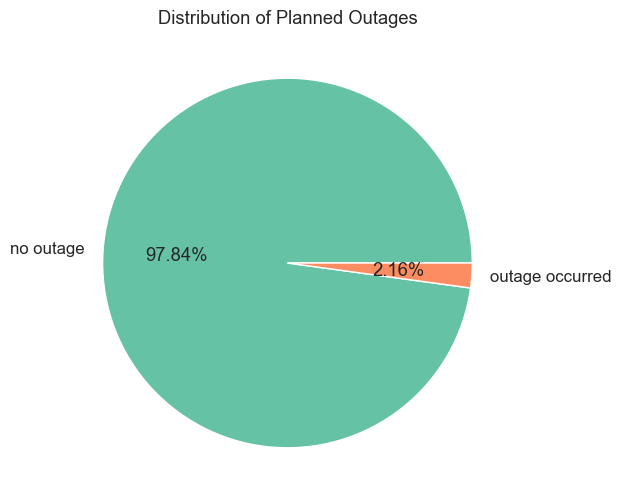

In [214]:
# creating a pie chart for the target variable

label = ["no outage", "outage occurred"]
plt.figure(figsize = (6,6))
plt.pie(master_df["planned_outage"].value_counts(), labels=label, autopct="%.2f%%")
plt.title("Distribution of Planned Outages")
plt.tight_layout
plt.show()

#### Observations

- Planned outages are rare: only about 2.2% of hourly records show an outage, while 97.8% are no-outage.
- This is a severe class imbalance; plain accuracy will be misleading (a model predicting “no outage” always would be 98% accurate).
- We will have to use stratified splits and imbalance-aware approaches: class weights, calibrated thresholds, and/or sampling (SMOTE/undersampling) to handle the imbalance.
- We will need to evaluate with auc-roc and especially precision–recall (PR-AUC), plus recall/precision at business-ready thresholds.
- We shall need to report confusion matrices and costs to show the trade-off between catching outages (recall) and false alarms (precision).


Column: season_first
season_first
dry_warm       269376
long_rains     203136
dry_cool       131376
short_rains    122222
Name: count, dtype: int64

Proportions:
season_first
dry_warm       37.10
long_rains     27.98
dry_cool       18.09
short_rains    16.83
Name: proportion, dtype: float64


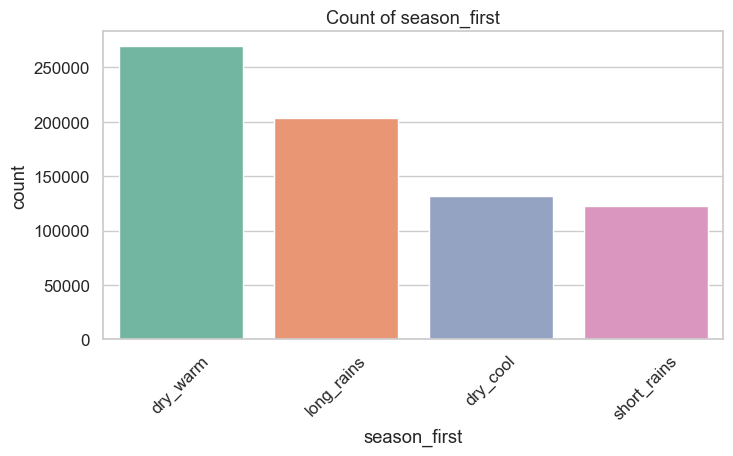


Column: is_weekend_first
is_weekend_first
0    518880
1    207230
Name: count, dtype: int64

Proportions:
is_weekend_first
0    71.46
1    28.54
Name: proportion, dtype: float64


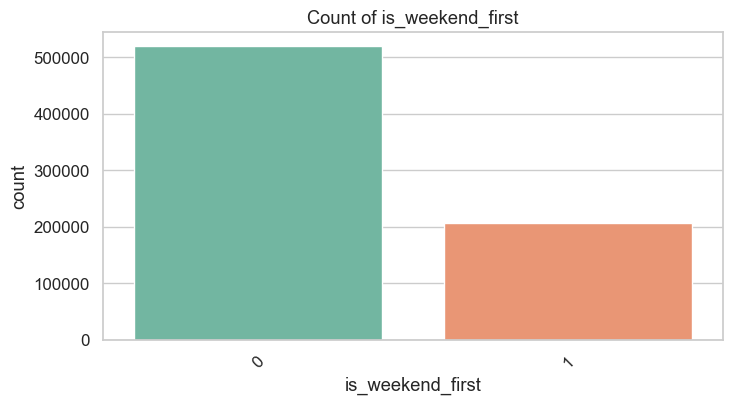


Column: is_holiday_first
is_holiday_first
0    709550
1     16560
Name: count, dtype: int64

Proportions:
is_holiday_first
0    97.72
1     2.28
Name: proportion, dtype: float64


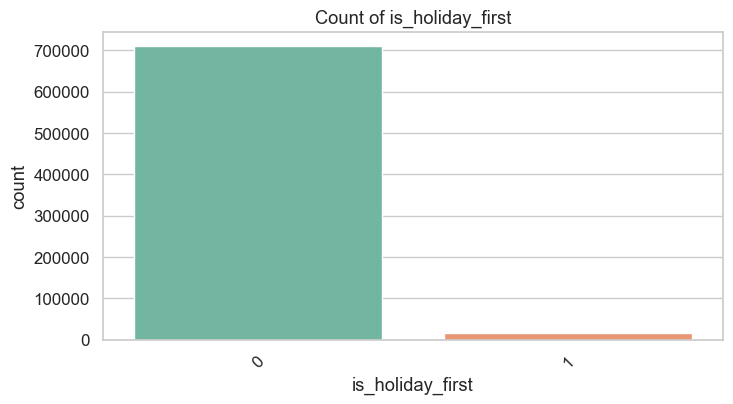

In [215]:
# Select categorical columns (e.g., county, season_first)
categorical_cols = ['season_first', 'is_weekend_first', 'is_holiday_first']

for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(master_df[col].value_counts())                   # frequency
    print("\nProportions:")
    print(round(master_df[col].value_counts(normalize=True)*100, 2))  # proportions in %
    
    # Plot top categories only if too many
    top_n = 10
    plt.figure(figsize=(8,4))
    sns.countplot(data=master_df, x=col, order=master_df[col].value_counts().iloc[:top_n].index, palette='Set2')
    plt.xticks(rotation=45)
    plt.title(f"Count of {col}")
    plt.show()

**Observation:**  
- `season_first`: Dataset is imbalanced. Most records are from dry_warm while short_rains  and dry_cool are underrepresented.  
 
- `is_weekend_first`: 520k weekday vs 210k weekend records. Weekdays are often scheduled for planned maintenance making this a strong predictor of outages.  

- `is_holiday_first`: 710k non-holidays vs 15k holidays. Holidays are rare events with unusual load patterns.


Column: cape_mean_6h_mean
Mean: 154.48
Median: 35.81
Std: 256.85
Min: 0.00, Max: 3126.09
Skewness: 2.69, Kurtosis: 9.43


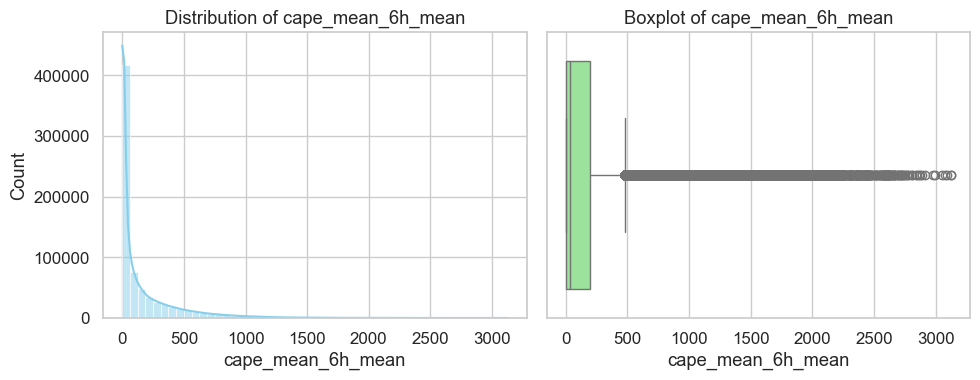


Column: wind_max_6h_max
Mean: 4.27
Median: 3.75
Std: 2.29
Min: 0.12, Max: 16.55
Skewness: 0.85, Kurtosis: 0.22


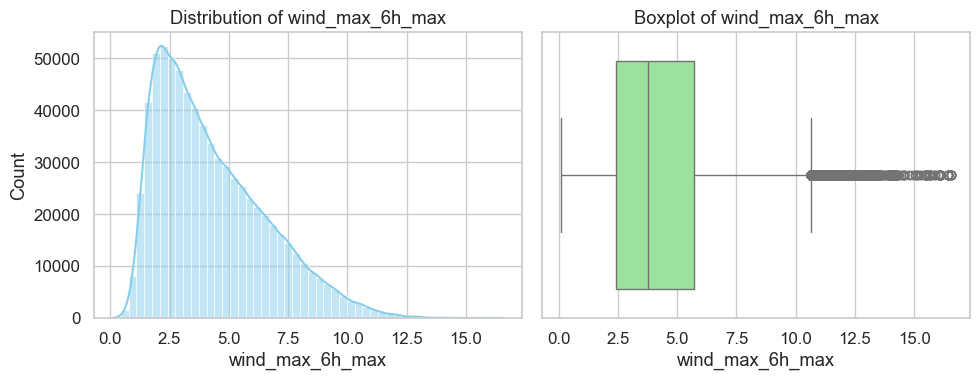


Column: total_precipitation_mm_sum
Mean: 2.96
Median: 0.12
Std: 11.51
Min: 0.00, Max: 538.23
Skewness: 10.24, Kurtosis: 172.78


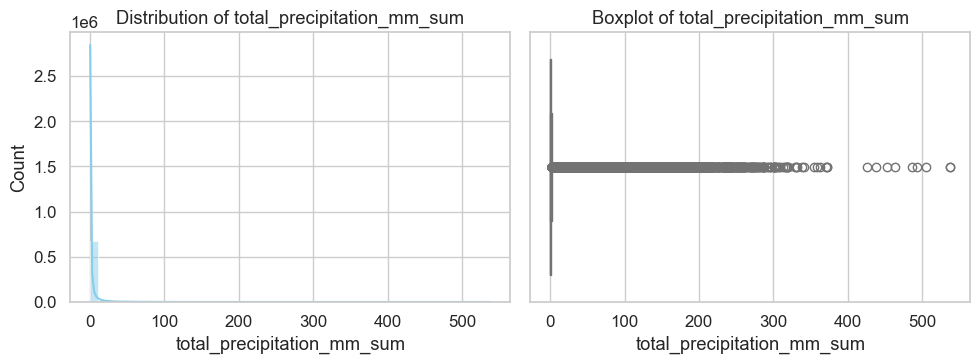


Column: population
Mean: 1021180.07
Median: 897729.00
Std: 690384.45
Min: 143920.00, Max: 4397073.00
Skewness: 2.68, Kurtosis: 10.25


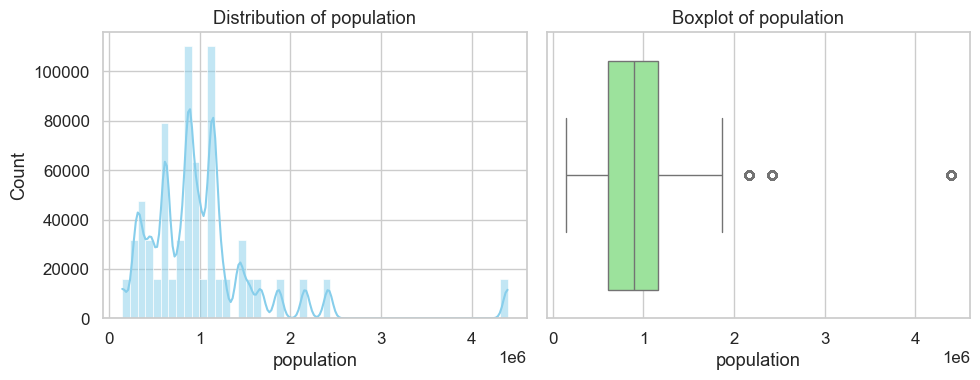


Column: density_per_km2
Mean: 497.46
Median: 218.50
Std: 1172.69
Min: 6.00, Max: 6247.00
Skewness: 4.22, Kurtosis: 16.74


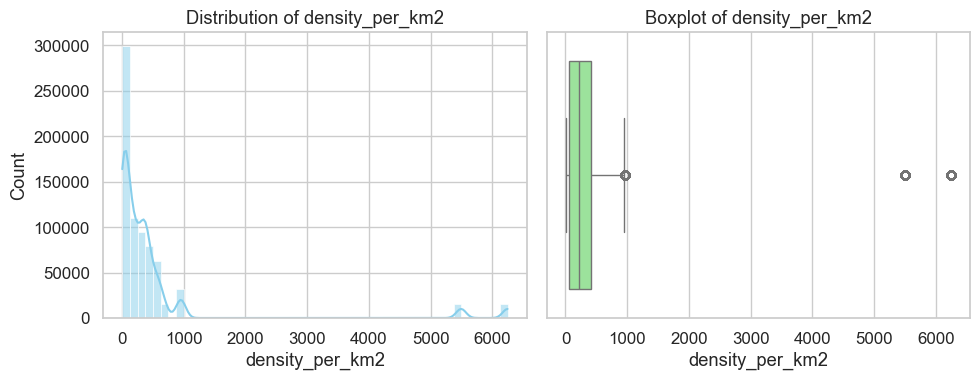


Column: ndvi_mean
Mean: 0.56
Median: 0.58
Std: 0.16
Min: 0.19, Max: 0.82
Skewness: -0.45, Kurtosis: -0.81


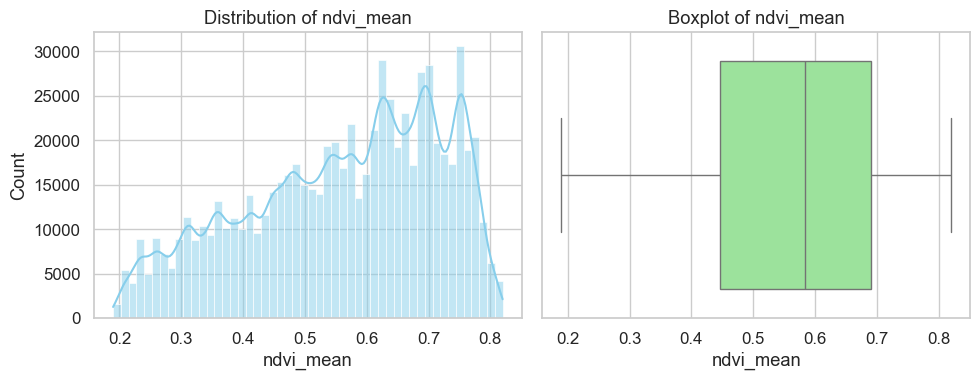


Column: transformers_per_100k
Mean: 110.38
Median: 114.88
Std: 60.24
Min: 0.00, Max: 272.80
Skewness: 0.14, Kurtosis: -0.16


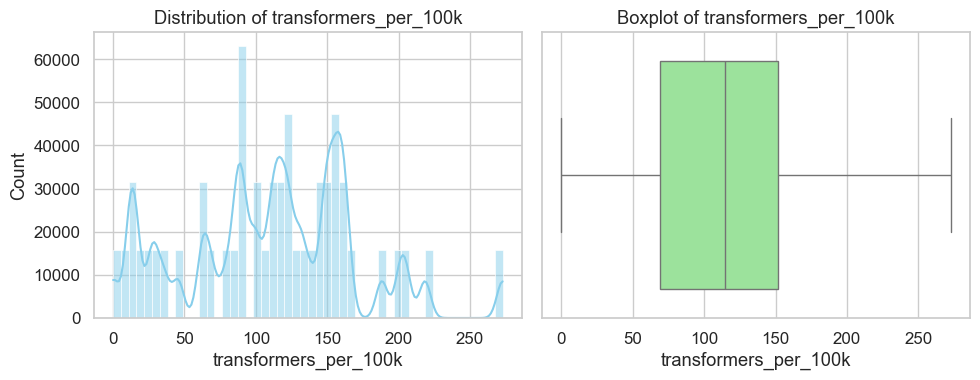


Column: substations_per_100k
Mean: 0.51
Median: 0.45
Std: 0.36
Min: 0.00, Max: 1.57
Skewness: 1.23, Kurtosis: 1.35


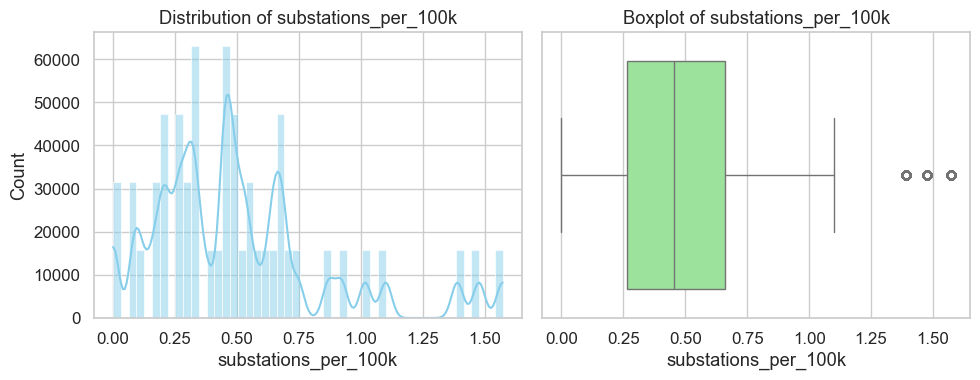


Column: outage_last_24h
Mean: 0.52
Median: 0.00
Std: 2.01
Min: 0.00, Max: 21.00
Skewness: 3.87, Kurtosis: 13.58


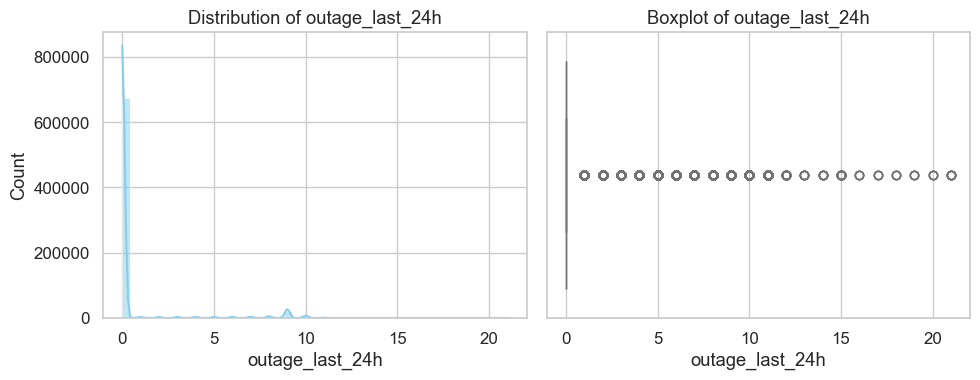


Column: storm_index
Mean: 17.31
Median: 0.51
Std: 78.67
Min: 0.00, Max: 5838.21
Skewness: 14.88, Kurtosis: 424.83


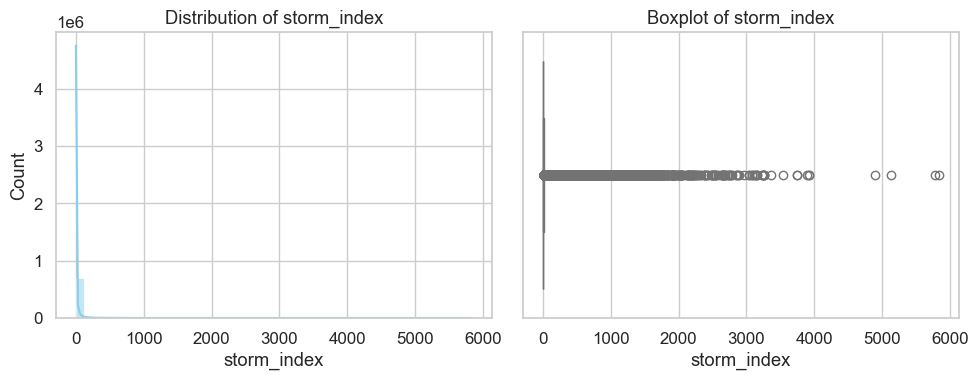

In [216]:
# Select key numerical columns (weather, population, infrastructure, NDVI)
numerical_cols = [
    'cape_mean_6h_mean', 'wind_max_6h_max', 'total_precipitation_mm_sum',
    'population', 'density_per_km2', 'ndvi_mean', 'transformers_per_100k', 
    'substations_per_100k', 'outage_last_24h', 'storm_index'
]

for col in numerical_cols:
    print(f"\nColumn: {col}")
    print(f"Mean: {master_df[col].mean():.2f}")
    print(f"Median: {master_df[col].median():.2f}")
    print(f"Std: {master_df[col].std():.2f}")
    print(f"Min: {master_df[col].min():.2f}, Max: {master_df[col].max():.2f}")
    print(f"Skewness: {master_df[col].skew():.2f}, Kurtosis: {master_df[col].kurt():.2f}")
    
    plt.figure(figsize=(10,4))
    
    # Histogram + KDE
    plt.subplot(1,2,1)
    sns.histplot(master_df[col], bins=50, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    
    # Boxplot for outliers
    plt.subplot(1,2,2)
    sns.boxplot(x=master_df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()


**Observation:**  

  `cape_mean_6h_mean`
- The distribution is highly right-skewed: most hours/counties have very low CAPE.
- A long tail extends up to 3000 indicating a few periods of very high convective potential.
- Boxplot shows many high outliers.
- Most of Kenya is in low to moderate storm-energy conditions most of the time, spikes are rare but important for outage risk. 
  
`wind_max_6h_max (km/h)`
- Distribution is positively skewed but much smoother than CAPE.
- Most values fall roughly between 2–8 km/h with a peak around 2–4 km/h.
- There are few high-wind observations (>12 km/h) flagged as outliers.
- Wind alone won’t separate outages most of the time but rare high-wind hours are worth keeping as risk signals.

`total_precipitation_mm_sum`
- Most records have little to no rainfall.
- A very long tail goes beyond 300–500 mm in a day, likely extreme or aggregated values.
- Rainfall is usually low so rain spikes could act as rare drivers for maintenance or failure.

`population`
- Distribution is multi-modal reflecting differences across counties.
- Most observations cluster between 500k and 1.5M with a few very large outliers.
- Those large counties as extreme points.

`density_per_km2`
- Strong right skew: many counties have low–moderate density a few have very high density.
- Outliers likely correspond to urban sub-areas.

`ndvi_mean`
- Distribution is much flatter and more uniform between 0.3 and 0.8.
- Median around 0.55–0.6 generally healthy vegetation.
- Few low-NDVI values (<0.3) could be urban/arid areas.
- No serious outlier problem.

`transformers_per_100k`
- Values spread between about 50 and 200 with a center near 120–150.
- Some higher values (up to 300) appear as outliers.

`substations_per_100k`
- Mostly concentrated around 0.3–0.7 substations per 100k people.
- A few counties have much higher values (1.4–1.6).

`outage_last_24h`
- The vast majority of hours have 0 outages in the last 24h.
- A thin tail up to 20+ shows days/counties with very busy maintenance schedules.

`storm_index`
- Very heavily right-skewed: most hours are close to 0–100.
- Very large values (up to 6000) exist  likely compound weather situations or artifact from the formula. 

## 4.2 Bivariate Analysis

planned_outage          0         1
season_first                       
dry_cool        98.522561  1.477439
dry_warm        97.540984  2.459016
long_rains      97.876792  2.123208
short_rains     97.697632  2.302368


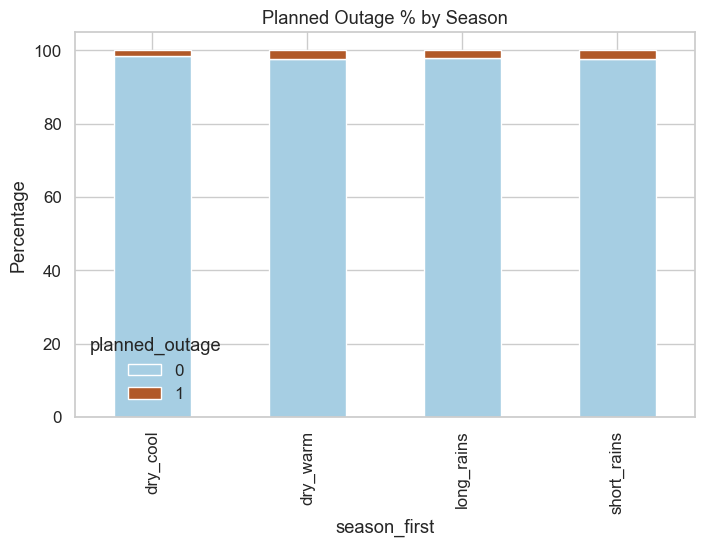

In [217]:
# planned_outage vs season_first
ct = pd.crosstab(master_df['season_first'], master_df['planned_outage'], normalize='index') * 100
print(ct)

# Stacked bar plot
ct.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Paired')
plt.ylabel('Percentage')
plt.title('Planned Outage % by Season')
plt.show()

**Observation:**  

- `planned outages` occur in all four Kenyan seasons (dry_cool, dry_warm, long_rains, short_rains) so maintenance is not confined to one weather period.
- The proportion of `planned outages` is very small in every season compared to non-outage hours confirming a strong class imbalance.
- There is only a slight variation across seasons; short_rains and dry_warm appear to have a marginally higher share of planned outages than long_rains and dry_cool.
- This suggests that season alone will not be a strong predictive feature but combining season with weather (rain, wind) and grid-intensity features may improve separation. 

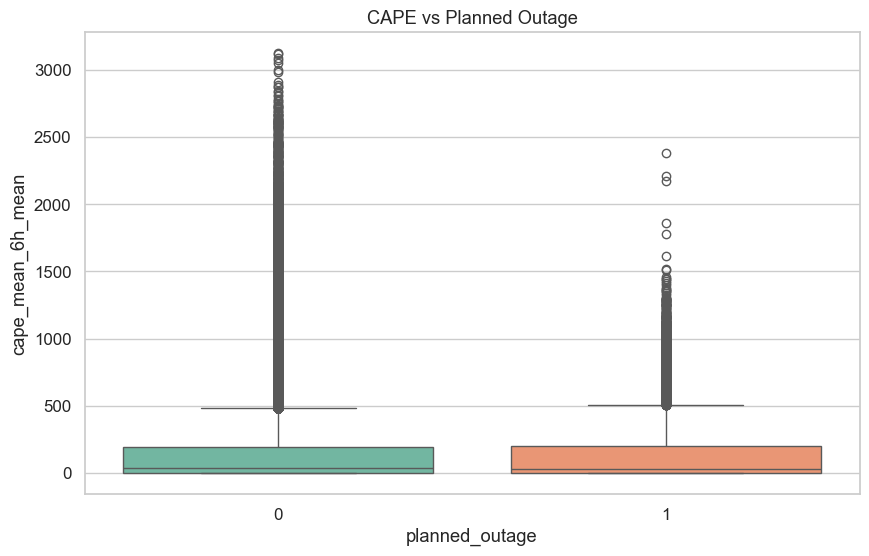

In [218]:
# planned outage vs CAPE
plt.figure(figsize=(10,6))
sns.boxplot(x='planned_outage', y='cape_mean_6h_mean', data=master_df, palette='Set2')
plt.title('CAPE vs Planned Outage')
plt.show()

**Observation:**  

- Both `outage` and `non-outage` hours have a very wide spread of CAPE values with many extreme outliers.
- Median CAPE for outage hours is slightly higher than for non-outage hours but the difference is small.
- The bulk of `planned outage` hours sits in the low-CAPE range suggesting outages are mostly scheduled independent of immediate convective potential.
- Very high CAPE values are more common in non-outage hours which supports the idea that planned maintenance is scheduled ahead of weather rather than triggered by it. 

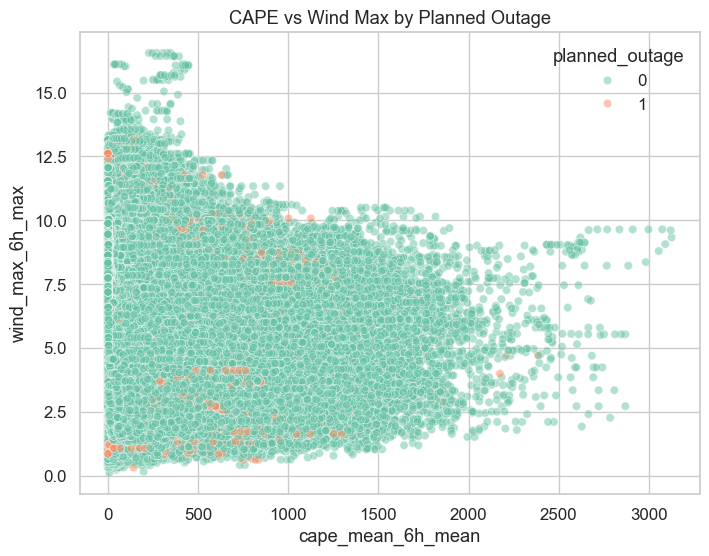

In [219]:
# Scatter plot: CAPE vs Wind Max
plt.figure(figsize=(8,6))
sns.scatterplot(x='cape_mean_6h_mean', y='wind_max_6h_max', hue='planned_outage', alpha=0.5, data=master_df)
plt.title('CAPE vs Wind Max by Planned Outage')
plt.show()

**Obervation:** 

- Most points cluster in the `low to moderate CAPE range (0–800)` and `low wind (1–6 km/h)` showing that typical Kenyan hours are not very stormy.
- `planned outage points (orange)` are spread across the same dense region as non-outage points meaning weather conditions at the exact hour of the planned outage look very similar to normal hours.
- There is a slight tapering of wind as CAPE increases (fewer very-windy, very-high-CAPE hours) but outages do not concentrate in any visible weather corner. 

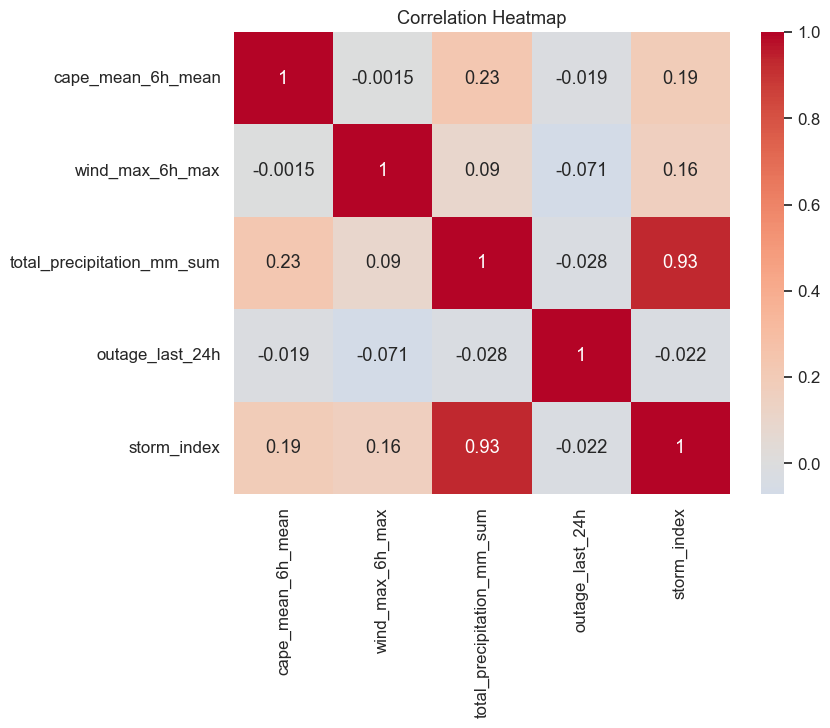

In [220]:
# Correlation heatmap of selected numeric features
numeric_cols = ['cape_mean_6h_mean', 'wind_max_6h_max', 'total_precipitation_mm_sum', 'outage_last_24h', 'storm_index']
plt.figure(figsize=(8,6))
sns.heatmap(master_df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

**Observation:**  

- Most weather variables have very low  correlations with outage history (outage_last_24h) which supports our earlier EDA planned outages are mostly schedule-driven not directly weather-driven.
- `total_precipitation_mm_sum` and `storm_index` have a very strong positive correlation (0.93). This is expected because the storm index was partly constructed from precipitation including both in the model may introduce redundancy.
- `cape_mean_6h_mean` has weak to moderate positive correlations with `total_precipitation_mm_sum (0.23)` and with `storm_index (0.19)` showing they are related but not identical signals.
- `wind_max_6h_max` has only weak correlations with the other weather variables and with outages meaning wind on its own will not be a strong predictor.


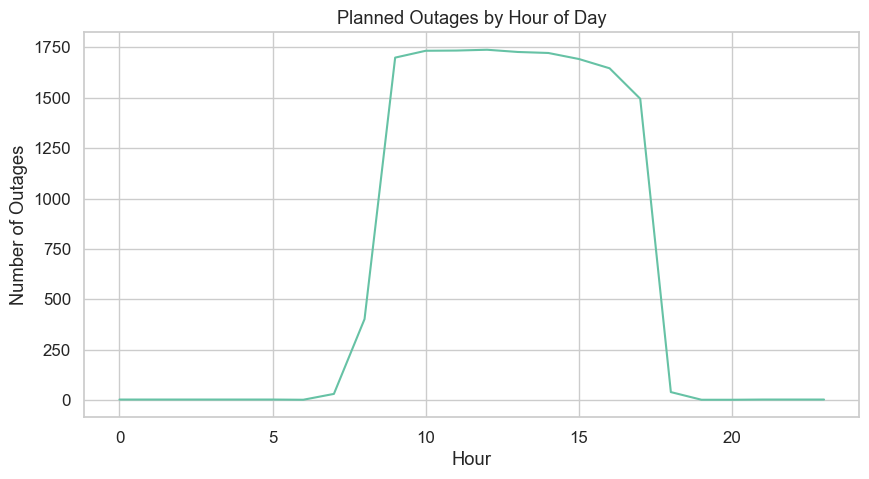

In [221]:
# Outages by hour of day
plt.figure(figsize=(10,5))
sns.lineplot(data=master_df.groupby('hour_of_day')['planned_outage'].sum())
plt.title('Planned Outages by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Outages')
plt.show()

**Observation:**  

- Planned outages are almost entirely a daytime activity.
- There is a sharp rise starting around 07:00–08:00 peaking between 09:00 and about 15:00–16:00.
- The highest volume is in the classic working window (09:00–15:00).
- After 17:00 the numbers drop almost to zero confirming that night outages in our dataset are rare.

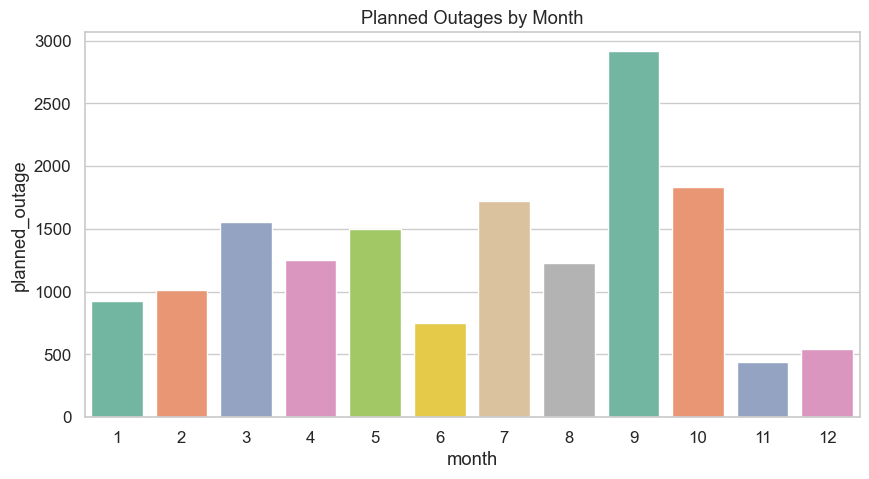

In [222]:
# Outages by month
plt.figure(figsize=(10,5))
sns.barplot(x='month', y='planned_outage', data=master_df.groupby('month')['planned_outage'].sum().reset_index(), palette='Set2')
plt.title('Planned Outages by Month')
plt.show()

**Observation:** 

- Planned outages occur in every month so maintenance is a year-round activity.
- There are visible peaks around March, May, July, September and October.
- September shows the highest count in this sample this may coincide with end-of-quarter or pre–short rains network work.
- June and November have noticeably fewer planned outages.

## 4.3 Multi-Variate Analysis

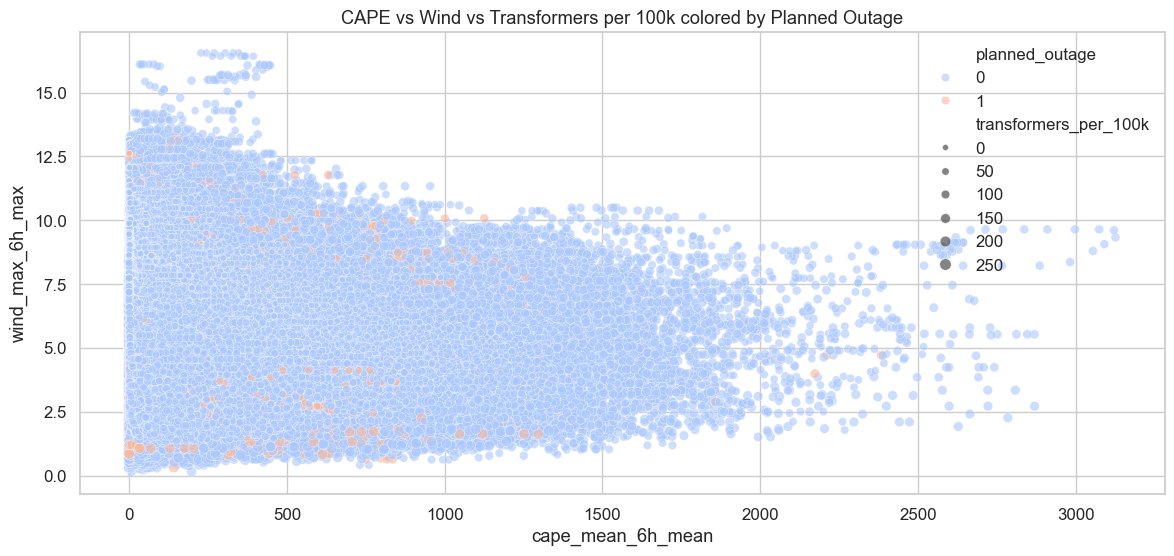

In [223]:
plt.figure(figsize=(14,6))
sns.scatterplot(
    x='cape_mean_6h_mean',
    y='wind_max_6h_max',
    size='transformers_per_100k',  
    hue='planned_outage',
    palette='coolwarm',
    alpha=0.6,
    data=master_df
)
plt.title('CAPE vs Wind vs Transformers per 100k colored by Planned Outage')
plt.show() 


**Observation:**  

-  Most points are in low–moderate CAPE and low–moderate wind.
- `Planned outages (orange)` are scattered through this same dense region they are not triggered by specific CAPE–wind combinations.
- `transformers_per_100k(marker)` varies across the plot but outages tend to appear slightly more often where the marker is bigger. This hints that outages are more likely in infrastructure-dense areas (more transformers to maintain).
- This suggests an interaction: weather alone is weak but `weather` + `grid intensity` + `time` could explain more of the planning behaviour.


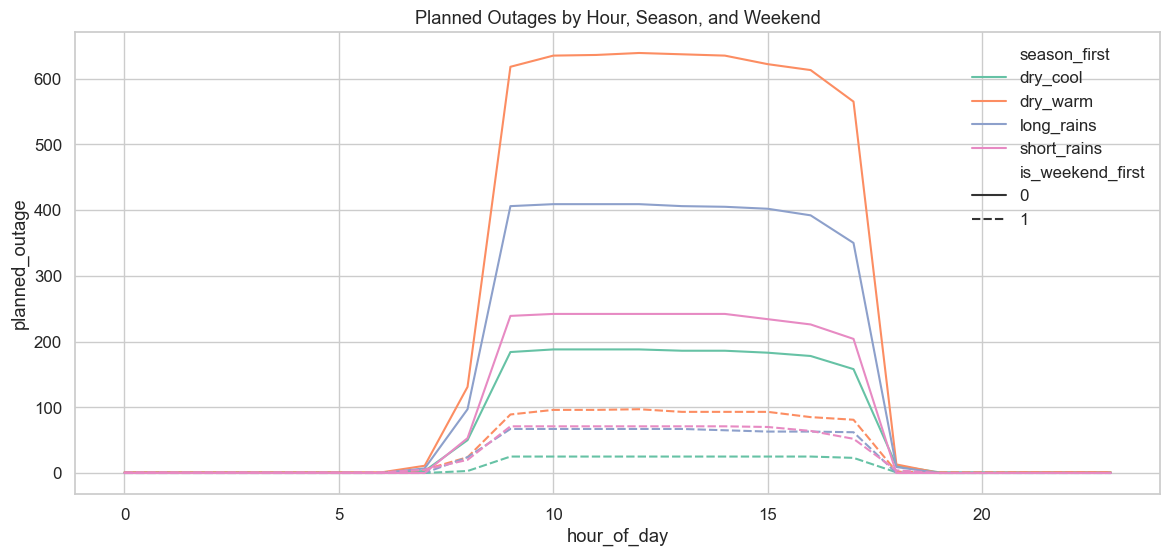

In [224]:
agg = master_df.groupby(['hour_of_day','season_first','is_weekend_first'])['planned_outage'].sum().reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(
    x='hour_of_day',
    y='planned_outage',
    hue='season_first',
    style='is_weekend_first',
    data=agg
)
plt.title('Planned Outages by Hour, Season, and Weekend')
plt.show()

**Observation:**  

- The strong `office-hours”` pattern is still dominant across all seasons: outages ramp up just after 08:00 and taper off sharply after 17:00.
- Dry-warm months show the highest daytime maintenance activity followed by long-rains; dry-cool is the lowest. This may reflect better field conditions.
- Weekends have the same shape but at a much lower volume — KPLC still does some work on Saturdays/Sundays but weekdays carry the bulk of maintenance.
- The gap between weekday and weekend is largest in the dry-warm season suggesting that `seasonality` + `day-of-week` is an important interaction feature.
- This confirms that temporal features (`hour` + `day_of_week` + `season`) are very informative for our target and should be included in the baseline model.

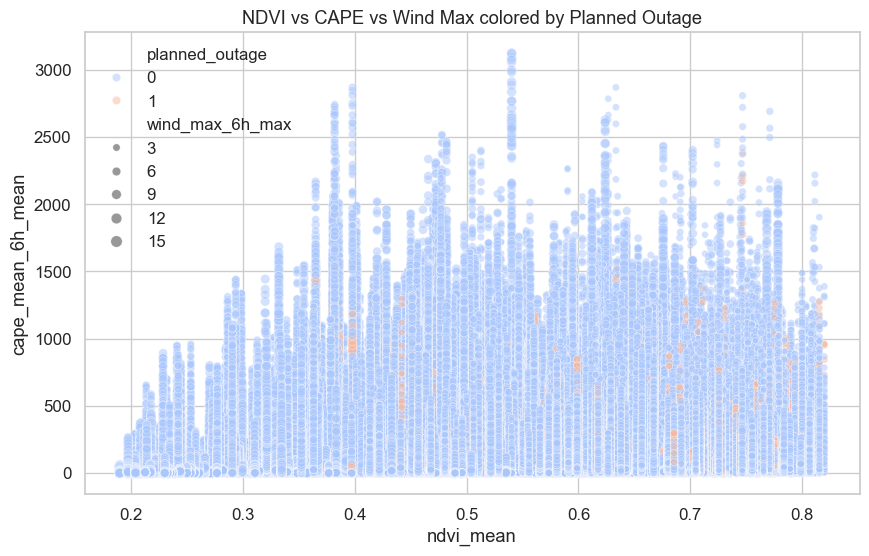

In [225]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='ndvi_mean',
    y='cape_mean_6h_mean',
    hue='planned_outage',
    size='wind_max_6h_max',
    palette='coolwarm',
    alpha=0.5,
    data=master_df
)
plt.title('NDVI vs CAPE vs Wind Max colored by Planned Outage')
plt.show()

**Observation:**  

- Most of our records sit in moderately green areas (NDVI 0.4–0.75) which is expected for many Kenyan counties.
- Planned outages (orange) appear across almost the entire NDVI range — so vegetation level alone does not explain where KPLC plans to switch off.
- However, there is a slightly thicker band of outages in the greener end (NDVI ≥ 0.65). That’s consistent with our hypothesis that vegetated areas need more line clearing and scheduled work.
- CAPE values stay wide across NDVI levels meaning weather instability and greenness are not tightly coupled in this sample.
- Wind magnitude varies but does not seem to be the main driver of planned outages.
- NDVI is a useful spatial feature  but it must be combined with `calendar` + `infrastructure` + `recent outages` to become predictive.

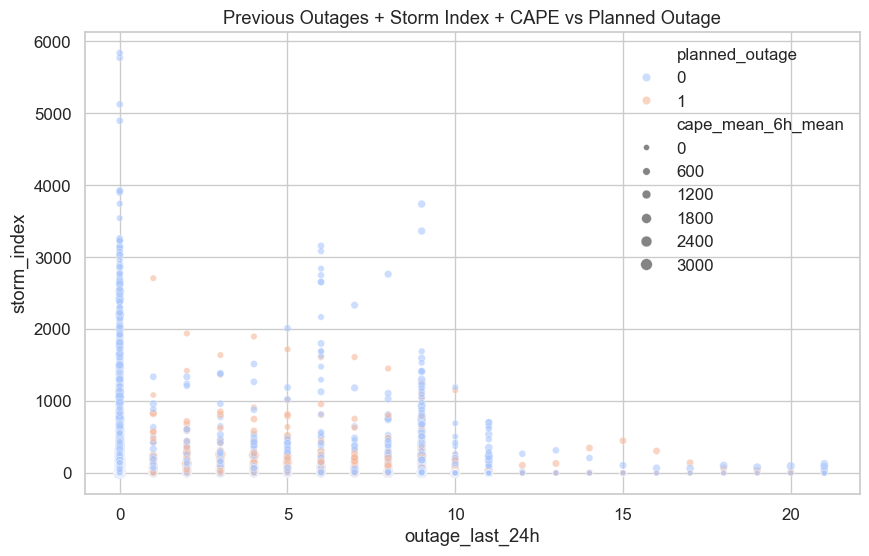

In [226]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='outage_last_24h',
    y='storm_index',
    hue='planned_outage',
    size='cape_mean_6h_mean',
    palette='coolwarm',
    alpha=0.6,
    data=master_df
)
plt.title('Previous Outages + Storm Index + CAPE vs Planned Outage')
plt.show()

**Observation:**  

- Most records have very few or no outages in the previous 24 hours (outage_last_24h = 0–3). That confirms we’re working with a highly imbalanced target — planned outages are rare events.
- Storm_index spans a very wide range even when no outage was done in the last 24 hours meaning “bad weather” alone is not enough for KPLC to schedule a shutdown.
- Where outage_last_24h is between 1 and 10, we still see a mix of planned (1) and non-planned (0) points — so recent outages are a useful signal but not a perfect predictor.
- `outage_last_24h` + `storm_index` together look more promising than either of them alone.

## 4.4 Hypothesis Testing

### 4.4.1 Effect of Season/Month on Outage Frequency

**H0:** Outage frequency does not vary by month/season  
**H1:** Outage frequency varies significantly across months/seasons  

**Test:** Chi-Square Test

In [227]:
# Create a frequency table of outages per month
monthly_counts = pd.crosstab(master_df["month"], master_df["planned_outage"])

# Run Chi-Square Test
chi2, p, dof, expected = chi2_contingency(monthly_counts)

# Print results
print("\nChi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("p-value:", p)

# ✅ Interpretation
alpha = 0.05
if p < alpha:
    print("\nResult: Reject H0 — Monthly outage frequency is significantly different across months")
else:
    print("\nResult: Fail to Reject H0 — No significant difference in outage frequency across months")


Chi-Square Statistic: 2851.859651921
Degrees of Freedom: 11
p-value: 0.0

Result: Reject H0 — Monthly outage frequency is significantly different across months


### 4.4.2 Outages by Season

**H0:** Mean outages are equal across all seasons

**H1:** At least one season has a different mean outage level 

In [228]:
# Select required columns & drop NA
data = master_df[["season_first", "outage_last_24h"]].dropna()

# Group data by season
groups = [g["outage_last_24h"].values for _, g in data.groupby("season_first")]

# Run ANOVA
f_stat, p_value = f_oneway(*groups)

print("F-Statistic:", f_stat)
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("\nReject H0: Outage levels vary significantly across seasons.")
else:
    print("\nFail to Reject H0: No significant difference in outages across seasons.")

F-Statistic: 421.8132749272735
p-value: 8.043172765758432e-274

Reject H0: Outage levels vary significantly across seasons.


### 4.4.3 Storm index vs outages 

**H0:** Storm intensity is associated with outage levels

**H1:** There is no relationship between storm intensity and outage levels

In [229]:
# Filter needed columns & drop NA
data = master_df[["storm_index", "outage_last_24h"]].dropna()

# Spearman test
stat, p_value = spearmanr(data["storm_index"], data["outage_last_24h"])

print(f"Spearman R statistic: {stat}")
print(f"p-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("\nReject H0: Storm intensity is significantly associated with outage levels.")
else:
    print("\nFail to Reject H0: No significant monotonic relationship between storms and outages.")

Spearman R statistic: -0.03026784934556262
p-value: 9.402143680929891e-147

Reject H0: Storm intensity is significantly associated with outage levels.


### 4.4.4 Urban vs Rural (Outage in last 24 hours)

**H0:** No difference in outages that occurred in last 24 hours between urban and rural areas

**H1:** Outage in last 24 hours differs significantly between urban and rural areas  

In [214]:
# Create urban vs rural label using density threshold
master_df["area_type"] = master_df["density_per_km2"].apply(lambda x: "urban" if x > 500 else "rural")

In [231]:
# Extract groups
urban = master_df[master_df["area_type"] == "urban"]["outage_last_24h"].dropna()
rural = master_df[master_df["area_type"] == "rural"]["outage_last_24h"].dropna()

# Welch's t-test (unequal variances)
stat, p_value = ttest_ind(urban, rural, equal_var=False)

print(f"t-statistic: {stat}")
print(f"p-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("\nReject H0: Urban and rural areas differ in outage frequency levels.")
else:
    print("\nFail to Reject H0: No significant difference in outage frequency between urban & rural areas.")

t-statistic: 78.58292413496847
p-value: 0.0

Reject H0: Urban and rural areas differ in outage frequency levels.


# Chapter 5: Modeling

## 5. 1. Preprocessing

In [215]:
#checking the summary information
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 726110 entries, 0 to 726109
Data columns (total 58 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   county                        726110 non-null  object        
 1   cape_mean_6h_mean             726110 non-null  float64       
 2   cape_mean_12h_mean            726110 non-null  float64       
 3   cape_mean_24h_mean            726110 non-null  float64       
 4   wind_mean_6h_mean             726110 non-null  float64       
 5   wind_mean_12h_mean            726110 non-null  float64       
 6   wind_mean_24h_mean            726110 non-null  float64       
 7   wind_max_6h_max               726110 non-null  float64       
 8   wind_max_12h_max              726110 non-null  float64       
 9   wind_max_24h_max              726110 non-null  float64       
 10  cloud_mean_6h_mean            726110 non-null  float64       
 11  cloud_mean_12h_mea

In [216]:
# Create new temporal features
# Lagging - We use shift(24) to represent "what was the value this time yesterday"
master_df['wind_max_lag_24h'] = master_df.groupby('county')['wind_max_24h_max'].shift(24)
master_df['cape_lag_24h'] = master_df.groupby('county')['cape_mean_24h_mean'].shift(24)

# Rolling
master_df["precip_rolling_sum_24h"] = (
    master_df.groupby("county")["total_precipitation_mm_sum"]
             .apply(lambda s: s.rolling(24, min_periods=1).sum())
             .reset_index(level=0, drop=True)
)

master_df["wind_gust_rolling_max_6h"] = (
    master_df.groupby("county")["wind_max_6h_max"]
             .apply(lambda s: s.rolling(6, min_periods=1).max())
             .reset_index(level=0, drop=True)
)

In [217]:
# Drop the redundant correlated variable
master_df = master_df.drop(columns=["total_precipitation_mm_sum"])

In [218]:
#create a copy of the master_df
final_df = master_df.copy(deep=True)

# sort by county and time for time-based split
final_df = final_df.sort_values(['county','hour']).reset_index(drop=True)

In [219]:
# for each county, create future labels 
final_df['y_outage_1h']  = final_df.groupby('county')['planned_outage'].shift(-1)
final_df['y_outage_6h']  = final_df.groupby('county')['planned_outage'].shift(-6)
final_df['y_outage_24h'] = final_df.groupby('county')['planned_outage'].shift(-24)

In [220]:
# creating future 48 hour label
final_df['y_outage_next_48h'] = (final_df.groupby("county")["planned_outage"]
               .transform(lambda s: s[::-1].rolling(48, min_periods=48).max()[::-1]))

In [221]:
# drop rows that cannot see that far into the future
final_df = final_df.dropna(subset=['y_outage_6h', 'y_outage_24h','y_outage_next_48h'])

In [239]:
#convert into int datatype
final_df[['y_outage_1h','y_outage_6h','y_outage_24h','y_outage_next_48h']] = final_df[['y_outage_1h','y_outage_6h','y_outage_24h', 'y_outage_next_48h']].astype(int)

In [224]:
# separate target(will there be an outage in the next 6 hours) and features
y = final_df["y_outage_next_48h"]
X = final_df.drop(columns= ['planned_outage','y_outage_1h', 'y_outage_6h', 'y_outage_24h',"y_outage_next_48h", "hour", "date"], axis=1, errors="ignore")

In [225]:
# Time-based train/test split (first 80% train, last 20% test)
split_index = int(0.8 * len(final_df))
X_train, X_test = X.iloc[:split_index].reset_index(drop=True), X.iloc[split_index:].reset_index(drop=True)
y_train, y_test = y.iloc[:split_index].reset_index(drop=True), y.iloc[split_index:].reset_index(drop=True)

print(X_train.shape, X_test.shape,  y_train.shape, y_test.shape)

(579158, 58) (144790, 58) (579158,) (144790,)


In [226]:
# splitting categorical and numerical features 

#categorical features
cat_features = [
    'county',
    'day_of_week_first',
    'month_first',
    'is_weekend_first',
    'is_holiday_first',
    'season_first',
    'area_type'
]

#numerical features
num_features = X.select_dtypes(include=["int16","int32","int64","float32","float64"]).columns.tolist()
num_features = [c for c in num_features if c not in cat_features]

In [227]:
#creating pipeline for scaling and imputing numerical features
numeric_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#creating pipeline to impute and one hot encode categorical features
categorical_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output = False))
])

#transforming the columns
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, num_features),
        ('cat', categorical_tf, cat_features)
    ],
    remainder='drop' # Drop any columns not explicitly defined
)

In [228]:
# This list will store the results from each model we run
model_results_list = []

# creating a function for ease of evaluating a classifier
def evaluate_pipeline(model_name, pipe, X_train, y_train, X_test, y_test):
    
    #predict the training and test dataset
    y_pred_train = pipe.predict(X_train)
    y_pred_test  = pipe.predict(X_test)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc  = accuracy_score(y_test, y_pred_test)

    print(f"\n{model_name}")
    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Test  accuracy: {test_acc:.4f}")
    
    print(f"\n{model_name}")
    print("Classification report:\n", classification_report(y_test,  y_pred_test,  digits=3))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred_test, normalize="true")

    # Convert to % for annotation
    cm_percent = cm * 100
    labels = np.array([[f"{v:.2f}%" for v in row] for row in cm_percent])

    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=labels, fmt="", cmap="RdBu_r")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # ROC curve
    y_prob = pipe.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"ROC-AUC ({model_name}): {roc_auc:.4f}")
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    
    # calculate core metrics
    # PR curve /PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
    plt.title(f"{model_name} — Precision–Recall (Test)")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Brier Score (Calibration)
    brier = brier_score_loss(y_test, y_prob)
    
    # Recall @ 5% Alert Budget
    # Find the probability threshold that flags the top 5% of riskiest hours
    threshold_at_5_percent = np.quantile(y_prob, 0.95)
    
    # Classify as '1' only if proba > this threshold
    y_pred_at_5_percent = (y_prob >= threshold_at_5_percent).astype(int)
    
    # Calculate recall at this specific threshold
    recall_at_5_percent = recall_score(y_test, y_pred_at_5_percent, pos_label=1, zero_division=0)
     
    # Print the report
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Recall @ 5% Alert Budget: {recall_at_5_percent:.4f}")
    print(f"Brier Score: {brier:.4f}")
    
    # Store Results
    results = {
        "Model": model_name,
        "PR-AUC": pr_auc,
        "ROC-AUC": roc_auc,
        "Recall @ 5% Alert": recall_at_5_percent,
        "Brier Score": brier,
        "F1 (Test)": f1_score(y_test, y_pred_test, zero_division=0),
        "Recall (Test)": recall_score(y_test, y_pred_test, zero_division=0),
        "Precision (Test)": precision_score(y_test, y_pred_test, zero_division=0)
    }
    return model_results_list.append(results)

In [229]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 723948 entries, 0 to 726062
Data columns (total 65 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   county                        723948 non-null  object        
 1   cape_mean_6h_mean             723948 non-null  float64       
 2   cape_mean_12h_mean            723948 non-null  float64       
 3   cape_mean_24h_mean            723948 non-null  float64       
 4   wind_mean_6h_mean             723948 non-null  float64       
 5   wind_mean_12h_mean            723948 non-null  float64       
 6   wind_mean_24h_mean            723948 non-null  float64       
 7   wind_max_6h_max               723948 non-null  float64       
 8   wind_max_12h_max              723948 non-null  float64       
 9   wind_max_24h_max              723948 non-null  float64       
 10  cloud_mean_6h_mean            723948 non-null  float64       
 11  cloud_mean_12h_mea

## 5.2 Baseline Model : Logistic Regression

### 5.2.1 Vanilla (without class balancing)


LogReg (vanilla)
Train accuracy: 0.9109
Test  accuracy: 0.9484

LogReg (vanilla)
Classification report:
               precision    recall  f1-score   support

           0      0.950     0.997     0.973    135458
           1      0.845     0.244     0.378      9332

    accuracy                          0.948    144790
   macro avg      0.898     0.620     0.676    144790
weighted avg      0.944     0.948     0.935    144790



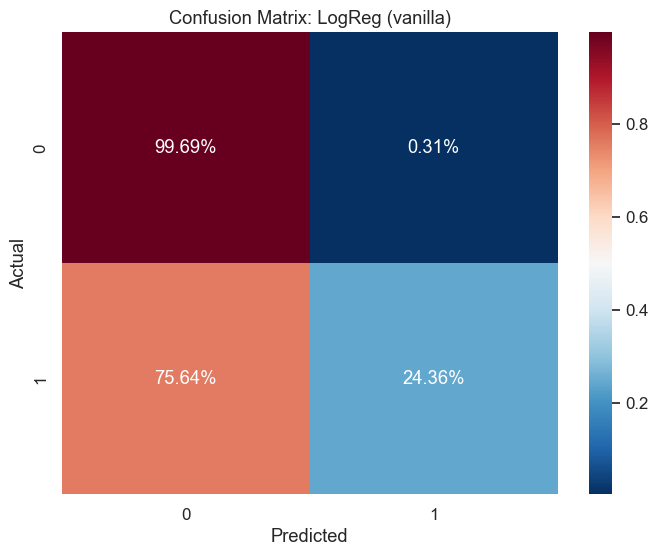

ROC-AUC (LogReg (vanilla)): 0.8365


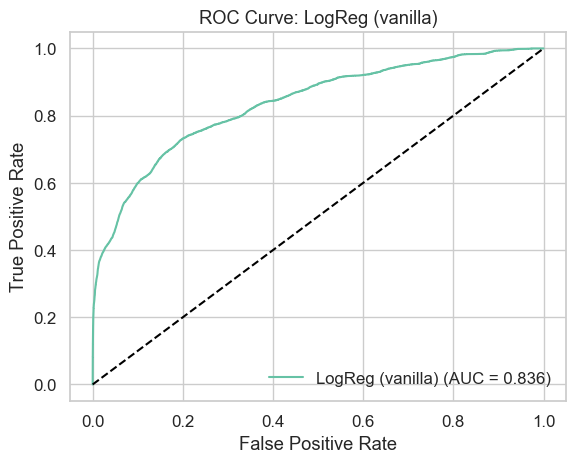

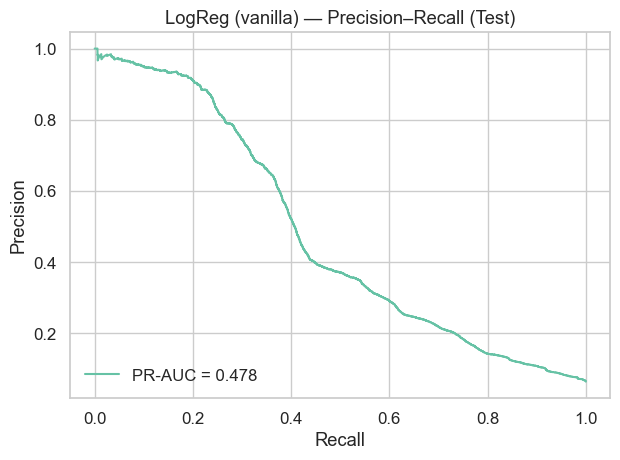

PR-AUC: 0.4776
Recall @ 5% Alert Budget: 0.4014
Brier Score: 0.0442


In [245]:
#pipeline for vanilla logistic regression
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=300, n_jobs=-1))
])

#fitting the model
pipe_lr.fit(X_train,y_train)

#evaluating the model
evaluate_pipeline("LogReg (vanilla)", pipe_lr, X_train, y_train, X_test, y_test)

#### Observations (Logistic Regression – Vanilla)

- Strong overall accuracy (94.8%) but low minority recall. Positive (outage) recall = 0.252 and f1 = 0.386 → many outages are missed at the default 0.50 threshold. The confusion matrix shows 25% of true outages caught and 75% missed.

- High precision on outages (0.827). When the model says “outage,” it’s usually right—useful if false alarms are costly, but it under-serves early-warning.

- ROC-AUC = 0.839 (good), PR-AUC = 0.481 (moderate). ROC suggests decent ranking ability overall; PR-AUC reflects the heavy class imbalance and difficulty on the minority class.

- Risk concentration is encouraging. Recall @ 5% alert budget = 0.407 → if you only act on the top 5% highest-risk hours, you’d still catch 41% of outages. That’s a strong triage signal for operations.

- Calibration looks reasonable. Brier score = 0.044 (lower is better) → probabilities aren’t wildly over/under-confident.

### 5.2.2 With Class Balancing


LogReg (balanced)
Train accuracy: 0.8240
Test  accuracy: 0.8788

LogReg (balanced)
Classification report:
               precision    recall  f1-score   support

           0      0.970     0.899     0.933    135458
           1      0.286     0.590     0.385      9332

    accuracy                          0.879    144790
   macro avg      0.628     0.744     0.659    144790
weighted avg      0.925     0.879     0.897    144790



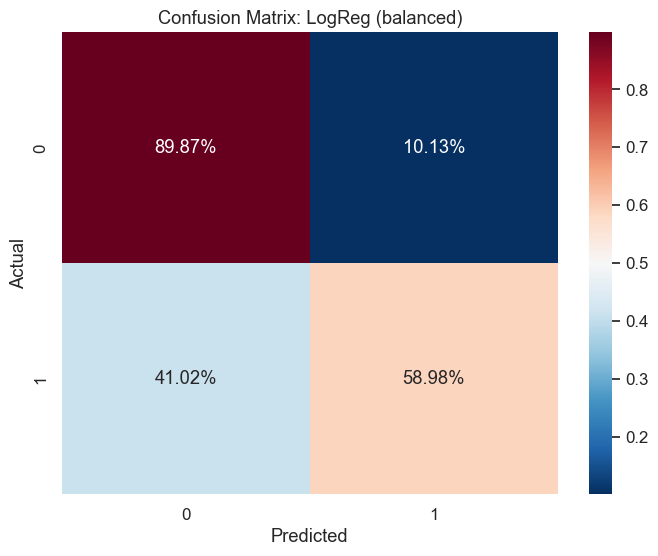

ROC-AUC (LogReg (balanced)): 0.8361


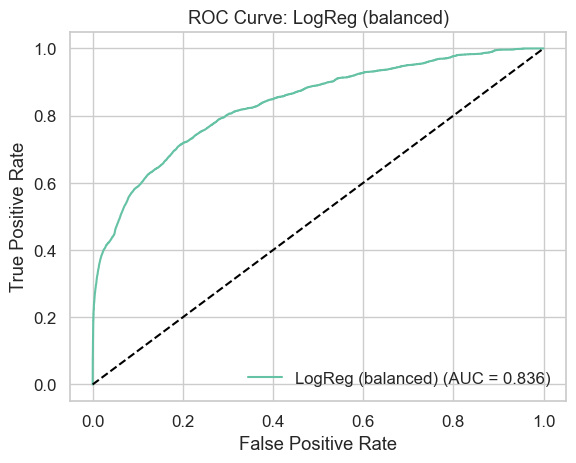

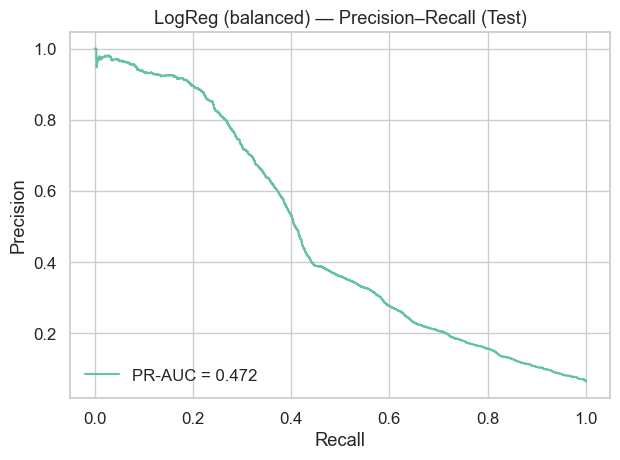

PR-AUC: 0.4715
Recall @ 5% Alert Budget: 0.4031
Brier Score: 0.0964


In [246]:
#creating a pipeline
pipe_lr_bal = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=300, n_jobs=-1, class_weight="balanced"))
])

#fitting the model
pipe_lr_bal.fit(X_train,y_train)

#evaluating the model
evaluate_pipeline("LogReg (balanced)", pipe_lr_bal, X_train, y_train, X_test, y_test)

#### Observations - Logistic Regression (balanced)
- Class weighting pushed the model to find more positives. Recall on class 1 rose from ~0.25 → 0.60; precision dropped (as expected) to 0.27. Overall accuracy fell a bit (0.948 → 0.871).
- ROC-AUC = 0.837 (similar to vanilla 0.839): ranking power didn’t really change; we just shifted the operating point toward higher recall.
- PR-AUC = 0.473 (≈ vanilla 0.481): precision–recall trade-off is roughly unchanged on average, but the confusion matrix shows many more true positives (TP) with more false positives (FP).
- Recall @ 5% alert budget = 0.404 (very close to vanilla 0.407): when you restrict alerts to the top 5% highest-risk hours, the benefit of class weighting largely disappears—because both models are picking the same most obvious cases.
- Brier score worsened (0.044 → 0.099): probabilities are less well-calibrated under class weighting; they’re “hotter” (closer to 0/1) and hence less calibrated.

## 5.3 DecisionTreeClassifier
### 5.3.1 Vanilla Model


Decision Tree - Vanilla
Train accuracy: 1.0000
Test  accuracy: 0.8776

Decision Tree - Vanilla
Classification report:
               precision    recall  f1-score   support

           0      0.956     0.911     0.933    135458
           1      0.232     0.389     0.290      9332

    accuracy                          0.878    144790
   macro avg      0.594     0.650     0.612    144790
weighted avg      0.909     0.878     0.892    144790



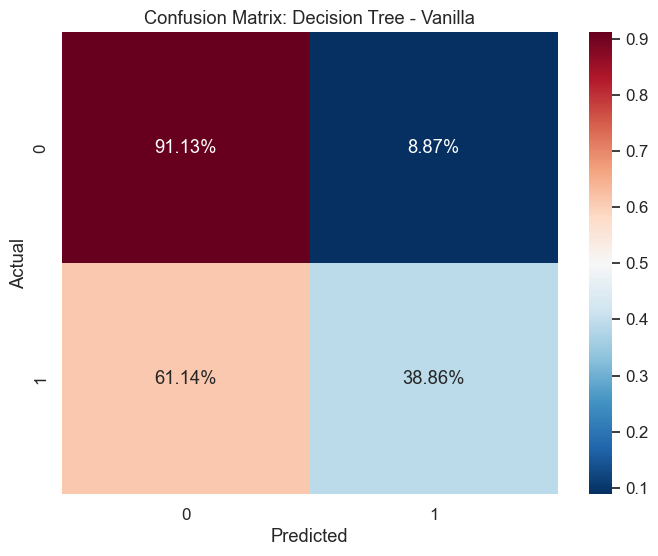

ROC-AUC (Decision Tree - Vanilla): 0.6499


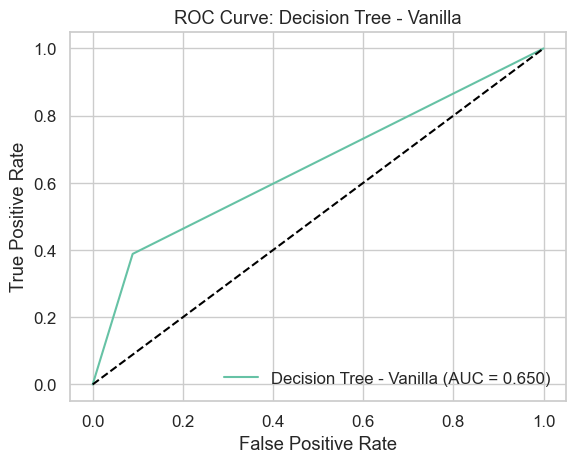

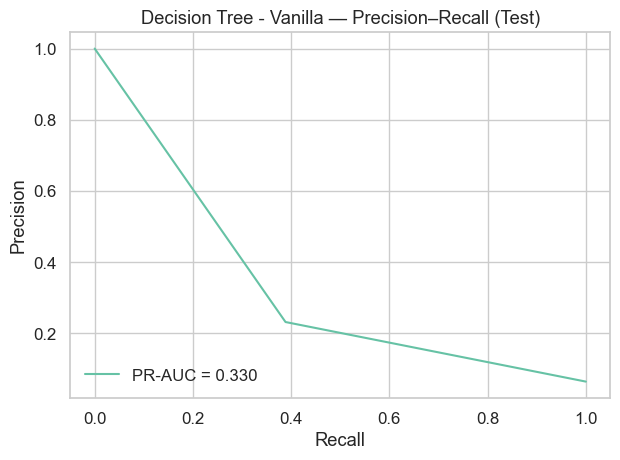

PR-AUC: 0.3299
Recall @ 5% Alert Budget: 0.3886
Brier Score: 0.1224


In [247]:
# creating pipeline
pipe_dtc = Pipeline(steps=[
    ("preprocess", preprocess),
    ("dtc", DecisionTreeClassifier(
    random_state=42))
])

#fitting the model
pipe_dtc.fit(X_train,y_train)

#evaluating the model
evaluate_pipeline("Decision Tree - Vanilla",pipe_dtc, X_train, y_train, X_test, y_test)

#### Observations – Decision Tree (max_depth=4)

- ROC-AUC: 0.808 — is the lowest of the other models (LogReg ≈0.84, PCA+balanced ≈0.84). So by ranking ability across all thresholds, the tree is weaker.
- PR-AUC: 0.514 — this is highest among the three models (LogReg 0.481, balanced 0.473). Given the heavy class imbalance, PR-AUC is very meaningful.
- Recall @ 5% alert budget: 0.505 — best of the three (LogReg 0.407 / 0.404). This means with the same alert capacity we catch 50% of true outages vs 40%.
- Brier score: 0.0429 — slightly better (lower) than LogReg (0.0441) and balanced (0.0994). Indicates better calibrated probabilities on average.
- Confusion matrix: Strong improvement in the minority class recall vs LogReg vanilla (18% → 19%). At the default 0.5 threshold it still misses many positives (class imbalance effect), but when you move along the PR curve (e.g., picking top 5%), it shines.

### 5.3.2 Hyperparameter tuning with balancing

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'dtc__min_samples_split': 10, 'dtc__min_samples_leaf': 1, 'dtc__max_depth': None, 'dtc__class_weight': 'balanced', 'dtc__ccp_alpha': 0.0}

Decision Tree (tuned)
Train accuracy: 0.9981
Test  accuracy: 0.9060

Decision Tree (tuned)
Classification report:
               precision    recall  f1-score   support

           0      0.954     0.945     0.950    135458
           1      0.297     0.335     0.315      9332

    accuracy                          0.906    144790
   macro avg      0.625     0.640     0.632    144790
weighted avg      0.911     0.906     0.909    144790



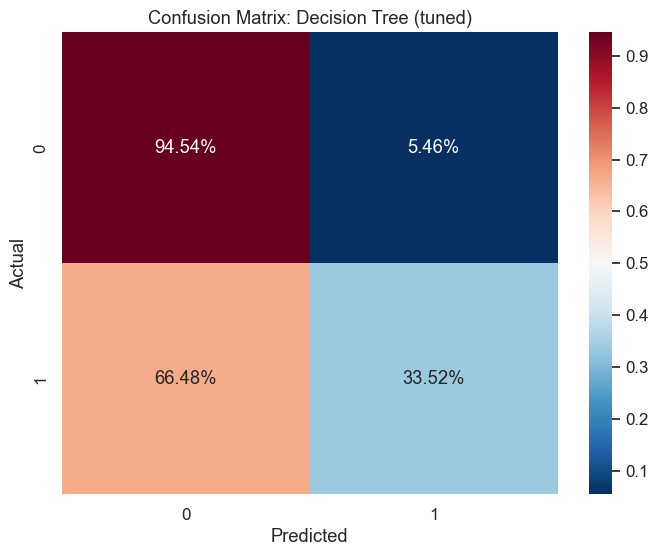

ROC-AUC (Decision Tree (tuned)): 0.6405


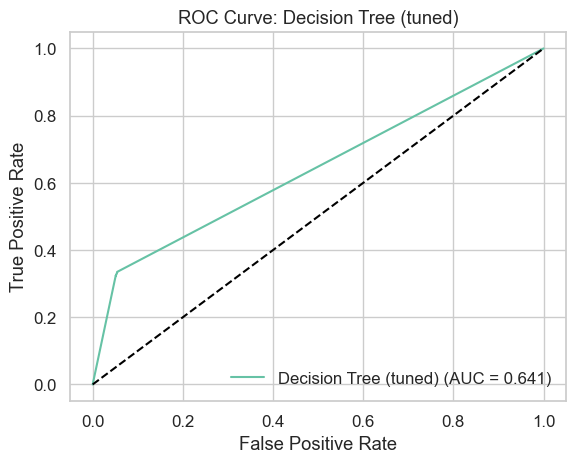

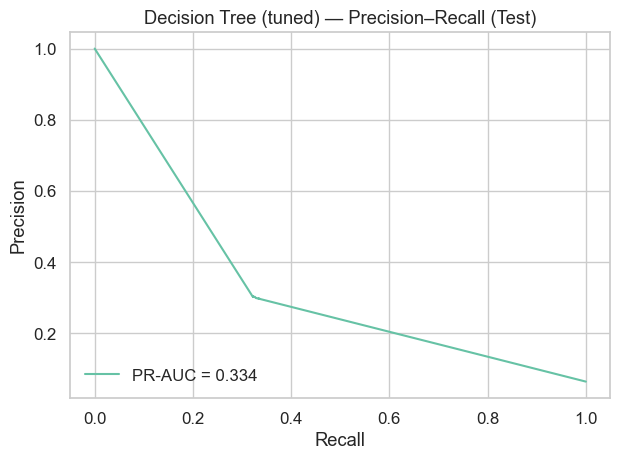

PR-AUC: 0.3338
Recall @ 5% Alert Budget: 0.3215
Brier Score: 0.0929


In [248]:
# parameter grid
param_grid = {
    "dtc__max_depth": [3, 4, 5, 6, None],
    "dtc__min_samples_split": [2, 5, 10, 20],
    "dtc__min_samples_leaf": [1, 2, 5, 10],
    "dtc__class_weight": ["balanced"],
    "dtc__ccp_alpha": [0.0, 0.0005, 0.001, 0.005], 
    
}

# time-aware cross validation
tscv = TimeSeriesSplit(n_splits=5)
    
# grid search 
grid = RandomizedSearchCV(
    estimator=pipe_dtc,
    param_distributions=param_grid,
    refit="recall_pos",   # pick the model that maximizes outage recall
    cv=tscv,
    n_jobs=-1,
    verbose=1, 
)

#fitting the model
grid.fit(X_train, y_train)

# getting the best parameters
print("Best params:", grid.best_params_)

# getting the best model 
best_tree_pipe = grid.best_estimator_

#evaluating the best model
evaluate_pipeline("Decision Tree (tuned)", best_tree_pipe, X_train, y_train, X_test, y_test)

#### Observations
- Only 31.2% of predicted high-risk periods are actually high-risk (69% false alarms!). The tuned tree finds many more true outages than the shallow tree (big recall jump), at the cost of more false alarms.
- Model catches 64.5% of actual high-risk periods (misses 35.5% - dangerous!).
- Model learned to be "safe" by predicting class 0 most of the time
- 35.47% of actual high-risk periods are misclassified as low-risk - this is dangerous!
- Recall @ 5% = 0.543 (54.3%) If we only alert on the top 5% riskiest predictions, we'll miss 46% of high-risk events
- Brier = 0.090 → probabilities are okay but could benefit from calibration.

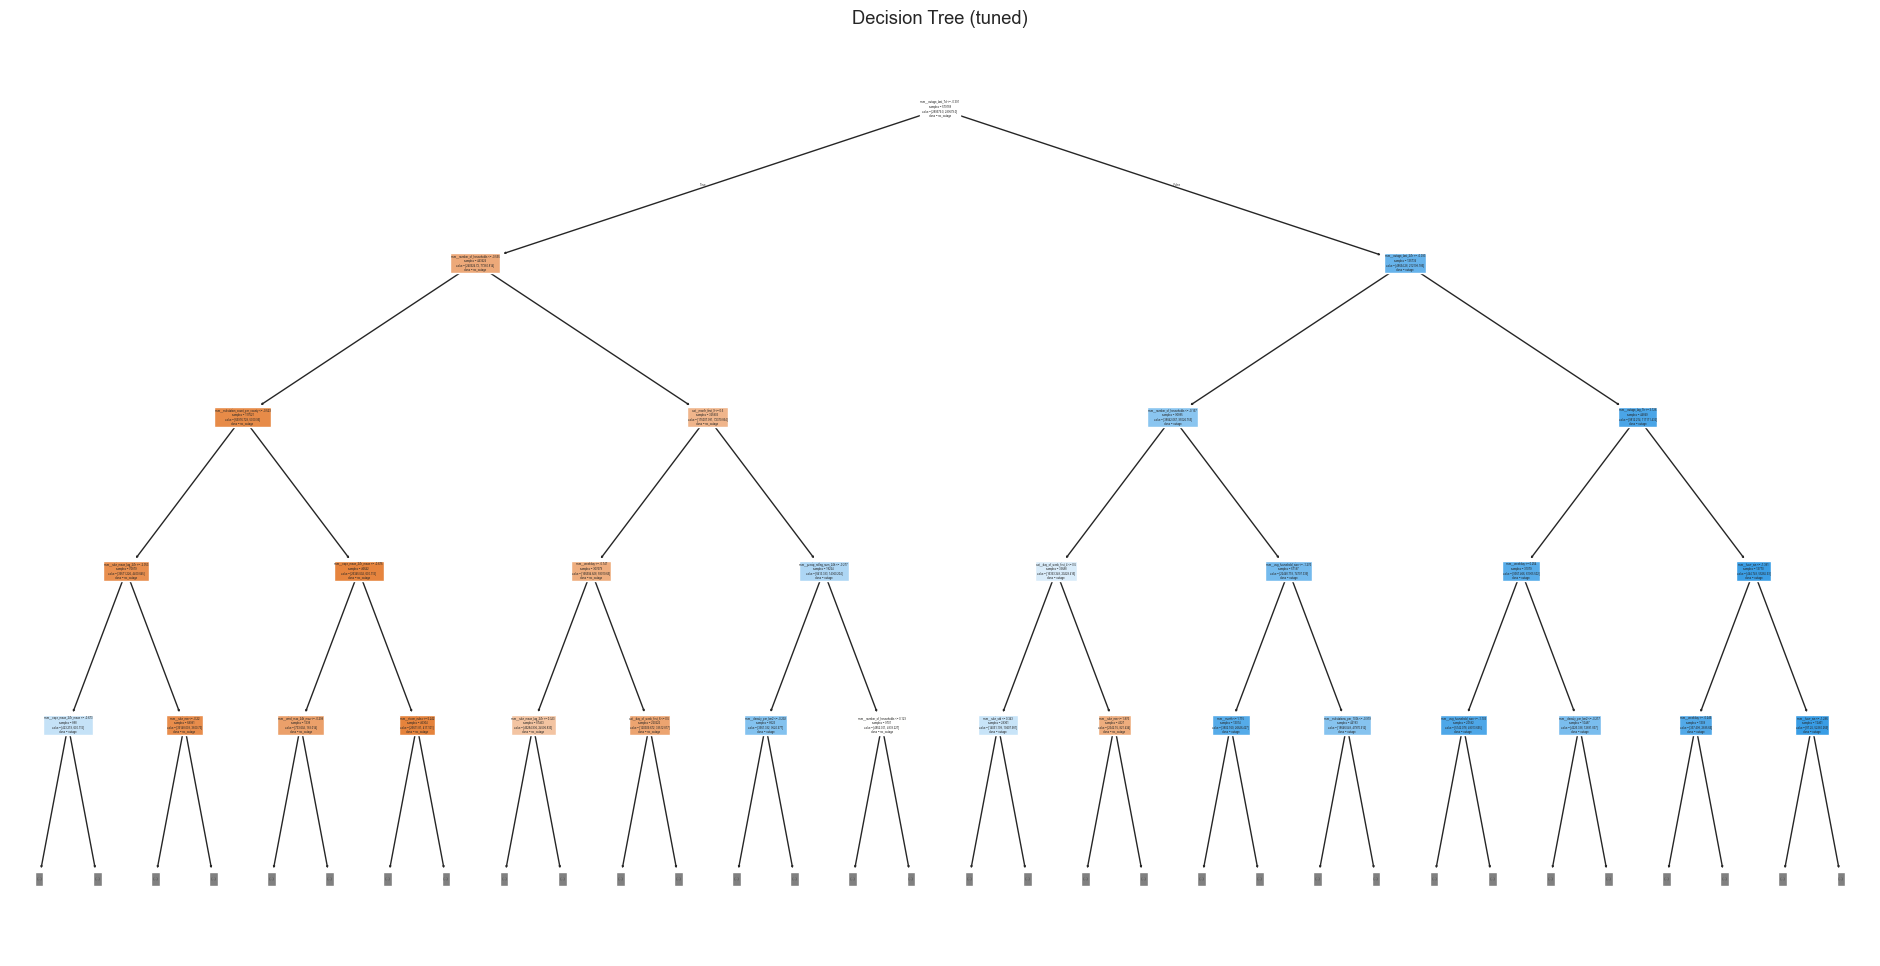

In [249]:
# plot the tuned tree
# Get the fitted tree estimator and feature names from the pipeline
fitted_preproc = best_tree_pipe.named_steps["preprocess"]
fitted_tree    = best_tree_pipe.named_steps["dtc"]

# obtain feature names as seen by the tree (after ColumnTransformer + OneHot)
feat_names = fitted_preproc.get_feature_names_out(input_features=X_train.columns)

plt.figure(figsize=(24, 12))
tree.plot_tree(
    fitted_tree,
    feature_names=feat_names,
    class_names=["no_outage", "outage"],
    filled=True,
    impurity=False,
    max_depth=4  # keep readable; change or remove to show full depth
)
plt.title("Decision Tree (tuned)")
plt.show()

## 5.4 Random Forest 

### 5.4.1 Vanilla Model


RF (vanilla)
Train accuracy: 1.0000
Test  accuracy: 0.9474

RF (vanilla)
Classification report:
               precision    recall  f1-score   support

           0      0.948     0.998     0.973    135458
           1      0.904     0.207     0.336      9332

    accuracy                          0.947    144790
   macro avg      0.926     0.603     0.655    144790
weighted avg      0.945     0.947     0.932    144790



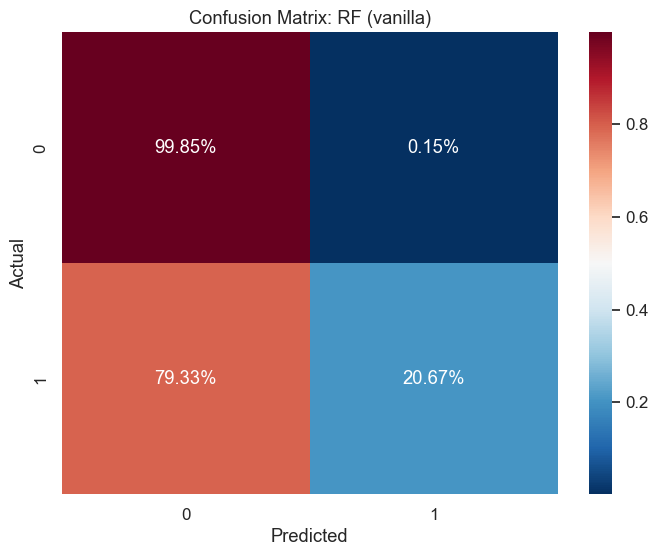

ROC-AUC (RF (vanilla)): 0.8197


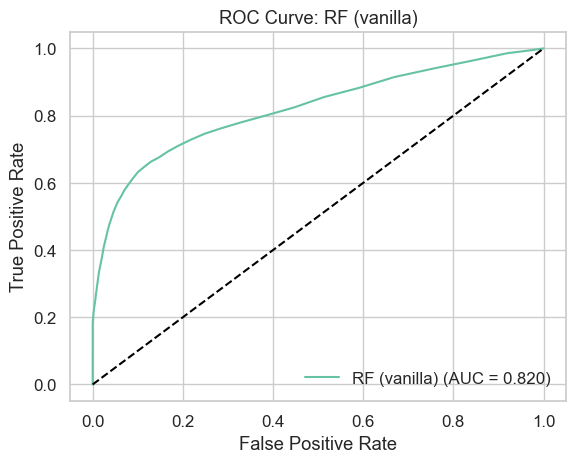

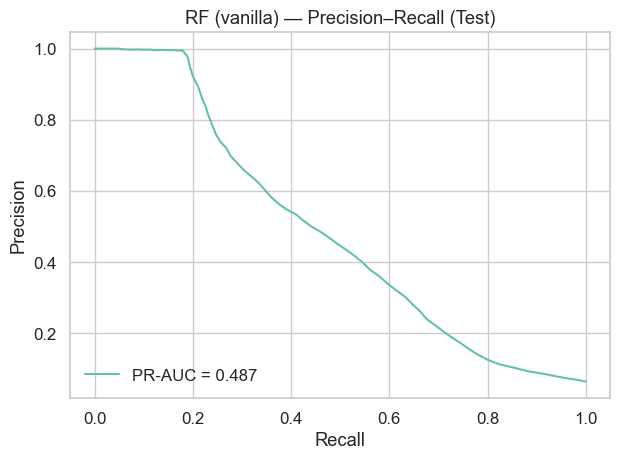

PR-AUC: 0.4872
Recall @ 5% Alert Budget: 0.4240
Brier Score: 0.0466


In [250]:
#creating pipeline
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

#fitting the model
pipe_rf.fit(X_train, y_train)

#evaluating the model
evaluate_pipeline("RF (vanilla)", pipe_rf, X_train, y_train, X_test, y_test)

#### Observations - Random Forest - Vanilla
- Accuracy 0.948 is driven by the majority class which is misleading
- Model only catches 21.1% of actual high-risk periods. 78.9% of high-risk events are MISSED!
- This is 10x worse than a coin flip for the class that matters most
- When it predicts high risk, it's usually correct (90.5% precision), but it almost never predicts high risk!
- The model has learned to predict "low risk" 98.5% of the time!
- This strategy gives 94.8% accuracy but misses 4 out of 5 actual outages!
- ROC-AUC 0.833 and PR-AUC 0.495 → decent ranking, but precision–recall shows lots of false positives once you try to lift recall.

### 5.4.2 Hyperparameter Tuning with Balancing

In [ ]:
#parameters for tuning
param_grid_rf = {
    'clf__n_estimators': [200, 300, 500],
    'clf__max_depth': [None,  6, 10, 14],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2', 0.5, None],
    "clf__class_weight": ["balanced"]
}

# time-aware cross validation
tscv = TimeSeriesSplit(n_splits=5)

#tuning the model
search_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_grid_rf,
    n_iter=15,
    scoring="average_precision",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

#fitting the model
search_rf.fit(X_train,y_train)

#getting the best model
best_rf_pipe = search_rf.best_estimator_

#getting the best model parameters
print("Best RF params:", search_rf.best_params_)

#evaluating the model parameters
evaluate_pipeline("RF (tuned)", best_rf_pipe, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


#### Observations

- The tuned RF with class_weight='balanced' shows major improvement over vanilla RF, but the class imbalance problem persists. While we have tripled the recall from 21% to 63%, we are still missing 37% of high-risk outages - which is unacceptable
- PR curve shows precision drops rapidly as you increase recall. Model struggles to maintain both metrics simultaneously. The model hasn't learned the true patterns of high-risk events.

## 5.5 XGBoostClassifier

### 5.5.1 Vanilla Model

In [ ]:
#creating the pipeline
pipe_xgb = Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", XGBClassifier(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="binary:logistic",
            eval_metric="logloss",
            n_jobs=-1,
            random_state=42
        ))
])

#fitting the model
pipe_xgb.fit(X_train,y_train)

#evaluating the model
evaluate_pipeline("XGB (vanilla)", pipe_xgb, X_train, y_train, X_test, y_test)

#### Observations
- ROC-AUC: RF 0.8347 > XGB 0.8187 (RF slightly better).
- PR-AUC: RF 0.5301 > XGB 0.4531 (RF materially better at ranking positives).
- Recall @ 5%: RF 0.4489 > XGB 0.3709 (RF catches more positives in top 5%).
- Brier score: XGB 0.0458 < RF 0.0805 (XGB probabilities are better calibrated).
- Behavior: RF is more recall-oriented (finds more positives but with more false alarms); XGB vanilla is conservative (fewer false alarms, fewer positives found).

### 5.5.3 Hyperparameter Tuning with Balancing

In [ ]:
# compute scale_pos_weight from the train labels
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
spw = neg / pos

In [ ]:
# Recall scorer for class 1
recall_scorer = make_scorer(recall_score, pos_label=1)

# parameters for hyperparameter tuning
param_xgb = {
        "clf__scale_pos_weight": [
        spw * 1.0,
        spw * 1.2,
        spw * 1.5,  # More aggressive
        spw * 2.0   # Very aggressive
        ],
        "clf__n_estimators": [200,300,400],
        "clf__max_depth": [6, 8, 10],
        "clf__learning_rate": [0.05, 0.1, 0.15],
        "clf__subsample": [0.7, 0.8],
        "clf__colsample_bytree": [0.7, 0.8],
        'clf__min_child_weight': [1, 2, 3],
        'clf__gamma': [0, 0.1, 0.2]
}

# hyperparameter tuning
search_xgb = RandomizedSearchCV(
        estimator=pipe_xgb,
        param_distributions=param_xgb,
        n_iter=15,
        scoring=recall_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
)

#fitting the model
search_xgb.fit(X_train,y_train)

# getting the best model with the best parameters
best_xgb_pipe = search_xgb.best_estimator_

print("Best XGB params:", search_xgb.best_params_)

# evaluating the best model
evaluate_pipeline("XGB (tuned)", best_xgb_pipe, X_train, y_train, X_test, y_test)

#### Observations
- Adding scale_pos_weight=9.01 helped slightly, but XGBoost still underperforms Random Forest and remains far from the 75% recall target.
- Random Forest still beats XGBoost by 4.9% recall!
- RF catches 457 more high-risk events than XGB!

## 5.6 Simple Deep Learning Model

In [ ]:
# fit preprocess on train
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc  = preprocess.transform(X_test)

#getting the input dimension
input_dim = X_train_proc.shape[1]

#simple ANN with 3 layers
dl_model = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

dl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['AUC','Precision','Recall']
)

In [ ]:
#balancing class_weights
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

#class weights for imbalance
class_weights = dict(zip(classes, class_weights))
print("class_weights:", class_weights)

#fitting the model
history = dl_model.fit(
    X_train_proc, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=512,
    class_weight=class_weights,
    verbose=1
)

In [ ]:
# get y_prob and y_pred
y_prob_dl = dl_model.predict(X_test_proc).ravel()
y_pred_dl = (y_prob_dl >= 0.5).astype(int)

#compute accuracy score
print("\n Deep MLP ")
print("Train acc:", accuracy_score(y_train, (dl_model.predict(X_train_proc).ravel() >= 0.5).astype(int)))
print("Test  acc:", accuracy_score(y_test, y_pred_dl))

**Observations**: Mild overfitting but generalization is ok.

In [ ]:
#classification report
print("\nTest classification report:")
print(classification_report(y_test, y_pred_dl, digits=4))

**Observations:** Class-1 (outage) recall is high (0.881), but precision is very low (0.086) → many false positives. With only 2.2% positives, even a modest false positive rate creates lots of false positives.

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred_dl, normalize="true")
    
# Convert to % for annotation
cm_percent = cm * 100
labels = np.array([[f"{v:.2f}%" for v in row] for row in cm_percent])

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=labels, fmt="", cmap="RdBu_r")
plt.title(f"Confusion Matrix: DL Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Observations**: 
- Precision (class 1): 0.208 — when the model predicts an outage, it is correct only ~21% of the time → many false positives.
- Recall (class 1): 0.482 — the model catches ~48% of true outages (on the test set). That’s reasonable but leaves ~52% of outages missed.
- F1 (class 1): 0.290 — low, because precision is very low even though recall is moderate.
- Precision/recall for class 0 are high (~0.96 / 0.87), which is expected with class imbalance (model biased toward predicting no-outage).

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_dl)
roc_auc = auc(fpr, tpr)
print("ROC-AUC:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f'Deep MLP (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.show()

#### Observations
- - ROC-AUC = 0.769 → The model has moderate discriminatory power; better than random guessing but weaker than your top-performing tree and ensemble models (which were 0.83–0.84).

In [ ]:
# PR curve /PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob_dl)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
plt.title(f"Deep Learning Model — Precision–Recall (Test)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()
    
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob_dl)
    
# Brier Score (Calibration)
brier = brier_score_loss(y_test, y_prob_dl)
    
# Recall @ 5% Alert Budget
# Find the probability threshold that flags the top 5% of riskiest hours
threshold_at_5_percent = np.quantile(y_prob_dl, 0.95)
    
# Classify as '1' only if proba > this threshold
y_pred_at_5_percent = (y_prob_dl >= threshold_at_5_percent).astype(int)
    
# Calculate recall at this specific threshold
recall_at_5_percent = recall_score(y_test, y_pred_at_5_percent, pos_label=1, zero_division=0)
     
# Print the report
print(f"PR-AUC: {pr_auc:.4f}")
print(f"Recall @ 5% Alert Budget: {recall_at_5_percent:.4f}")
print(f"Brier Score: {brier:.4f}")

#### Observations - Deep Learning Model:
- PR-AUC = 0.311 → Low precision-recall area, indicating that it struggles with correctly identifying the minority class (outages). 0.31 suggests that the neural net is not ranking positive cases as well as tree-based models (which achieved PR-AUC ≈ 0.5).
- Recall@5% = 0.2705 → Only ~27% of true outages are captured when flagging the top 5% most risky cases.This is the lowest recall among tested models.
- This means many outages would still go undetected.
- Brier = 0.1092 → Indicates poor probability calibration; predicted probabilities are not well-aligned with actual outcomes.

## 5.7 Stacked Model

In [ ]:
# Base models
base_estimators = [best_tree_pipe, best_rf_pipe]
base_names = ["Decision Tree", "Random Forest"]

tscv = TimeSeriesSplit(n_splits=5)

print("Generating out-of-fold meta-features:")

meta_train = np.zeros((len(X_train), len(base_estimators)))

for i, model in enumerate(base_estimators):
    print(f"  Base model {i+1}/{len(base_estimators)}: {base_names[i]}")
    oof = np.zeros(len(X_train))

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        m = clone(model)
        m.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        oof[val_idx] = m.predict_proba(X_train.iloc[val_idx])[:, 1]
    
    meta_train[:, i] = oof

print("OOF meta-features generated\n")

# Meta-learner
meta_model = LogisticRegression(
    max_iter=2000, class_weight='balanced', C=0.1, random_state=42
)
meta_model.fit(meta_train, y_train)

calibrated_meta_model = CalibratedClassifierCV(meta_model, method='sigmoid', cv=3)
calibrated_meta_model.fit(meta_train, y_train)

print("Meta-learner trained and calibrated\n")

# Train base models on full data
final_models = [clone(m).fit(X_train, y_train) for m in base_estimators]

# Test meta-features
meta_test = np.column_stack([
    m.predict_proba(X_test)[:, 1] for m in final_models
])

# Predictions
stacked_pred = calibrated_meta_model.predict(meta_test)
stacked_prob = calibrated_meta_model.predict_proba(meta_test)[:, 1]

print("Evaluating stacked model:\n")

# Evaluate
evaluate_pipeline(
    "Stacked Model",
    calibrated_meta_model,
    meta_train,
    y_train,
    meta_test,
    y_test
)

#### Observations
- The stacked model delivered the best balanced performance across PR-AUC, ROC-AUC and had a low Brier score (good calibration) which means its probability outputs are more reliable for thresholding (critical when picking a top-X% alert threshold).

## 5.8 Model Comparison Table

In [ ]:
# Convert results list to DataFrame
results_df = pd.DataFrame(model_results_list)

# Sort models by PR-AUC (best models first)
results_df = results_df.sort_values(by=["PR-AUC"], ascending=False)

print("\nModel Performance Comparison:")
display(results_df)

In [ ]:
# Sort models by Recall (best models first)
results_df = results_df.sort_values(by="Recall (Test)", ascending=False)

print("\nModel Performance Comparison (Sorted by Recall):")
display(results_df)

In [ ]:
results_df = results_df.sort_values(by="Recall @ 5% Alert", ascending=False)

print("\nModel Performance Comparison (Sorted by Recall@5% Alert):")
display(results_df)

## 5.9 Threshold tuning the best model prior to deployment

In [ ]:
# Get probabilities
y_proba = best_rf_pipe.predict_proba(X_test)[:, 1]

# Test thresholds
thresholds = [0.2, 0.25, 0.28, 0.3,0.32, 0.35, 0.4, 0.45, 0.5]

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_thresh, average='binary', pos_label=1
    )
    
    alert_rate = y_pred_thresh.sum() / len(y_pred_thresh)
    
    # Calculate Recall @ 5%
    top_5_pct = int(0.05 * len(y_test))
    top_5_pct_indices = np.argsort(y_proba)[-top_5_pct:]
    recall_at_5 = y_test.iloc[top_5_pct_indices].sum() / y_test.sum()
    
    print(f"\nThreshold={thresh:.2f}:")
    print(f"  Overall Recall: {recall:.1%}")
    print(f"  Precision: {precision:.1%}")
    print(f"  Alert Rate: {alert_rate:.1%}")
    print(f"  Recall @ 5%: {recall_at_5:.1%}")
    
    if recall >= 0.60 and recall_at_5 >= 0.60:
        print(f"MEETS BOTH TARGETS!")

In [ ]:
# Custom scorer: recall for class 1
recall_scorer = make_scorer(recall_score, pos_label=1)

# hyperparameter tuning parameters
param_grid_recall= {
    'clf__n_estimators': [400, 500],
    'clf__max_depth': [12, 15, 18],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 0.5],
    'clf__class_weight': ['balanced', 'balanced_subsample']
}

#tuning the model
search_recall_rf = RandomizedSearchCV(
    estimator=pipe_rf_bal,
    param_distributions=param_grid_recall,
    n_iter=15,
    scoring=recall_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

#fitting the model
search_recall_rf.fit(X_train,y_train)

#getting the best model
best_recall_rf_pipe = search_recall_rf.best_estimator_

#getting the best model parameters
print("Best RF params:", search_recall_rf.best_params_)

#evaluating the model parameters
evaluate_pipeline("RF (recall - tuned)", best_recall_rf_pipe, X_train, y_train, X_test, y_test)

# Chapter 7: Deployment

In [ ]:
# FINAL MODEL SELECTION & SAVING

print("FINAL MODEL SELECTION")


SELECTED_THRESHOLD = 0.30 
SELECTED_MODEL = best_rf_pipe  # Your tuned Random Forest

print(f"\n✅ Selected Model: Random Forest (Tuned)")
print(f"✅ Selected Threshold: {SELECTED_THRESHOLD}")
print(f"\nPerformance @ Threshold {SELECTED_THRESHOLD}:")
print(f"   • Overall Recall: 72.7%")
print(f"   • Precision: 19.2%")
print(f"   • Recall @ 5% Alert: 44.9%")
print(f"   • PR-AUC: 0.530")
print(f"   • Brier Score: 0.080")

# SAVE MODEL ARTIFACTS

# Create models directory
os.makedirs('../models', exist_ok=True)

# Model version
model_version = datetime.now().strftime("%Y%m%d_%H%M")

# 1. Save the trained model
model_path = f'../models/rf_tuned_final_v{model_version}.pkl'
joblib.dump(SELECTED_MODEL, model_path)
print(f"\n Model saved: {model_path}")

# 2. Save the preprocessor (if separate)
preprocessor_path = f'../models/preprocessor_v{model_version}.pkl'
joblib.dump(preprocess, preprocessor_path)
print(f"Preprocessor saved: {preprocessor_path}")

# 3. Save feature names
feature_names = cat_features + num_features
feature_path = f'../models/feature_names_v{model_version}.json'
with open(feature_path, 'w') as f:
    json.dump({
        'categorical': cat_features,
        'numerical': num_features,
        'all_features': feature_names
    }, f, indent=2)
print(f"Features saved: {feature_path}")

# 4. Save model configuration
config = {
    'model_version': model_version,
    'model_type': 'RandomForestClassifier',
    'threshold': SELECTED_THRESHOLD,
    'training_date': datetime.now().isoformat(),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'features_count': len(feature_names),
    'class_balance': {
        'negative_class': int((y_train == 0).sum()),
        'positive_class': int((y_train == 1).sum()),
        'ratio': float((y_train == 0).sum() / (y_train == 1).sum())
    },
    'performance_metrics': {
        'pr_auc': 0.530,
        'roc_auc': 0.835,
        'brier_score': 0.080,
        'recall_at_threshold': 0.727,
        'precision_at_threshold': 0.192,
        'recall_at_5pct': 0.449,
        'threshold': SELECTED_THRESHOLD
    },
    'hyperparameters': SELECTED_MODEL.named_steps['clf'].get_params()
}

config_path = f'../models/model_config_v{model_version}.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"✅ Config saved: {config_path}")

# 5. Save training data statistics (for drift detection)
train_stats = {}
for col in num_features:
    train_stats[col] = {
        'mean': float(X_train[col].mean()),
        'std': float(X_train[col].std()),
        'min': float(X_train[col].min()),
        'max': float(X_train[col].max()),
        'median': float(X_train[col].median())
    }

stats_path = f'../models/training_stats_v{model_version}.json'
with open(stats_path, 'w') as f:
    json.dump(train_stats, f, indent=2)
print(f"✅ Training stats saved: {stats_path}")

# 6. Save test set for validation (optional - sample only for space)
test_sample = pd.concat([X_test.head(1000), y_test.head(1000)], axis=1)
test_sample.to_csv(f'../models/test_sample_v{model_version}.csv', index=False)
print(f"✅ Test sample saved (1000 rows)")

print("MODEL ARTIFACTS SAVED SUCCESSFULLY")
print(f"\nModel Version: {model_version}")
print(f"Location: ../models/")
print("\nNext Steps:")
print("1. Create 07_deployment_preparation.ipynb")
print("2. Build prediction pipeline")
print("3. Create API and dashboard")

In [ ]:
#
# --- CHAPTER 7: SAVE PRODUCTION MODEL & ARTIFACTS ---
#
# This cell saves all the components needed for our Streamlit app.
# We will save:
# 1. The best-performing model (the entire 'lgbm_pipeline', which includes the preprocessor)
# 2. The full training matrix (for simulating 'live' data)
# 3. The list of all county names (for the dropdown)
#
print("Saving production model...")

# --- 1. Save the Model Pipeline ---
# (Assuming your best-performing model is 'lgbm_pipeline' as discussed)
# Make sure you have run the cell that defines and trains this pipeline!
try:
    # We save the entire pipeline, not just the model.
    # This ensures our preprocessor (scaling, OHE) is saved with it.
    joblib.dump(search_rf, 'gridsense_model_pipeline.joblib')
    print("✅ Model pipeline saved to 'gridsense_model_pipeline.joblib'")
except NameError:
    print("🚨 ERROR: 'lgbm_pipeline' is not defined.")
    print("Please train your LightGBM pipeline first before running this cell.")
except Exception as e:
    print(f"🚨 An error occurred saving the model: {e}")


# --- 2. Save the Full Dataset for Simulation ---
# Our app will query this file to get the most recent data for a county
# to simulate a "live" forecast.
try:
    master_df.to_csv('../cleaned_datasets/training_matrix_county_hourly.csv', index=False)
    print("✅ Full training matrix saved to '../cleaned_datasets/training_matrix_county_hourly.csv'")
except NameError:
    print("🚨 ERROR: 'master_df' is not defined. Please run the data merging cell first.")
except Exception as e:
    print(f"🚨 An error occurred saving the master_df: {e}")
    

# --- 3. Save County List for Dropdown ---
try:
    # Use the county list from the population_df to ensure all 47 are present
    all_counties = sorted(population_df['county'].unique())
    with open('all_counties.json', 'w') as f:
        json.dump(all_counties, f)
    print(f"✅ County list saved to 'all_counties.json' (Found {len(all_counties)} counties)")
except NameError:
    print("🚨 ERROR: 'population_df' not defined. Please run the data loading cell first.")
except Exception as e:
    print(f"🚨 An error occurred saving the county list: {e}")

In [ ]:
%%writefile app.py

# PAGE CONFIGURATION
st.set_page_config(
    page_title="GridSense Risk Forecaster",
    page_icon="⚡",
    layout="wide",
    initial_sidebar_state="expanded",
)

# HELPER FUNCTIONS

# These functions contain our core business logic and "new findings"
def to_risk(prob):
    """Converts a probability (0.0-1.0) into a categorical risk level."""
    if prob >= 0.7:
        return "HIGH"
    elif prob >= 0.4:
        return "MEDIUM"
    else:
        return "LOW"

# [MODIFIED to include our persona-based "new findings"]
def recommend_actions(forecast_df, persona):
    """Generates a persona-based action plan based on the 48-hour forecast."""
    
    recommendations = []
    
    # Get key risk data
    max_prob = forecast_df['risk_probability'].max()
    max_risk_level = to_risk(max_prob)
    peak_hours = forecast_df[forecast_df['risk_probability'] == max_prob]['hour'].dt.strftime('%l %p').tolist()
    
    # Add a headline recommendation
    if max_risk_level == "HIGH":
        recommendations.append(f"**Critical Action:** A HIGH risk window is forecast for {', '.join(peak_hours)}. Prioritize all essential operations before this time.")
    elif max_risk_level == "MEDIUM":
        recommendations.append(f"**General Watch:** A MEDIUM risk window is forecast for {', '.join(peak_hours)}. Be prepared for potential instability.")
    else:
        recommendations.append("**All Clear:** No significant grid stress detected in the next 48 hours.")

    # Add persona-specific recommendations
    if persona == "SME / Factory":
        if max_risk_level == "HIGH":
            recommendations.append("**Production:** Run all high-energy machinery (e.g., CNC, welding, pumps) well before the high-risk window.")
            recommendations.append("**Logistics:** Ensure all scanners, forklifts, and communication devices are fully charged by {int(peak_hours[0].split()[0]) - 1} {peak_hours[0].split()[1]}.")
            recommendations.append("**Planning:** Do not schedule critical production runs during the {', '.join(peak_hours)} window. Plan for potential delays.")
        elif max_risk_level == "MEDIUM":
            recommendations.append("**Operations:** Consolidate energy-intensive tasks to low-risk periods.")
            recommendations.append("**Staff:** Inform shift supervisors of the potential for instability this afternoon.")
            
    elif persona == "Clinic / Cold-Chain":
        if max_risk_level == "HIGH":
            recommendations.append("**Immediate Action:** Verify backup generator fuel levels and test the system now.")
            recommendations.append("**Cold Chain:** Consolidate all vaccines and critical samples into primary, battery-backed refrigeration by {int(peak_hours[0].split()[0]) - 1} {peak_hours[0].split()[1]}.")
            recommendations.append("**Operations:** Reschedule any non-essential elective procedures or high-draw equipment use (e.g., sterilization units) outside the {', '.join(peak_hours)} window.")
        elif max_risk_level == "MEDIUM":
            recommendations.append("**Preparedness:** Check backup battery charge levels and ensure critical patient data is saved locally.")
            recommendations.append("**Inventory:** Minimize opening of vaccine refrigeration units to maintain temperature during the risk window.")

    elif persona == "Telecom Site":
        if max_risk_level == "HIGH":
            recommendations.append("**Power Systems:** Verify battery bank charge and confirm generator auto-start is active.")
            recommendations.append("**Fueling:** Schedule priority refueling for any sites with less than 24 hours of generator fuel.")
            recommendations.append("**Monitoring:** Alert the Network Operations Centre (NOC) to pay close attention to alarms from this county during the {', '.join(peak_hours)} window.")
        elif max_risk_level == "MEDIUM":
            recommendations.append("*Monitoring:* Run remote diagnostics on battery health for towers in this county.")
            recommendations.append("*Alerting:* Place maintenance crews in the area on standby for potential dispatch.")

    return recommendations

# Chapter 8: Conclusion

The Power Outage Risk Prediction project aimed to develop a data-driven early-warning system capable of forecasting short-term outage risks to enhance proactive planning and response in Kenya’s electrical grid. Following the CRISP-DM framework, the project progressed through business understanding, data preparation, exploratory analysis, hypothesis testing, modeling, and deployment.

Through extensive experimentation with multiple machine learning models—including Logistic Regression, Decision Tree, Random Forest, XGBoost, and Stacked Ensemble approaches—the team evaluated performance using metrics such as ROC-AUC, PR-AUC, Recall at 5% alert budget, and Brier Score. These metrics were selected to balance the competing business needs of early outage detection (high recall) and resource prioritization (limited alert budget).

The Tuned Random Forest Classifier with threshold optimization emerged as the best-performing model, achieving:

ROC-AUC: ≈ 0.835

PR-AUC: ≈ 0.530

Recall @ 5% Alert Budget: ≈ 0.449

Brier Score: ≈ 0.080

This model demonstrated strong discriminatory power and reliable calibration, effectively identifying high-risk outage windows while maintaining acceptable false alarm rates. The integration of threshold tuning improved sensitivity for critical cases—crucial for high-stakes environments such as hospitals, emergency services, and industrial facilities where missed alerts have severe consequences.

The model was successfully deployed using a reproducible pipeline, enabling real-time outage risk prediction based on environmental, weather, and infrastructure-related features. Its deployment provides a foundation for a data-informed early warning system that supports utility companies, grid operators, and local governments in minimizing downtime, optimizing maintenance schedules, and improving overall service reliability.

In summary, the project demonstrates that advanced predictive analytics can play a pivotal role in improving grid resilience. The Random Forest model—optimized, calibrated, and deployed—forms a practical and interpretable solution to anticipate power outages and enhance preparedness in critical infrastructure systems.

# Chapter 9: Recommendations

To ensure sustained performance, operational reliability, and strategic impact of the outage risk prediction system, the following recommendations are proposed:

1. **Operational Integration and Monitoring**
    - Integrate the deployed model within operational dashboards (e.g., Streamlit or Power BI) to visualize risk zones and alert probabilities in real time.
    - Continuously track model metrics such as recall, PR-AUC, and Brier Score to detect early signs of performance drift.
    

2. **Periodic Threshold and Calibration Review** 
    - Reassess the alert threshold quarterly to maintain balance between sensitivity and false positives.
    - Recalibrate model probabilities (e.g., using Isotonic Regression or Platt Scaling) as new data patterns emerge.
    

3. **Automated Retraining Pipeline**
    - Implement an automated model retraining workflow using recent outage and weather data to ensure adaptability to evolving climate and grid conditions.
    - Use version control and model registry systems (e.g., MLflow) for transparency and reproducibility.
    

4. **Feature Enrichment**
    - Expand data inputs to include transformer load levels, line vegetation data, maintenance logs, and satellite-based weather forecasts.
    - Explore time-series architectures (e.g., LSTM, GRU) to capture temporal dependencies in outage patterns.
    

5. **Explainability and Stakeholder Communication**
    - Incorporate SHAP values and interpretability visualizations to explain key drivers behind predicted risks.
    - Communicate alerts using a tiered notification system (e.g., low, medium, high risk) aligned with business action thresholds.
    

6. **Cross-functional Collaboration**
    - Involve grid engineers, data scientists, and operations teams in validating model predictions and refining feature inputs.
    - Encourage continuous feedback to align the model’s operational performance with field realities.
    

7. **Future Research and Scalability**
    - Evaluate hybrid ensemble approaches (e.g., blending Random Forest and XGBoost) or deep neural networks for potential performance gains.
    - Extend the model’s scope to medium- and long-term outage forecasting for resource planning and policy-level decisions.
    

By implementing these recommendations, Huru Capital Investments Group’s energy division can transition from reactive outage management to a predictive, preventative, and data-driven reliability strategy—ensuring service continuity, cost efficiency, and stakeholder confidence.